In [20]:
#%pip install statsmodels

### First, import packages and set default plotting parameters

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
from venn import venn
import seaborn as sns
from matplotlib.colors import LogNorm
import statsmodels.api as sm

In [22]:
# Set seaborn theme to white
sns.set_theme(style='white')

# set up matplotlib theme
andy_theme = {'axes.grid': False,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': False,
              'legend.fontsize': 14,
              'legend.title_fontsize': 14,
              'font.sans-serif':'Helvetica',
              'xtick.labelsize': 12,
              'ytick.labelsize': 12,
              'axes.labelsize': 16,
              'axes.titlesize': 18,
              'figure.dpi': 300}
plt.rcParams.update(andy_theme)

#Uncomment next 2 lines if matplotlib can not find Helvetica font
#plt.rcParams['font.family'] = 'DeJavu Serif'
#plt.rcParams['font.sans-serif'] = ['Arial']

## 1. FIRST ORDER ANALYSES

### Load the datasets with neurons and connections.

* This script assumes that the **CSV** files (`.csv.gz`) and **aStN-SAs lists** (`_new.csv` files) are in the same folder as this notebook or script.
* These files include four CSVs containing manually curated  aStN-SAs lists and four connectome datasets from FlyWire:
  1. **`classification.csv.gz`**
  2. **`connections_princeton.csv.gz`**
  3. **`neuropil_synapse_table.csv.gz`**
  4. **`neurons.csv.gz`**
* **Axon lists** were curated manually as described in the paper.
* **Connectome datasets** were downloaded from the FlyWire website using **snapshot 783** (previous snapshot 630).
* We focus on putative sensory axons from the Drosophila **pharyngeal nerve** in this analysis.


In [23]:
# Connections dataset and additional data sets
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz'
)

neuropil_synapse = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/neuropil_synapse_table.csv.gz'
)[['root_id', 'input synapses', 'output synapses']]
neuropil_synapse.rename(
    columns={'input synapses': 'input_synapses', 'output synapses': 'output_synapses'},
    inplace=True
)

classification = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id', 'side']]
classification_other = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id', 'super_class', 'class']]

neurons = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/neurons.csv.gz')[['root_id', 'nt_type']]

neurons_data = pd.merge(
    neurons,
    pd.merge(classification, neuropil_synapse, on='root_id', how='outer'),
    on='root_id', how='outer'
)

# Load putative StN-SA lists (six sets)
set_1 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_1.csv')
set_2 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_2.csv')
set_3 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_3.csv')
set_4 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_4.csv')
set_5 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_5.csv')
set_6 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_6.csv')


In [24]:
#fig.show(renderer="browser")
#fig.write_html("sankey_diagram.html")

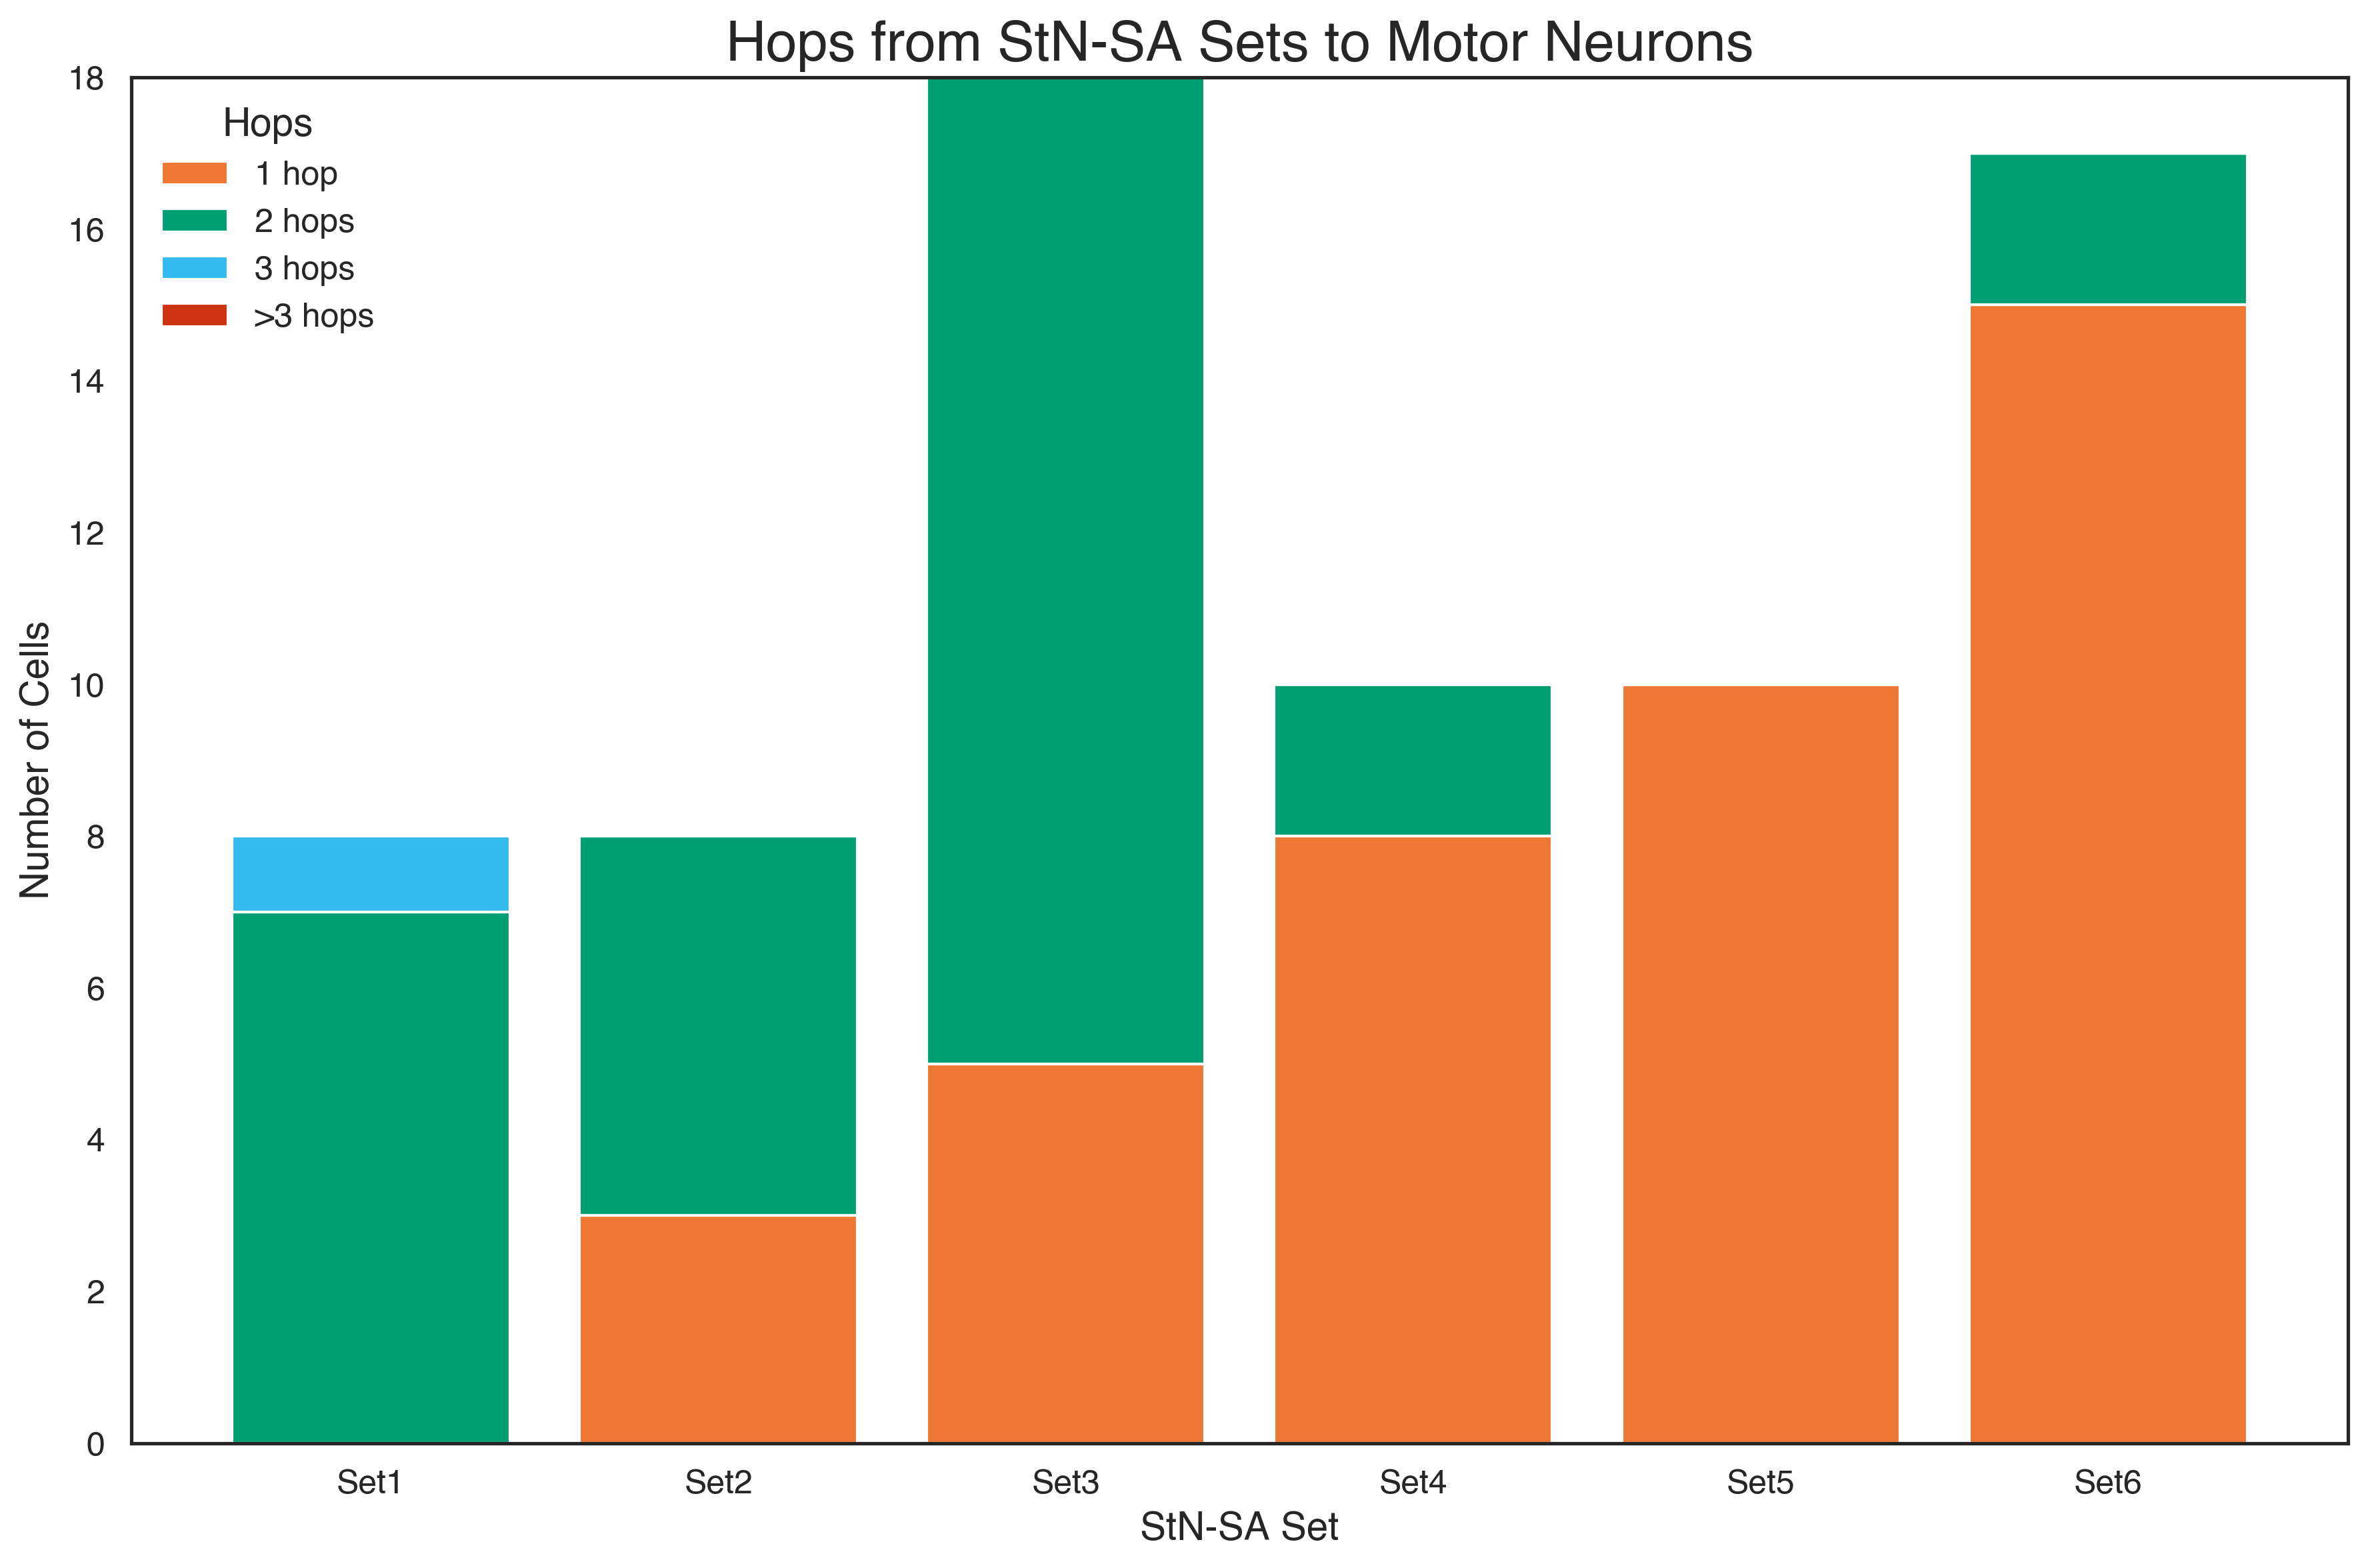

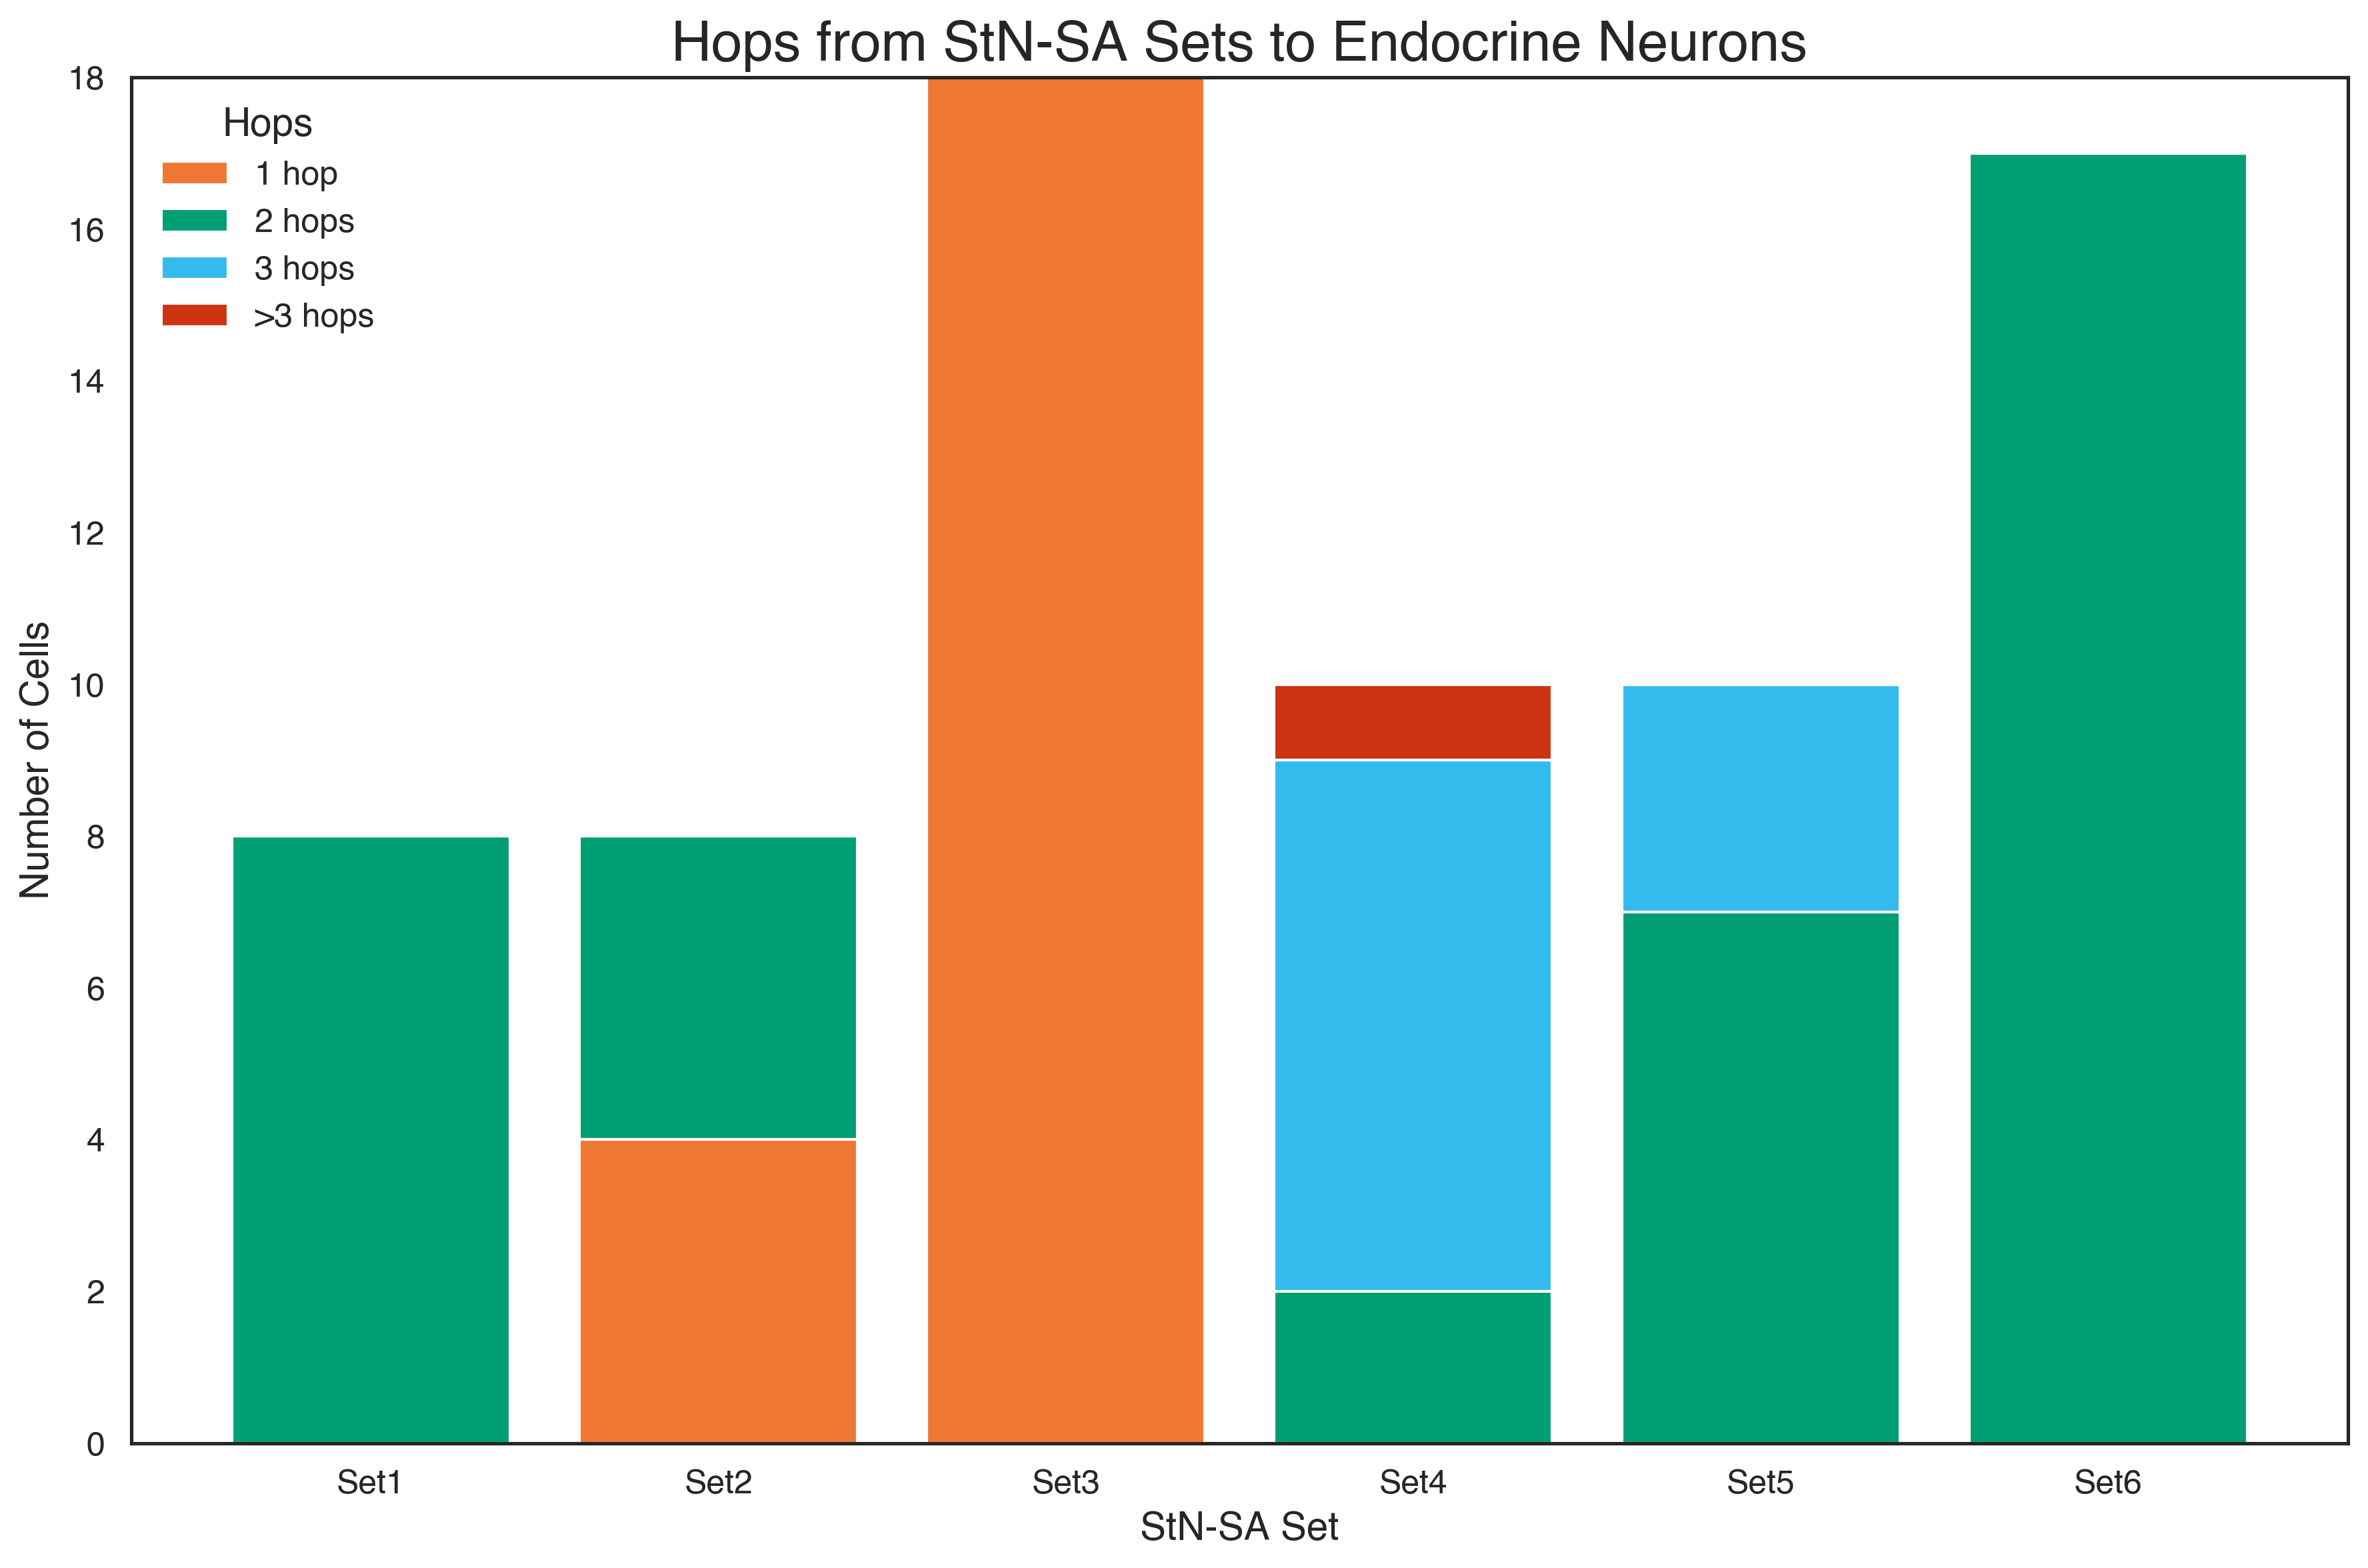

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict

# ───────────────────────────────────────────────────────────────────────────────
# 0. LOAD ALL YOUR DATASETS
# ───────────────────────────────────────────────────────────────────────────────
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz'
)

neuropil_synapse = (
    pd.read_csv(
        '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
        'YaoLabUF/YaoLab/Drosophila_brain_model/neuropil_synapse_table.csv.gz'
    )
    [['root_id','input synapses','output synapses']]
    .rename(columns={
        'input synapses':'input_synapses',
        'output synapses':'output_synapses'
    })
)

classification_side = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id','side']]

classification_other = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id','super_class']]

super_map = classification_other.set_index('root_id')['super_class'].to_dict()

neurons = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/neurons.csv.gz'
)[['root_id','nt_type']]

neurons_data = pd.merge(
    neurons,
    pd.merge(classification_side, neuropil_synapse, on='root_id', how='outer'),
    on='root_id',
    how='outer'
)

# ───────────────────────────────────────────────────────────────────────────────
# 1. BUILD THRESHOLDED ADJACENCY LIST (≥5 synapses)
# ───────────────────────────────────────────────────────────────────────────────
edge_df = (
    connections
    .groupby(['pre_root_id','post_root_id'], as_index=False)
    .agg({'syn_count':'sum'})
    .query('syn_count >= 5')
    [['pre_root_id','post_root_id']]
)

adj = defaultdict(set)
for u, v in edge_df.values:
    adj[int(u)].add(int(v))

# ───────────────────────────────────────────────────────────────────────────────
# 2. LOAD YOUR SIX StN-SA_v2 SETS & DEFINE THE “sets” DICT
# ───────────────────────────────────────────────────────────────────────────────
sets = {
    f'Set{i}': pd.read_csv(
        f'/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv'
    )['root_id'].astype(int)
    for i in range(1, 7)
}

# ───────────────────────────────────────────────────────────────────────────────
# 3. BFS HELPER TO COMPUTE MINIMAL HOPS TO A TARGET CLASS
# ───────────────────────────────────────────────────────────────────────────────
def compute_hops(src_ids, target_class):
    hop_of = {}
    for src in src_ids:
        if src not in adj:
            hop_of[src] = None
            continue

        visited = {src}
        queue = deque([(src, 0)])
        found = None

        while queue and found is None:
            node, dist = queue.popleft()
            if dist >= 3:
                continue
            for nei in adj[node]:
                if nei in visited:
                    continue
                visited.add(nei)
                nd = dist + 1
                if super_map.get(nei) == target_class:
                    found = nd
                    break
                queue.append((nei, nd))

        hop_of[src] = found

    counts = {'1':0,'2':0,'3':0,'>3':0}
    for h in hop_of.values():
        if h in (1,2,3):
            counts[str(h)] += 1
        else:
            counts['>3'] += 1

    return pd.DataFrame({
        'hop':  ['1','2','3','>3'],
        'count':[counts['1'],counts['2'],counts['3'],counts['>3']]
    })

# ───────────────────────────────────────────────────────────────────────────────
# 4. RUN FOR “motor” AND “endocrine” & PLOT STACKED BARS
# ───────────────────────────────────────────────────────────────────────────────
custom_colors = [
    '#EE7733',  # Vibrant Orange
    '#009E73',  # Vivid Blue
    '#33BBEE',  # Cyan
    '#CC3311'   # Red
]

for target in ['motor','endocrine']:
    all_df = []
    for label, ids in sets.items():
        df_h = compute_hops(ids, target)
        df_h['set'] = label
        all_df.append(df_h)

    df_stack = pd.concat(all_df, ignore_index=True)
    df_stack['hop'] = pd.Categorical(df_stack['hop'], ['1','2','3','>3'], ordered=True)
    df_stack['set'] = pd.Categorical(df_stack['set'], list(sets.keys()), ordered=True)

    pivot = df_stack.pivot(index='set', columns='hop', values='count').fillna(0)

    fig, ax = plt.subplots(figsize=(12,8))
    bottom = np.zeros(len(pivot), dtype=int)
    for i, hop in enumerate(['1','2','3','>3']):
        ax.bar(pivot.index, pivot[hop], bottom=bottom,
               color=custom_colors[i],
               label=f"{hop} hop{'s' if hop!='1' else ''}")
        bottom += pivot[hop].values

    ax.set_title(f"Hops from StN-SA Sets to {target.capitalize()} Neurons", fontsize=20)
    ax.set_xlabel("StN-SA Set", fontsize=14)
    ax.set_ylabel("Number of Cells", fontsize=14)
    ax.tick_params(labelsize=12)
    ax.legend(title="Hops", frameon=False, prop={'size':12})

    fig.set_size_inches(12, 8)
    #fig.savefig(f"hops_to_{target}.svg", format='svg', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


In [26]:
for target in ['motor','endocrine']:
    # … all your plotting code …

    plt.tight_layout()
    # define a filename based on the target
    filename = f"hops_to_{target}.svg"
    # save it out at 1200×800px
    fig.set_size_inches(12, 8)
    #fig.savefig(filename, format='svg', dpi=300, bbox_inches='tight')
    plt.show()


<Figure size 1920x1440 with 0 Axes>

<Figure size 1920x1440 with 0 Axes>

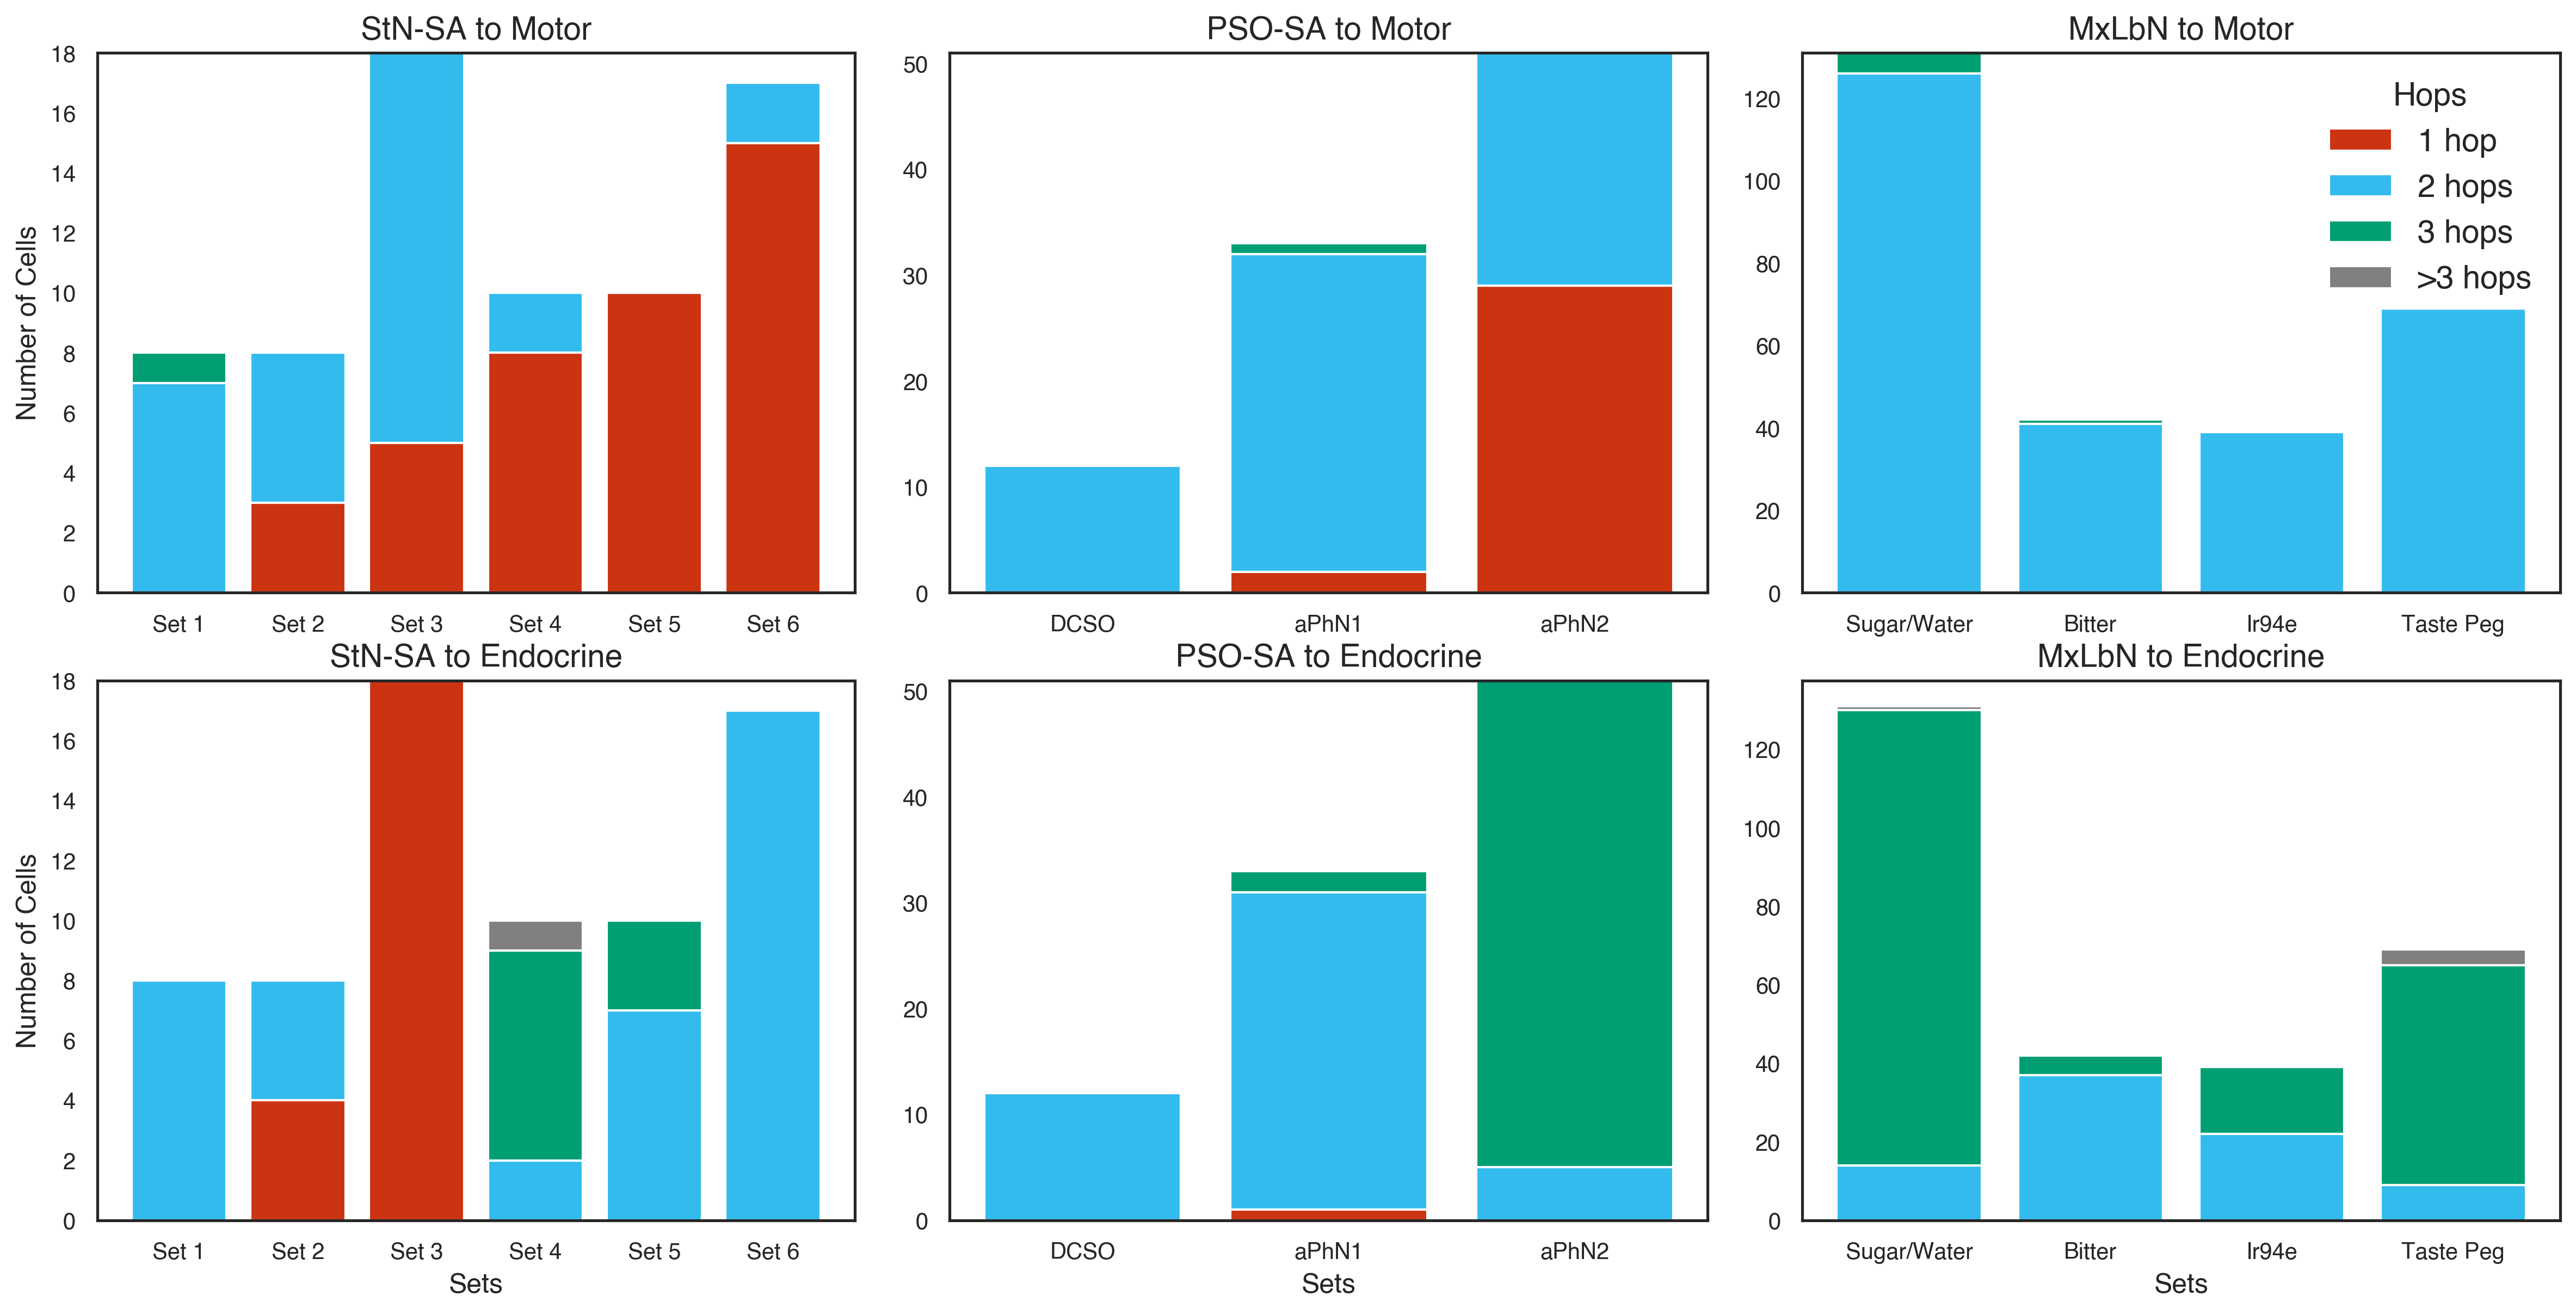

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict

# ───────────────────────────────────────────────────────────────────────────────
# 0. LOAD SHARED DATA: connectome + classification + build adjacency & super_map
# ───────────────────────────────────────────────────────────────────────────────
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz'
)
classification = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id', 'super_class']]

edge_df = (
    connections
    .groupby(['pre_root_id', 'post_root_id'], as_index=False)
    .agg({'syn_count': 'sum'})
    .query('syn_count >= 5')
)[['pre_root_id', 'post_root_id']]

adj = defaultdict(set)
for u, v in edge_df.values:
    adj[int(u)].add(int(v))

super_map = classification.set_index('root_id')['super_class'].to_dict()

def compute_hops(src_ids, target_class):
    hop_of = {}
    for src in src_ids:
        if src not in adj:
            hop_of[src] = None
            continue
        visited = {src}
        queue = deque([(src, 0)])
        found = None
        while queue and found is None:
            node, dist = queue.popleft()
            if dist >= 3:
                continue
            for nei in adj[node]:
                if nei in visited:
                    continue
                visited.add(nei)
                nd = dist + 1
                if super_map.get(nei) == target_class:
                    found = nd
                    break
                queue.append((nei, nd))
        hop_of[src] = found
    counts = {'1':0,'2':0,'3':0,'>3':0}
    for h in hop_of.values():
        if h in (1,2,3):
            counts[str(h)] += 1
        else:
            counts['>3'] += 1
    return pd.DataFrame({
        'hop': ['1','2','3','>3'],
        'count': [counts['1'], counts['2'], counts['3'], counts['>3']]
    })

# ───────────────────────────────────────────────────────────────────────────────
# 1. DEFINE WORKFLOWS
# ───────────────────────────────────────────────────────────────────────────────
workflows = []

# StN-SA_v2 (6 sets)
stn_sets = {
    f'Set {i}': pd.read_csv(
        f'/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv'
    )['root_id'].astype(int)
    for i in range(1, 7)
}
workflows.append(('StN-SA', stn_sets))

# PSO (3 sets)
PSO_paths = {
    'DCSO':  '/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3/set_1.csv',
    'aPhN1': '/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3/set_2.csv',
    'aPhN2': '/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3/set_3.csv',
}
PSO_sets = {name: pd.read_csv(path)['root_id'].astype(int)
            for name, path in PSO_paths.items()}
workflows.append(('PSO-SA', PSO_sets))

# MxLbN GRNs (4 sets)
grn_paths = {
    'Sugar/Water': "/Users/yaolab/Downloads/sugar_water_GRNs.csv",
    'Bitter':      "/Users/yaolab/Downloads/bitter_GRNs.csv",
    'Ir94e':       "/Users/yaolab/Downloads/Ir94e_GRNs.csv",
    'Taste Peg':   "/Users/yaolab/Downloads/taste_peg_GRNs.csv",
}
grn_sets = {name: pd.read_csv(path)['root_id'].astype(int)
            for name, path in grn_paths.items()}
workflows.append(('MxLbN', grn_sets))



# ───────────────────────────────────────────────────────────────────────────────
# 2. PLOT 2×3 GRID: motor on top row, endocrine on bottom row
# ───────────────────────────────────────────────────────────────────────────────
targets = ['motor', 'endocrine']
custom_colors = ['#CC3311', '#33BBEE', '#009E73', 'gray']

n_workflows = len(workflows)
fig, axes = plt.subplots(2, n_workflows, figsize=(n_workflows * 5, 10), sharey=False)

for row, target in enumerate(targets):
    for col, (wf_name, sets_dict) in enumerate(workflows):
        ax = axes[row, col]

        # ---- compute and pivot ----
        all_df = []
        for label, ids in sets_dict.items():
            df_h = compute_hops(ids, target)
            df_h['set'] = label
            all_df.append(df_h)
        df_stack = pd.concat(all_df, ignore_index=True)
        df_stack['hop'] = pd.Categorical(df_stack['hop'], ['1','2','3','>3'], ordered=True)
        df_stack['set'] = pd.Categorical(df_stack['set'], list(sets_dict.keys()), ordered=True)
        pivot = df_stack.pivot(index='set', columns='hop', values='count').fillna(0)

        # ---- stacked bars ----
        bottom = np.zeros(len(pivot), dtype=int)
        for k, hop in enumerate(['1','2','3','>3']):
            ax.bar(
                pivot.index, pivot[hop], bottom=bottom,
                color=custom_colors[k],
                label=f"{hop} hop{'s' if hop!='1' else ''}"
            )
            bottom += pivot[hop].values

        # ---- labels & titles ----
        ax.set_title(f"{wf_name} to {target.capitalize()}", fontsize=14)
        if row == 1:
            ax.set_xlabel("Sets", fontsize=12)
        if col == 0:
            ax.set_ylabel("Number of Cells", fontsize=12)
        ax.tick_params(labelsize=10)

        # ← legend only in top-right panel
        if (row == 0) and (col == n_workflows - 1):
            ax.legend(title="Hops", frameon=False)

plt.tight_layout()
#filename = f'/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF - Documents/General/SVG_figs/Fig7/hops_to_{target}_subplot_pt.svg'
# save it out at 1200×800px
fig.set_size_inches(16,8)
fig.savefig(filename, format='svg', dpi=300, bbox_inches='tight')
plt.show()


In [28]:
# ───────────────────────────────────────────────────────────────────────────────
# 0-bis.  Revised helper: return raw hop distance per neuron
# ───────────────────────────────────────────────────────────────────────────────
def hops_per_neuron(src_ids, target_class):
    """Return a list with the hop distance (1, 2, 3, or 4 for >3/None) for every
    neuron in src_ids when searching for target_class downstream."""
    hop_values = []
    for src in src_ids:
        if src not in adj:
            hop_values.append(4)          # unreachable (None) to 4
            continue
        visited = {src}
        queue   = deque([(src, 0)])
        found   = None
        while queue and found is None:
            node, dist = queue.popleft()
            if dist >= 3:
                continue
            for nei in adj[node]:
                if nei in visited:
                    continue
                visited.add(nei)
                nd = dist + 1
                if super_map.get(nei) == target_class:
                    found = nd
                    break
                queue.append((nei, nd))
        hop_values.append(found if found else 4)
    return hop_values


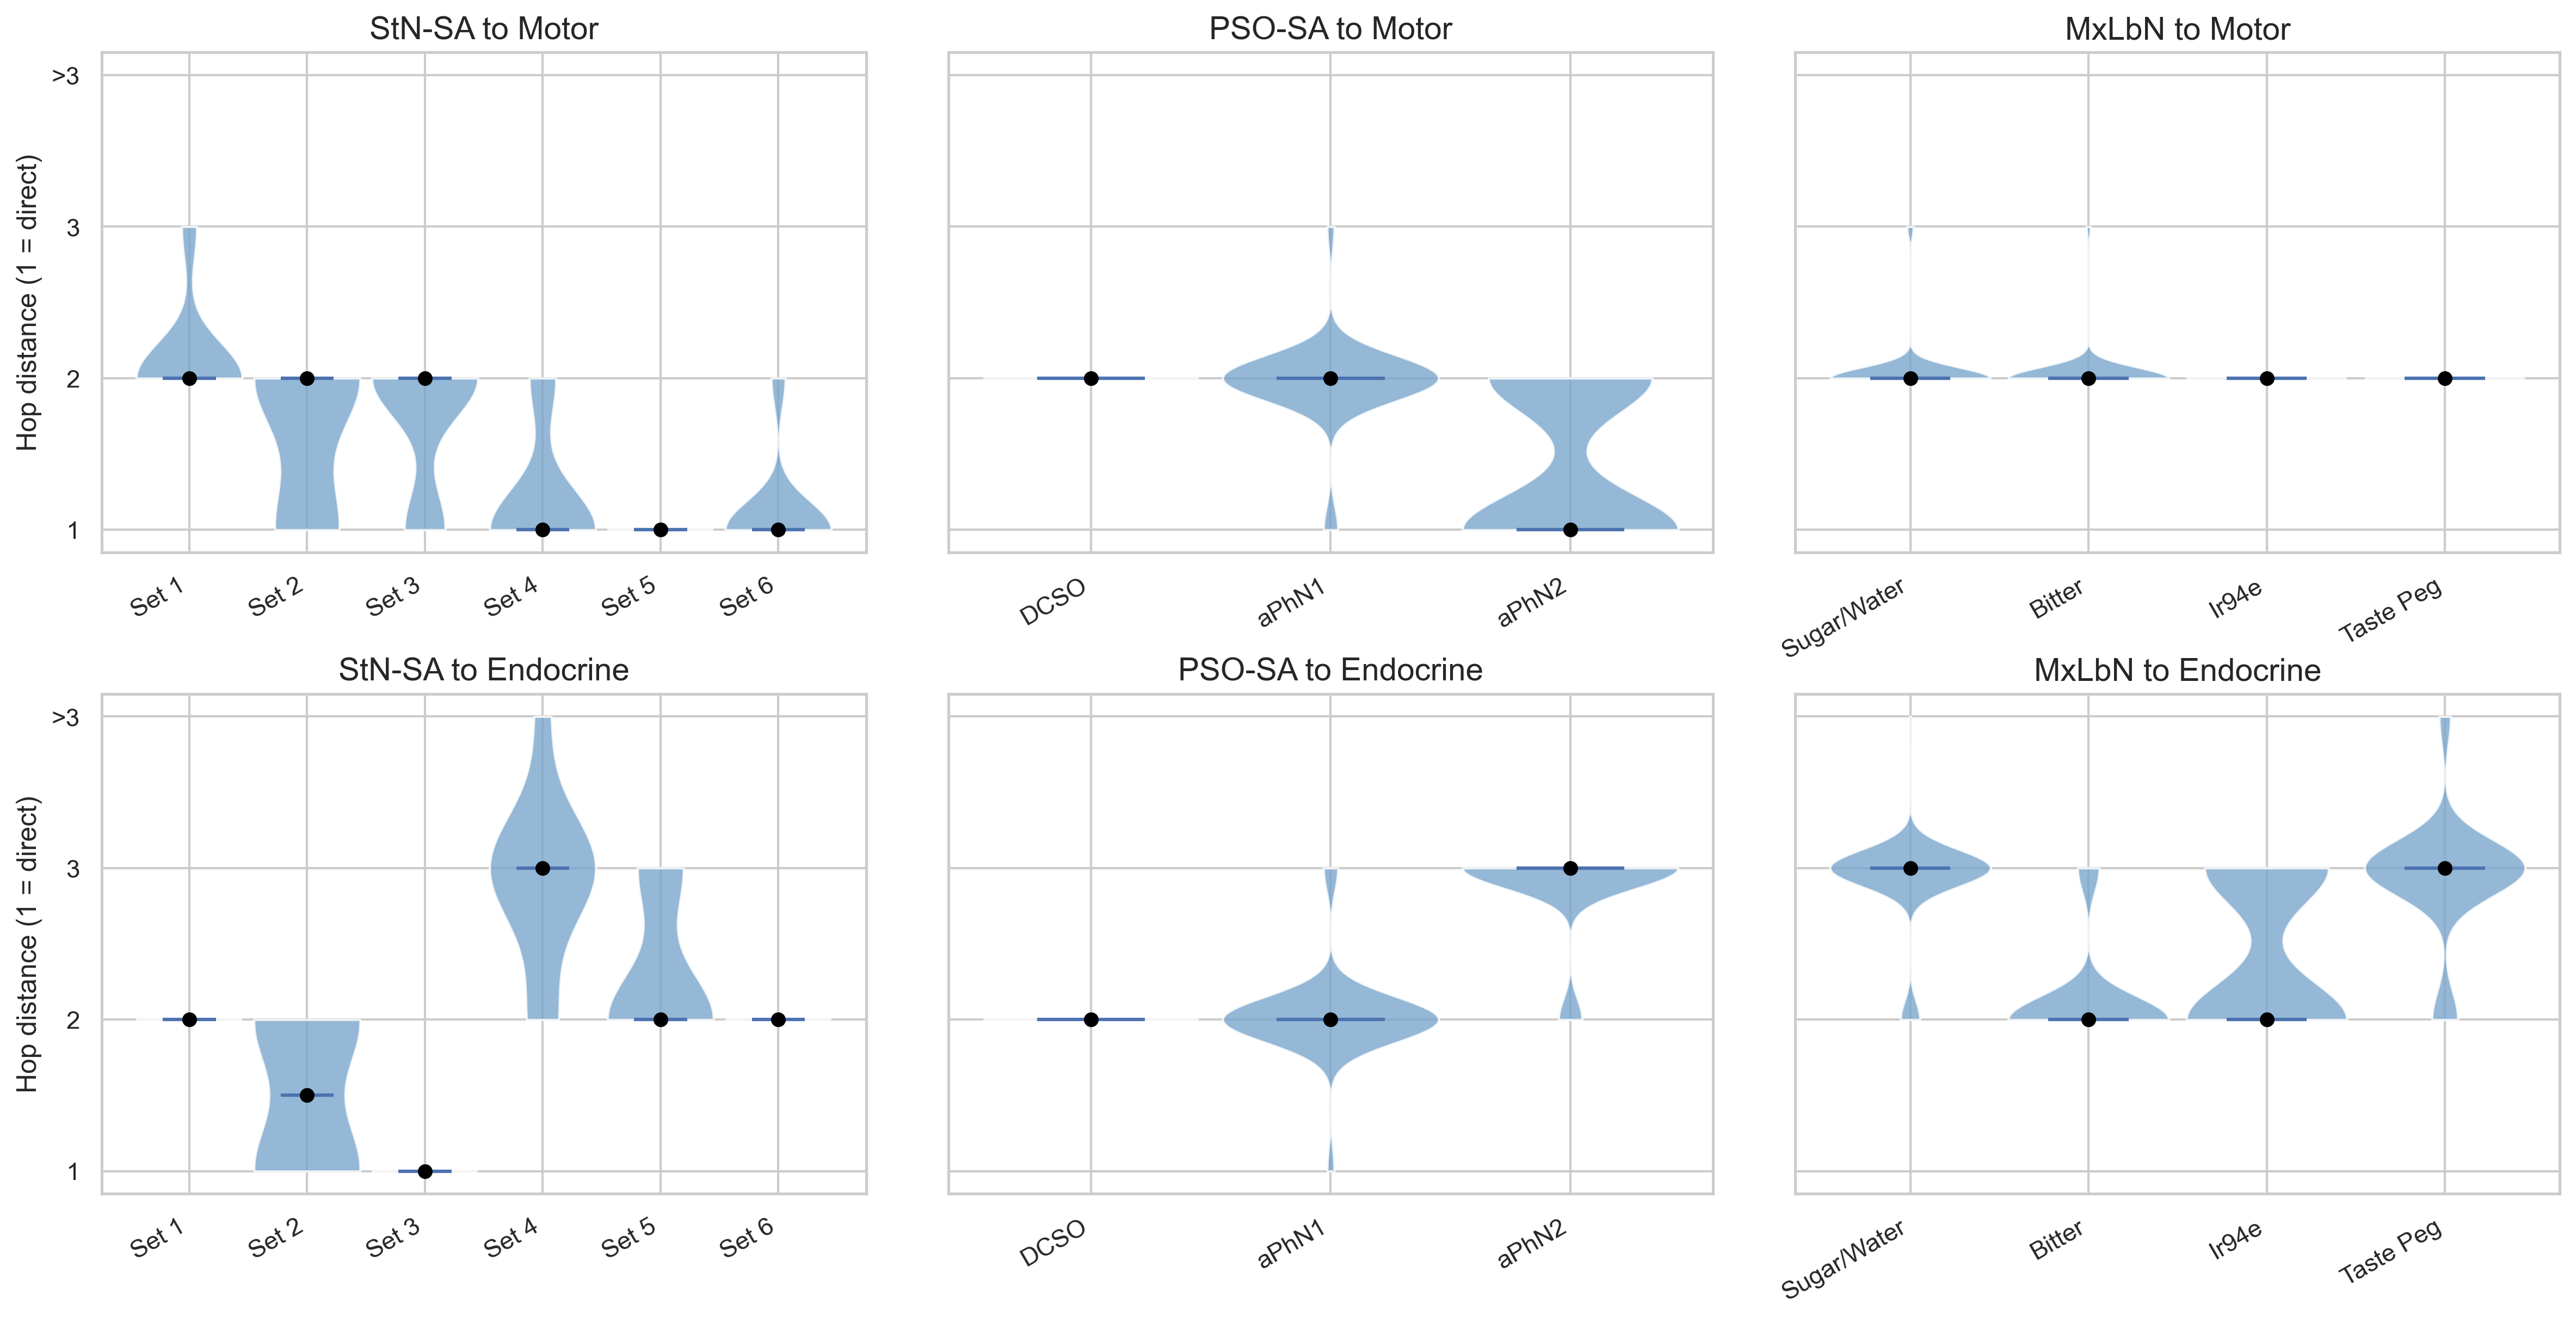

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns  # optional but easier for violins

sns.set(style="whitegrid", rc={"axes.titlesize":14, "axes.labelsize":12})

targets         = ['motor', 'endocrine']
hop_labels      = ['1', '2', '3', '>3']      # for custom tick labels
hop_tick_values = [1, 2, 3, 4]               # numeric y positions
palette         = ['#EE7733', '#009E73', '#33BBEE', '#CC3311']  # color-blind safe

n_workflows = len(workflows)
fig, axes   = plt.subplots(2, n_workflows, figsize=(n_workflows * 5, 10),
                           sharey=True)

for row, target in enumerate(targets):
    for col, (wf_name, sets_dict) in enumerate(workflows):
        ax = axes[row, col]

        # --- gather raw hop distances for every set ----
        violin_data = []
        set_labels  = []
        for label, ids in sets_dict.items():
            hops = hops_per_neuron(ids, target)          # list of ints 1-4
            violin_data.append(hops)
            set_labels.append(label)

        # --- draw violins ---
        parts = ax.violinplot(
            violin_data, positions=np.arange(1, len(violin_data)+1),
            showmeans=False, showmedians=True, showextrema=False, widths=0.9
        )
        # colour each violin for the median (optional, single colour easiest)
        for pc in parts['bodies']:
            pc.set_facecolor('#7AA6CC')
            pc.set_alpha(0.8)

        # --- overlay median dots so hop distributions are clear ---
        medians = [np.median(d) for d in violin_data]
        ax.scatter(np.arange(1, len(medians)+1), medians,
                   color='black', zorder=3, s=30)

        # --- axes cosmetics ---
        ax.set_title(f"{wf_name} to {target.capitalize()}")
        ax.set_xticks(np.arange(1, len(set_labels)+1))
        ax.set_xticklabels(set_labels, rotation=30, ha='right')
        if col == 0:
            ax.set_ylabel("Hop distance (1 = direct)")
        ax.set_yticks(hop_tick_values)
        ax.set_yticklabels(hop_labels)

plt.tight_layout()
fig.set_size_inches(16, 8)
#fig.savefig("hops_to_targets_violin.svg", format='svg', dpi=300, bbox_inches='tight')
plt.show()


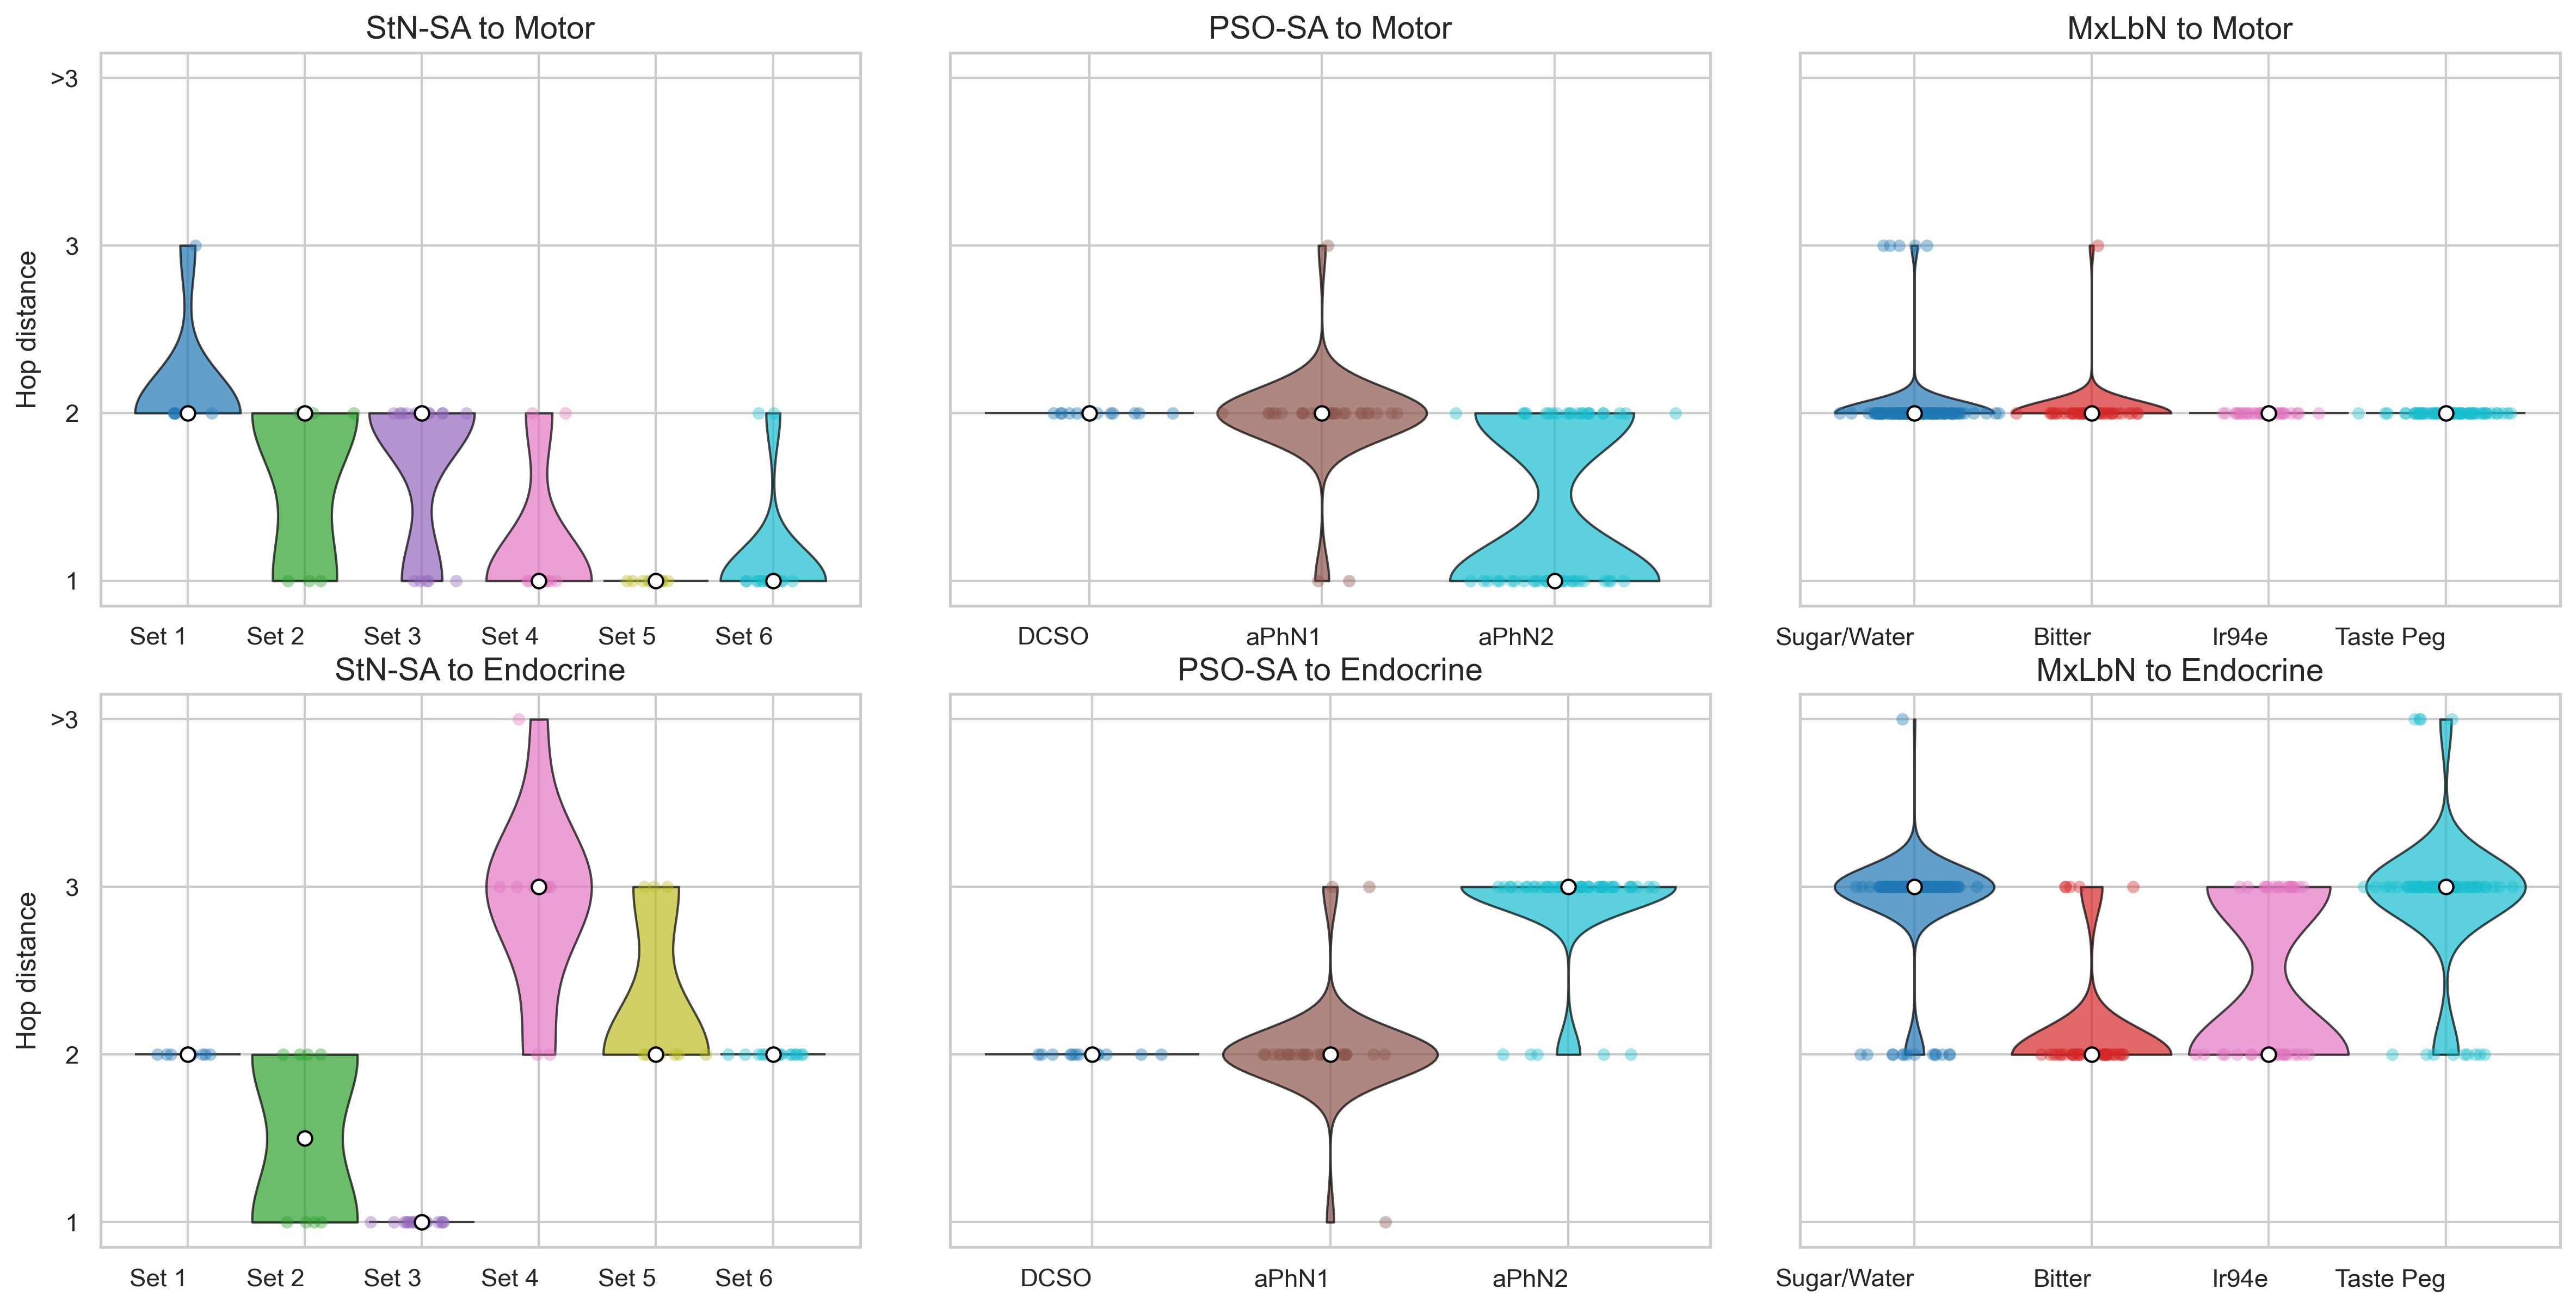

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# … assume adj, super_map, workflows, hops_per_neuron are defined as before …

targets = ['motor', 'endocrine']
hop_ticks  = [1,2,3,4]        # 4 represents “>3”
hop_labels = ['1','2','3','>3']

n_wf = len(workflows)
fig, axes = plt.subplots(2, n_wf, figsize=(n_wf*5, 10), sharey=True)

for row, target in enumerate(targets):
    for col, (wf_name, sets_dict) in enumerate(workflows):
        ax = axes[row, col]

        # collect raw hop distances
        labels      = list(sets_dict.keys())
        violin_data = [hops_per_neuron(ids, target) for ids in sets_dict.values()]
        n_sets      = len(violin_data)

        # draw the violins
        parts = ax.violinplot(
            violin_data,
            positions=np.arange(1, n_sets+1),
            showmeans=False, showmedians=False, showextrema=False,
            widths=0.9
        )

        # pick n_sets distinct colors
        cmap = plt.get_cmap('tab10')
        colors = cmap(np.linspace(0, 1, n_sets))

        # color each violin body
        for idx, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[idx])
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)


        # make the jitter wider
        jitter_width = 0.15    # instead of 0.08

        # make the markers bigger
        marker_size = 30      # instead of 6

        for i, hops in enumerate(violin_data, start=1):
            x_j = np.random.normal(loc=i, scale=jitter_width, size=len(hops))
            ax.scatter(x_j, hops,
                   color=colors[i-1],
                   alpha=0.4,
                   s=marker_size,
                   linewidths=0)

        # overlay median as a bold black‐edged white dot
        medians = [np.median(d) for d in violin_data]
        ax.scatter(np.arange(1, n_sets+1), medians,
                   color='white', edgecolor='black', s=40, zorder=3)

        # labels & ticks
        ax.set_title(f"{wf_name} to {target.capitalize()}")
        ax.set_xticks(np.arange(1, n_sets+1))
        ax.set_xticklabels(labels, rotation=0, ha='right')
        if col == 0:
            ax.set_ylabel("Hop distance")
        ax.set_yticks(hop_ticks)
        ax.set_yticklabels(hop_labels)

plt.tight_layout()
fig.set_size_inches(16, 8)
#fig.savefig("/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF - Documents/General/SVG_figs/Fig7/hops_to_targets_violin_jitter_colored_pt.svg", dpi=300, bbox_inches='tight')
plt.show()



Pairwise Mann–Whitney tests for StN-SA to motor
     set1   set2  U-stat   p-value     p-adj
0   Set 1  Set 2    46.5  0.052204  0.783055
1   Set 1  Set 3    98.5  0.049017  0.735251
2   Set 1  Set 4    73.0  0.001154  0.017311
3   Set 1  Set 5    80.0  0.000065  0.000972
4   Set 1  Set 6   129.0  0.000041  0.000616
5   Set 2  Set 3    65.0  0.651709  1.000000
6   Set 2  Set 4    57.0  0.082990  1.000000
7   Set 2  Set 5    65.0  0.005084  0.076255
8   Set 2  Set 6   102.5  0.010933  0.163994
9   Set 3  Set 4   137.0  0.009898  0.148477
10  Set 3  Set 5   155.0  0.000346  0.005197
11  Set 3  Set 6   245.5  0.000398  0.005977
12  Set 4  Set 5    60.0  0.167489  1.000000
13  Set 4  Set 6    92.0  0.596082  1.000000
14  Set 5  Set 6    75.0  0.293339  1.000000

Pairwise Mann–Whitney tests for PSO-SA to motor
    set1   set2  U-stat   p-value     p-adj
0   DCSO  aPhN1   204.0  0.744061  1.000000
1   DCSO  aPhN2   480.0  0.000436  0.001308
2  aPhN1  aPhN2  1280.0  0.000002  0.000006

Pairw

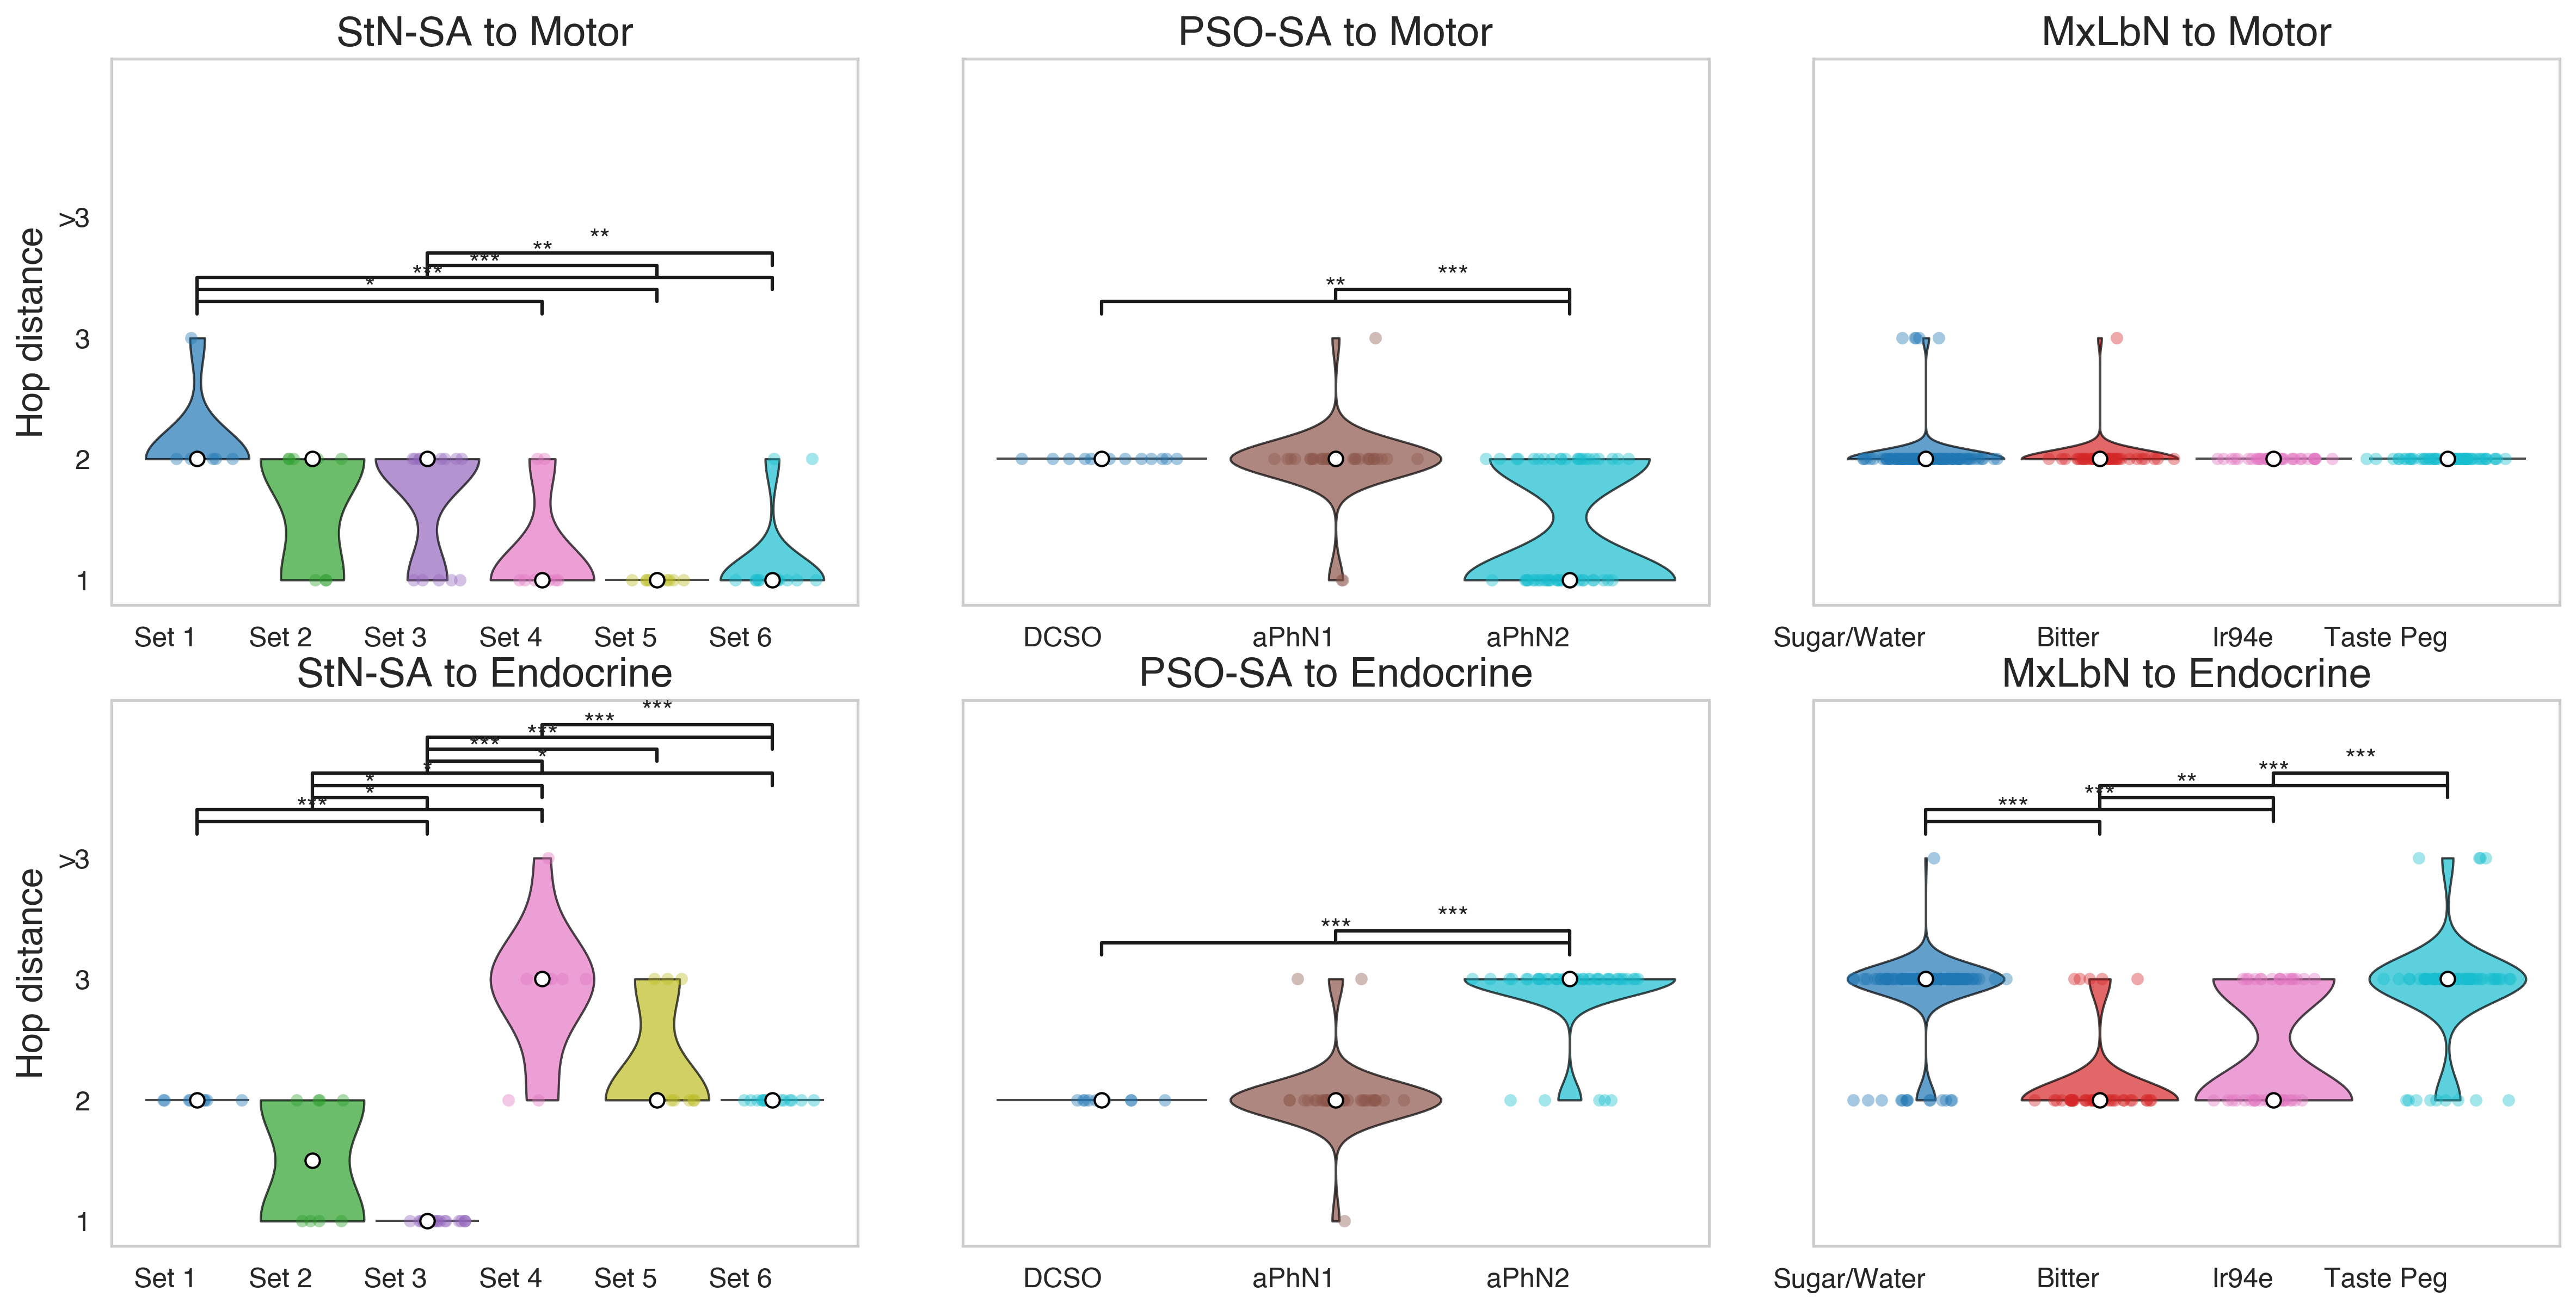

In [31]:
# … after you define hops_per_neuron, workflows, etc. …

from itertools import combinations
from scipy.stats import mannwhitneyu

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────────────────────────────────────────────────────
# Plotting theme
# ───────────────────────────────────────────────────────────────────────────────
sns.set(style="whitegrid", rc={"axes.titlesize":14, "axes.labelsize":12})
andy_theme = {
    'axes.grid': False,
    'grid.linestyle': '--',
    'legend.framealpha': 1,
    'legend.facecolor': 'white',
    'legend.shadow': False,
    'legend.fontsize': 14,
    'legend.title_fontsize': 14,
    'font.sans-serif': 'Helvetica',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'figure.dpi': 300
}
plt.rcParams.update(andy_theme)

# ───────────────────────────────────────────────────────────────────────────────
# Violin + pairwise tests
# ───────────────────────────────────────────────────────────────────────────────
targets    = ['motor', 'endocrine']
n_wf       = len(workflows)
hop_ticks  = [1, 2, 3, 4]          # 4 represents “>3”
hop_labels = ['1', '2', '3', '>3']

fig, axes = plt.subplots(2, n_wf, figsize=(n_wf * 5, 10), sharey=True)

for row, target in enumerate(targets):
    for col, (wf_name, sets_dict) in enumerate(workflows):
        ax = axes[row, col]

        # --- gather raw hop distances for every set ----
        violin_data = []
        set_labels  = []
        for label, ids in sets_dict.items():
            hops = hops_per_neuron(ids, target)   # list of ints 1–4
            violin_data.append(hops)
            set_labels.append(label)

        # --- PAIRWISE MANN–WHITNEY U TESTS -------------
        print(f"\nPairwise Mann–Whitney tests for {wf_name} to {target}")
        records = []
        for (i, lab1), (j, lab2) in combinations(enumerate(set_labels), 2):
            data1, data2 = violin_data[i], violin_data[j]
            stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
            records.append({
                'set1': lab1,
                'set2': lab2,
                'U-stat': stat,
                'p-value': pval
            })
        results_df = pd.DataFrame(records)
        results_df['p-adj'] = np.minimum(1, results_df['p-value'] * len(records))
        print(results_df)

        # --- draw violins ------------------------------
        parts = ax.violinplot(
            violin_data,
            positions=np.arange(1, len(violin_data) + 1),
            showmeans=False, showmedians=False, showextrema=False,
            widths=0.9
        )

        # recompute number of violins here
        n_sets = len(violin_data)
        cmap   = plt.get_cmap('tab10')
        colors = cmap(np.linspace(0, 1, n_sets))

        # color each violin body
        for idx, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[idx])
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)

        # --- annotate significance bars ----------------
        sig_thresh = 0.05
        y_max      = max(max(d) for d in violin_data) + 0.2
        h          = 0.1
        step       = 0

        for _, stat_row in results_df.iterrows():
            if stat_row['p-adj'] < sig_thresh:
                x1 = set_labels.index(stat_row['set1']) + 1
                x2 = set_labels.index(stat_row['set2']) + 1
                p  = stat_row['p-adj']
                if p < 0.001:
                    stars = '***'
                elif p < 0.01:
                    stars = '**'
                else:
                    stars = '*'
                y = y_max + step * h
                ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
                ax.text((x1 + x2) * 0.5, y + h, stars,
                        ha='center', va='bottom', fontsize=12)
                step += 1

        # --- jittered scatter of individual points --------
        jitter_width = 0.15
        marker_size  = 30
        for i, hops in enumerate(violin_data, start=1):
            x_j = np.random.normal(loc=i, scale=jitter_width, size=len(hops))
            ax.scatter(x_j, hops,
                       color=colors[i-1],
                       alpha=0.4,
                       s=marker_size,
                       linewidths=0)

        # --- overlay median as white dot --------------
        medians = [np.median(d) for d in violin_data]
        ax.scatter(
            np.arange(1, n_sets+1),
            medians,
            color='white',
            edgecolor='black',
            s=40,
            zorder=3
        )

        # --- labels & ticks ---------------------------
        ax.set_title(f"{wf_name} to {target.capitalize()}")
        ax.set_xticks(np.arange(1, n_sets+1))
        ax.set_xticklabels(set_labels, rotation=0, ha='right')
        if col == 0:
            ax.set_ylabel("Hop distance")
        ax.set_yticks(hop_ticks)
        ax.set_yticklabels(hop_labels)

plt.tight_layout()
fig.set_size_inches(16, 8)
#fig.savefig("hops_to_targets_violin_jitter_colored.svg", dpi=300, bbox_inches='tight')
plt.show()


In [32]:
import pandas as pd

# 1) Define your two targets
targets = ['motor', 'endocrine']

# 2) Build a long‐form table of every hop distance + metadata
records = []
for target in targets:
    for wf_name, sets_dict in workflows:
        for set_label, ids in sets_dict.items():
            hop_list = hops_per_neuron(ids, target)   # list of ints 1–4
            for hop in hop_list:
                records.append({
                    'workflow':      wf_name,
                    'target':        target,
                    'set':           set_label,
                    'hop_distance':  hop
                })

df_long = pd.DataFrame(records)

# 3) Write to CSV in your working directory
outpath = 'hops_data_for_prism_pt.csv'
df_long.to_csv(outpath, index=False)
print(f"Wrote {len(df_long)} rows to {outpath!r}")

Wrote 896 rows to 'hops_data_for_prism_pt.csv'


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# ----------------------------------------------------------------------------
# 0. Load FlyWire connectome and super_class classification
# ----------------------------------------------------------------------------
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz'
)
classification = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id','super_class']]

# ----------------------------------------------------------------------------
# 1. Build a GLOBAL color map for every superclass once, up-front
# ----------------------------------------------------------------------------
all_classes_global = sorted(classification['super_class'].unique())
palette = px.colors.qualitative.Safe
GLOBAL_COLOR_MAP = {
    cls: palette[i % len(palette)]
    for i, cls in enumerate(all_classes_global)
}

# ----------------------------------------------------------------------------
# 2. Load your six PhN-SA_v2 sets (each CSV has a 'root_id' column)
# ----------------------------------------------------------------------------
sets = {
    f'Set{i}': pd.read_csv(
        f'/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv'
    )
    for i in range(1, 7)
}

# ----------------------------------------------------------------------------
# Helper: filter connections by source IDs, threshold syn_count, attach superclass
# ----------------------------------------------------------------------------
def build_hop_df(src_ids, connections, classification, min_syn=5):
    df = connections[connections['pre_root_id'].isin(src_ids)]
    summed = (
        df.groupby(['pre_root_id','post_root_id'], as_index=False)
          .agg({'syn_count':'sum'})
          .query('syn_count >= @min_syn')
    )
    merged = pd.merge(
        summed,
        classification.rename(
            columns={'root_id':'post_root_id','super_class':'output_super_class'}
        ),
        on='post_root_id', how='left'
    )
    return merged[['pre_root_id','post_root_id','output_super_class','syn_count']]

# ----------------------------------------------------------------------------
# Core: build and show a Sankey diagram with consistent colors
# ----------------------------------------------------------------------------
def plot_sankey_dynamic(grn_df, title, connections, classification, min_syn=5):
    # hops
    df1 = build_hop_df(grn_df['root_id'],            connections, classification, min_syn)
    df2 = build_hop_df(df1['post_root_id'].unique(), connections, classification, min_syn)
    df3 = build_hop_df(df2['post_root_id'].unique(), connections, classification, min_syn)

    # summarize flows
    flow1 = (
        df1.groupby('output_super_class')['syn_count']
           .sum().reset_index(name='count')
           .assign(source=title)
    )
    m12 = pd.merge(df1, df2,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_1','_2'))
    flow2 = (
        m12.groupby(['output_super_class_1','output_super_class_2'])['syn_count_2']
          .sum().reset_index(name='count')
    )
    m23 = pd.merge(df2, df3,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_2','_3'))
    flow3 = (
        m23.groupby(['output_super_class_2','output_super_class_3'])['syn_count_3']
          .sum().reset_index(name='count')
    )

    # nodes
    col1 = [title]
    col2 = [f"1: {c}" for c in sorted(df1['output_super_class'].unique())]
    col3 = [f"2: {c}" for c in sorted(df2['output_super_class'].unique())]
    col4 = [f"3: {c}" for c in sorted(df3['output_super_class'].unique())]
    nodes = col1 + col2 + col3 + col4
    idx   = {node:i for i,node in enumerate(nodes)}

    # colors: reuse the GLOBAL_COLOR_MAP
    node_colors = [
        'lightgrey' if n == title else GLOBAL_COLOR_MAP[n.split(': ',1)[1]]
        for n in nodes
    ]

    # links
    source, target, value, link_colors = [], [], [], []
    def add_links(df, src_col, tgt_col):
        for _, r in df.iterrows():
            s = idx[r[src_col]]
            t = idx[r[tgt_col]]
            source.append(s)
            target.append(t)
            value.append(r['count'])
            link_colors.append(node_colors[s].replace('rgb','rgba').replace(')',',0.5)'))

    # flow1 to 1:class
    flow1 = flow1.rename(columns={'source':'src','output_super_class':'dst'})
    flow1['dst'] = flow1['dst'].map(lambda c: f"1: {c}")
    add_links(flow1, 'src', 'dst')

    # flow2 to 2:class
    flow2 = flow2.rename(columns={
        'output_super_class_1':'src','output_super_class_2':'dst'
    })
    flow2['src'] = flow2['src'].map(lambda c: f"1: {c}")
    flow2['dst'] = flow2['dst'].map(lambda c: f"2: {c}")
    add_links(flow2, 'src', 'dst')

    # flow3 to 3:class
    flow3 = flow3.rename(columns={
        'output_super_class_2':'src','output_super_class_3':'dst'
    })
    flow3['src'] = flow3['src'].map(lambda c: f"2: {c}")
    flow3['dst'] = flow3['dst'].map(lambda c: f"3: {c}")
    add_links(flow3, 'src', 'dst')

    # hover
    incoming = dict.fromkeys(nodes, 0)
    outgoing = dict.fromkeys(nodes, 0)
    for s,t,v in zip(source, target, value):
        outgoing[nodes[s]] += v
        incoming[nodes[t]]  += v
    customdata = [f"Incoming: {incoming[n]}<br>Outgoing: {outgoing[n]}" for n in nodes]

    # positions
    x = [0.0]*len(col1) + [0.33]*len(col2) + [0.66]*len(col3) + [1.0]*len(col4)
    y = []
    for col in (col1, col2, col3, col4):
        n = len(col)
        y.extend([0.5] if n==1 else list(np.linspace(0,1,n)))

    # draw
    fig = go.Figure(go.Sankey(
        arrangement='snap',
        node=dict(
            label=nodes,
            x=x, y=y,
            color=node_colors,
            pad=15,
            thickness=20,
            line=dict(color='black', width=0.5),
            customdata=customdata,
            hovertemplate='%{customdata}<extra>%{label}</extra>'
        ),
        link=dict(source=source, target=target, value=value, color=link_colors)
    ))
    fig.update_layout(title_text=f"{title}", font_size=14)
    fig.write_image(f"{title.replace('/','_')}_pt.svg", width=1200, height=800, scale=2)
    fig.show()

# ----------------------------------------------------------------------------
# 3. Generate a Sankey for each of the six PhN-SA_v2 sets
# ----------------------------------------------------------------------------
for label, df in sets.items():
    plot_sankey_dynamic(df, label, connections, classification)


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from collections import defaultdict

# ----------------------------------------------------------------------------
# 0. Load FlyWire connectome and classification
# ----------------------------------------------------------------------------
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz'
)
classification = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id','super_class']]

# ----------------------------------------------------------------------------
# 1. Load your six PhN-SA_v2 sets (each CSV has a 'root_id' column)
# ----------------------------------------------------------------------------
sets = {
    f'Set{i}': pd.read_csv(
        f'/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv'
    ) for i in range(1, 7)
}

# ----------------------------------------------------------------------------
# Helper: filter connections by source IDs, threshold syn_count, attach superclass
# ----------------------------------------------------------------------------
def build_hop_df(src_ids, connections, classification, min_syn=5):
    df = connections[connections['pre_root_id'].isin(src_ids)]
    summed = (
        df.groupby(['pre_root_id','post_root_id'], as_index=False)
          .agg({'syn_count':'sum'})
          .query('syn_count >= @min_syn')
    )
    merged = pd.merge(
        summed,
        classification.rename(columns={
            'root_id':'post_root_id',
            'super_class':'output_super_class'
        }),
        on='post_root_id', how='left'
    )
    return merged[['pre_root_id','post_root_id','output_super_class','syn_count']]

# ----------------------------------------------------------------------------
# Core: build & show a 3-hop Sankey with df1 pruned to only those that
#       either directly go to motor (hop1tomotor) or reach motor in hop2
# ----------------------------------------------------------------------------
def plot_sankey_dynamic(grn_df, title, connections, classification, min_syn=5):
    # 1) full hop-1, hop-2, hop-3
    df1_full = build_hop_df(grn_df['root_id'], connections, classification, min_syn)
    df2_full = build_hop_df(df1_full['post_root_id'].unique(), connections, classification, min_syn)
    df3_full = build_hop_df(df2_full['post_root_id'].unique(), connections, classification, min_syn)

    # 2) find which hop-2 seeds (pre_root_id) reach motor in hop-3
    motor_in_hop3 = df3_full.loc[df3_full['output_super_class']=='motor','pre_root_id'].unique()

    # 3) prune df1: keep rows where direct to motor or indirect via motor in hop2
    df1 = df1_full[
        (df1_full['output_super_class']=='motor') |
        (df1_full['post_root_id'].isin(motor_in_hop3))
    ].reset_index(drop=True)

    # 4) rebuild hop-2 & hop-3 from pruned df1
    df2 = build_hop_df(df1['post_root_id'].unique(), connections, classification, min_syn)
    df3 = build_hop_df(df2['post_root_id'].unique(), connections, classification, min_syn)

    # --- summarize flows for each hop ---
    flow1 = (
        df1.groupby('output_super_class', as_index=False)['syn_count']
           .sum().rename(columns={'syn_count':'count'})
           .assign(source=title,
                   target=lambda d: '1: ' + d['output_super_class'])
    )

    m12 = pd.merge(df1, df2,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_1','_2'))
    flow2 = (
        m12.groupby(['output_super_class_1','output_super_class_2'], as_index=False)
           ['syn_count_2'].sum()
           .rename(columns={
               'output_super_class_1':'source',
               'output_super_class_2':'target',
               'syn_count_2':'count'
           })
    )
    flow2['source'] = flow2['source'].apply(lambda c: '1: ' + c)
    flow2['target'] = flow2['target'].apply(lambda c: '2: ' + c)

    m23 = pd.merge(df2, df3,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_2','_3'))
    flow3 = (
        m23.groupby(['output_super_class_2','output_super_class_3'], as_index=False)
           ['syn_count_3'].sum()
           .rename(columns={
               'output_super_class_2':'source',
               'output_super_class_3':'target',
               'syn_count_3':'count'
           })
    )
    flow3['source'] = flow3['source'].apply(lambda c: '2: ' + c)
    flow3['target'] = flow3['target'].apply(lambda c: '3: ' + c)

    # --- assemble node lists & indices ---
    col1 = [title]
    col2 = [f"1: {c}" for c in sorted(df1['output_super_class'].unique())]
    col3 = [f"2: {c}" for c in sorted(df2['output_super_class'].unique())]
    col4 = [f"3: {c}" for c in sorted(df3['output_super_class'].unique())]
    nodes = col1 + col2 + col3 + col4
    idx = {n:i for i,n in enumerate(nodes)}

    # --- color mapping via Safe palette ---
    classes = sorted({n.split(': ',1)[1] for n in col2+col3+col4})
    palette = px.colors.qualitative.Safe
    cmap = {cls: palette[i % len(palette)] for i,cls in enumerate(classes)}
    node_colors = [
        'lightgrey' if n==title else cmap[n.split(': ',1)[1]]
        for n in nodes
    ]

    # --- build Sankey link arrays ---
    source, target, value, link_colors = [], [], [], []
    for df in (flow1, flow2, flow3):
        for _, r in df.iterrows():
            s, t, v = idx[r['source']], idx[r['target']], r['count']
            source.append(s)
            target.append(t)
            value.append(v)
            link_colors.append(node_colors[s].replace('rgb(', 'rgba(').replace(')', ',0.5)'))

    # --- hover info ---
    incoming = dict.fromkeys(nodes, 0)
    outgoing = dict.fromkeys(nodes, 0)
    for s,t,v in zip(source, target, value):
        outgoing[nodes[s]] += v
        incoming[nodes[t]]  += v
    customdata = [f"Incoming: {incoming[n]}<br>Outgoing: {outgoing[n]}" for n in nodes]

    # --- layout positions ---
    x = [0.0]*len(col1) + [0.33]*len(col2) + [0.66]*len(col3) + [1.0]*len(col4)
    lens = [len(col1), len(col2), len(col3), len(col4)]
    y = []
    for L in lens:
        y.extend(list(np.linspace(0,1,L))) if L>1 else y.append(0.5)

    # --- plot Sankey ---
    fig = go.Figure(go.Sankey(
        arrangement='snap',
        node=dict(
            label=nodes, x=x, y=y,
            color=node_colors,
            pad=15, thickness=20,
            line=dict(color='black', width=0.5),
            customdata=customdata,
            hovertemplate='%{customdata}<extra>%{label}</extra>'
        ),
        link=dict(source=source, target=target, value=value, color=link_colors)
    ))
    fig.update_layout(title_text=title, font_size=14)
    fig.show()

# ----------------------------------------------------------------------------
# 4. Generate filtered Sankey for each of the six PhN-SA_v2 sets
# ----------------------------------------------------------------------------
for label, df in sets.items():
    plot_sankey_dynamic(df, label, connections, classification)


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# ----------------------------------------------------------------------------
# 0. Load FlyWire connectome and classification
# ----------------------------------------------------------------------------
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz'
)
classification = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id','super_class']]

# ----------------------------------------------------------------------------
# 1. Load your SIX PhN-SA_v2 lists (each CSV has a 'root_id' column)
# ----------------------------------------------------------------------------
sets = {
    f'Set{i}': pd.read_csv(
        f'/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv'
    )
    for i in range(1, 7)
}

# ----------------------------------------------------------------------------
# Helper: filter connections by source IDs, threshold syn_count, attach superclass
# ----------------------------------------------------------------------------
def build_hop_df(src_ids, connections, classification, min_syn=5):
    df = connections[connections['pre_root_id'].isin(src_ids)]
    summed = (
        df.groupby(['pre_root_id','post_root_id'], as_index=False)
          .agg({'syn_count':'sum'})
          .query('syn_count >= @min_syn')
    )
    merged = pd.merge(
        summed,
        classification.rename(columns={
            'root_id':'post_root_id',
            'super_class':'output_super_class'
        }),
        on='post_root_id', how='left'
    )
    return merged[['pre_root_id','post_root_id','output_super_class','syn_count']]

# ----------------------------------------------------------------------------
# Core: 3-hop Sankey, prune df1 by direct/indirect/third-hop motor connection
# ----------------------------------------------------------------------------
def plot_sankey_dynamic(grn_df, title, connections, classification, min_syn=5):
    # Compute all hops fully
    df1_full = build_hop_df(grn_df['root_id'], connections, classification, min_syn)
    df2_full = build_hop_df(df1_full['post_root_id'].unique(), connections, classification, min_syn)
    df3_full = build_hop_df(df2_full['post_root_id'].unique(), connections, classification, min_syn)

    # 1. Direct: post_root_id in df1 directly to motor
    mask_direct = df1_full['output_super_class'] == 'motor'

    # 2. Indirect: post_root_id in df1 connects (in df2) to a motor neuron
    motor_in_hop2 = df2_full.loc[df2_full['output_super_class'] == 'motor', 'pre_root_id'].unique()
    mask_hop2 = df1_full['post_root_id'].isin(motor_in_hop2)

    # 3. Third-hop: post_root_id in df1 connects (via df2, df3) to a motor neuron
    motor_in_hop3 = df3_full.loc[df3_full['output_super_class'] == 'motor', 'pre_root_id'].unique()
    hop2_roots_to_motor3 = df2_full[df2_full['post_root_id'].isin(motor_in_hop3)]['pre_root_id'].unique()
    mask_hop3 = df1_full['post_root_id'].isin(hop2_roots_to_motor3)

    # Combined mask: keep if any are True
    df1 = df1_full[mask_direct | mask_hop2 | mask_hop3].reset_index(drop=True)

    # Rebuild hops from the pruned df1
    df2 = build_hop_df(df1['post_root_id'].unique(), connections, classification, min_syn)
    df3 = build_hop_df(df2['post_root_id'].unique(), connections, classification, min_syn)

    # --- summarize flows ---
    flow1 = (
        df1.groupby('output_super_class', as_index=False)['syn_count']
           .sum().rename(columns={'syn_count':'count'})
           .assign(source=title,
                   target=lambda d: '1: ' + d['output_super_class'])
    )

    m12 = pd.merge(df1, df2,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_1','_2'))
    flow2 = (
        m12.groupby(['output_super_class_1','output_super_class_2'], as_index=False)
           ['syn_count_2'].sum()
           .rename(columns={
               'output_super_class_1':'source',
               'output_super_class_2':'target',
               'syn_count_2':'count'
           })
    )
    flow2['source'] = flow2['source'].apply(lambda c: '1: ' + c)
    flow2['target'] = flow2['target'].apply(lambda c: '2: ' + c)

    m23 = pd.merge(df2, df3,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_2','_3'))
    flow3 = (
        m23.groupby(['output_super_class_2','output_super_class_3'], as_index=False)
           ['syn_count_3'].sum()
           .rename(columns={
               'output_super_class_2':'source',
               'output_super_class_3':'target',
               'syn_count_3':'count'
           })
    )
    flow3['source'] = flow3['source'].apply(lambda c: '2: ' + c)
    flow3['target'] = flow3['target'].apply(lambda c: '3: ' + c)

    # --- assemble node lists & indices ---
    col1 = [title]
    col2 = [f"1: {c}" for c in sorted(df1['output_super_class'].unique())]
    col3 = [f"2: {c}" for c in sorted(df2['output_super_class'].unique())]
    col4 = [f"3: {c}" for c in sorted(df3['output_super_class'].unique())]
    nodes = col1 + col2 + col3 + col4
    idx = {n:i for i,n in enumerate(nodes)}

    # --- color mapping ---
    classes = sorted({n.split(': ',1)[1] for n in col2+col3+col4})
    palette = px.colors.qualitative.Safe
    cmap = {cls: palette[i % len(palette)] for i,cls in enumerate(classes)}
    node_colors = [
        'lightgrey' if n==title else cmap[n.split(': ',1)[1]]
        for n in nodes
    ]

    # --- build Sankey link arrays ---
    source, target, value, link_colors = [], [], [], []
    for df in (flow1, flow2, flow3):
        for _, r in df.iterrows():
            s, t, v = idx[r['source']], idx[r['target']], r['count']
            source.append(s)
            target.append(t)
            value.append(v)
            rgba = node_colors[s].replace('rgb(', 'rgba(').replace(')', ',0.5)')
            link_colors.append(rgba)

    # --- hover info ---
    incoming = dict.fromkeys(nodes, 0)
    outgoing = dict.fromkeys(nodes, 0)
    for s,t,v in zip(source, target, value):
        outgoing[nodes[s]] += v
        incoming[nodes[t]]  += v
    customdata = [f"Incoming: {incoming[n]}<br>Outgoing: {outgoing[n]}" for n in nodes]

    # --- layout positions ---
    x = [0.0]*len(col1) + [0.33]*len(col2) + [0.66]*len(col3) + [1.0]*len(col4)
    lens = [len(col1), len(col2), len(col3), len(col4)]
    y = []
    for L in lens:
        y.extend(list(np.linspace(0,1,L))) if L>1 else y.append(0.5)

    # --- plot Sankey ---
    fig = go.Figure(go.Sankey(
        arrangement='snap',
        node=dict(
            label=nodes,
            x=x, y=y,
            color=node_colors,
            pad=15, thickness=20,
            line=dict(color='black', width=0.5),
            customdata=customdata,
            hovertemplate='%{customdata}<extra>%{label}</extra>'
        ),
        link=dict(source=source, target=target, value=value, color=link_colors)
    ))
    fig.update_layout(title_text=title, font_size=14)
    fig.show()

# ----------------------------------------------------------------------------
# Generate filtered Sankey for each of the six sets
# ----------------------------------------------------------------------------
for label, df in sets.items():
    plot_sankey_dynamic(df, label, connections, classification)


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# ----------------------------------------------------------------------------
# 0. Load FlyWire connectome and classification
# ----------------------------------------------------------------------------
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz'
)
classification = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id','super_class']]

# ----------------------------------------------------------------------------
# 1. Load your SIX PhN-SA_v2 lists (each CSV has a 'root_id' column)
# ----------------------------------------------------------------------------
sets = {
    f'Set{i}': pd.read_csv(
        f'/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv'
    )
    for i in range(1, 7)
}

# ----------------------------------------------------------------------------
# Helper: filter connections by source IDs, threshold syn_count, attach superclass
# ----------------------------------------------------------------------------
def build_hop_df(src_ids, connections, classification, min_syn=5):
    df = connections[connections['pre_root_id'].isin(src_ids)]
    summed = (
        df.groupby(['pre_root_id','post_root_id'], as_index=False)
          .agg({'syn_count':'sum'})
          .query('syn_count >= @min_syn')
    )
    merged = pd.merge(
        summed,
        classification.rename(columns={
            'root_id':'post_root_id',
            'super_class':'output_super_class'
        }),
        on='post_root_id', how='left'
    )
    return merged[['pre_root_id','post_root_id','output_super_class','syn_count']]

# ----------------------------------------------------------------------------
# Core: 3-hop Sankey, with motor-based pruning at each hop
# ----------------------------------------------------------------------------
def plot_sankey_dynamic(grn_df, title, connections, classification, min_syn=5):
    # full hops
    df1_full = build_hop_df(grn_df['root_id'], connections, classification, min_syn)
    df2_full = build_hop_df(df1_full['post_root_id'].unique(), connections, classification, min_syn)
    df3_full = build_hop_df(df2_full['post_root_id'].unique(), connections, classification, min_syn)

    # prune hop-1: direct or indirect motor within 2 or 3 hops
    mask_direct1 = df1_full['output_super_class']=='motor'
    motor_in_hop2 = df2_full.loc[df2_full['output_super_class']=='motor','pre_root_id'].unique()
    mask_hop2_1 = df1_full['post_root_id'].isin(motor_in_hop2)
    motor_in_hop3 = df3_full.loc[df3_full['output_super_class']=='motor','pre_root_id'].unique()
    hop2_to_motor3 = df2_full[df2_full['post_root_id'].isin(motor_in_hop3)]['pre_root_id'].unique()
    mask_hop3_1 = df1_full['post_root_id'].isin(hop2_to_motor3)
    df1 = df1_full[mask_direct1|mask_hop2_1|mask_hop3_1].reset_index(drop=True)

    # rebuild hops
    df2_full2 = build_hop_df(df1['post_root_id'].unique(), connections, classification, min_syn)
    df3_full2 = build_hop_df(df2_full2['post_root_id'].unique(), connections, classification, min_syn)

    # prune hop-2
    mask_direct2 = df2_full2['output_super_class']=='motor'
    motor_in_df3 = df3_full2.loc[df3_full2['output_super_class']=='motor','pre_root_id'].unique()
    mask_down2 = df2_full2['post_root_id'].isin(motor_in_df3)
    df2 = df2_full2[mask_direct2|mask_down2].reset_index(drop=True)

    # rebuild hop-3
    df3 = build_hop_df(df2['post_root_id'].unique(), connections, classification, min_syn)

    # --- assemble flows & Sankey as before ---
    flow1 = (
        df1.groupby('output_super_class', as_index=False)['syn_count']
           .sum().rename(columns={'syn_count':'count'})
           .assign(source=title, target=lambda d: '1: '+d['output_super_class'])
    )
    m12 = pd.merge(df1,df2,left_on='post_root_id',right_on='pre_root_id',suffixes=('_1','_2'))
    flow2 = (
        m12.groupby(['output_super_class_1','output_super_class_2'],as_index=False)['syn_count_2']
           .sum().rename(columns={'output_super_class_1':'source','output_super_class_2':'target','syn_count_2':'count'})
    )
    flow2['source']=flow2['source'].apply(lambda c:'1: '+c)
    flow2['target']=flow2['target'].apply(lambda c:'2: '+c)

    m23 = pd.merge(df2,df3,left_on='post_root_id',right_on='pre_root_id',suffixes=('_2','_3'))
    flow3 = (
        m23.groupby(['output_super_class_2','output_super_class_3'],as_index=False)['syn_count_3']
           .sum().rename(columns={'output_super_class_2':'source','output_super_class_3':'target','syn_count_3':'count'})
    )
    flow3['source']=flow3['source'].apply(lambda c:'2: '+c)
    flow3['target']=flow3['target'].apply(lambda c:'3: '+c)

    # build nodes, colors, and links...
    col1=[title]
    col2=[f"1: {c}" for c in sorted(df1['output_super_class'].unique())]
    col3=[f"2: {c}" for c in sorted(df2['output_super_class'].unique())]
    col4=[f"3: {c}" for c in sorted(df3['output_super_class'].unique())]
    nodes=col1+col2+col3+col4
    idx={n:i for i,n in enumerate(nodes)}
    classes=sorted({n.split(': ',1)[1] for n in col2+col3+col4})
    palette=px.colors.qualitative.Safe
    cmap={cls:palette[i%len(palette)] for i,cls in enumerate(classes)}
    node_colors=['lightgrey' if n==title else cmap[n.split(': ',1)[1]] for n in nodes]

    source, target, value, link_colors = [], [], [], []
    for df in (flow1,flow2,flow3):
        for _,r in df.iterrows():
            s,t,v=idx[r['source']],idx[r['target']],r['count']
            source.append(s); target.append(t); value.append(v)
            link_colors.append(node_colors[s].replace('rgb(','rgba(').replace(')',',0.5)'))

    incoming={n:0 for n in nodes}; outgoing={n:0 for n in nodes}
    for s,t,v in zip(source,target,value):
        outgoing[nodes[s]]+=v; incoming[nodes[t]]+=v
    customdata=[f"Incoming: {incoming[n]}<br>Outgoing: {outgoing[n]}" for n in nodes]

    x=[0.0]*len(col1)+[0.33]*len(col2)+[0.66]*len(col3)+[1.0]*len(col4)
    y=[]
    for L in [len(col1),len(col2),len(col3),len(col4)]:
        y.extend(list(np.linspace(0,1,L))) if L>1 else y.append(0.5)

    fig=go.Figure(go.Sankey(
        arrangement='snap',
        node=dict(label=nodes,x=x,y=y,color=node_colors,pad=15,thickness=20,
                  line=dict(color='black',width=0.5),
                  customdata=customdata,hovertemplate='%{customdata}<extra>%{label}</extra>'),
        link=dict(source=source,target=target,value=value,color=link_colors)))
    fig.update_layout(title_text=title,font_size=14)
    fig.show()

# ----------------------------------------------------------------------------
# 2. Generate for each of the six sets
# ----------------------------------------------------------------------------
for label, df in sets.items():
    plot_sankey_dynamic(df, label, connections, classification)



In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# ----------------------------------------------------------------------------
# 0. Load FlyWire connectome and classification
# ----------------------------------------------------------------------------
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz'
)
classification = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id','super_class']]

# ----------------------------------------------------------------------------
# 1. Load your SIX PhN-SA_v2 lists (each CSV has a 'root_id' column)
# ----------------------------------------------------------------------------
sets = {
    f'Set{i}': pd.read_csv(
        f'/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv'
    )
    for i in range(1, 7)
}

# ----------------------------------------------------------------------------
# Helper: filter connections by source IDs, threshold syn_count, attach superclass
# ----------------------------------------------------------------------------
def build_hop_df(src_ids, connections, classification, min_syn=5):
    df = connections[connections['pre_root_id'].isin(src_ids)]
    summed = (
        df.groupby(['pre_root_id','post_root_id'], as_index=False)
          .agg({'syn_count':'sum'})
          .query('syn_count >= @min_syn')
    )
    merged = pd.merge(
        summed,
        classification.rename(columns={
            'root_id':'post_root_id',
            'super_class':'output_super_class'
        }),
        on='post_root_id', how='left'
    )
    return merged[['pre_root_id','post_root_id','output_super_class','syn_count']]

# ----------------------------------------------------------------------------
# Core: 3-hop Sankey with motor‐connectivity filtering at each hop
# ----------------------------------------------------------------------------
def plot_sankey_dynamic(grn_df, title, connections, classification, min_syn=5):
    # Compute full hops
    df1_full = build_hop_df(grn_df['root_id'], connections, classification, min_syn)
    df2_full = build_hop_df(df1_full['post_root_id'].unique(), connections, classification, min_syn)
    df3_full = build_hop_df(df2_full['post_root_id'].unique(), connections, classification, min_syn)

    # Prune hop-1: direct to motor or leads in hop2 or hop3 to motor
    mask1 = (
        (df1_full['output_super_class']=='motor') |
        (df1_full['post_root_id'].isin(df2_full.loc[df2_full['output_super_class']=='motor','pre_root_id'])) |
        (df1_full['post_root_id'].isin(
            df2_full.loc[df2_full['post_root_id'].isin(
                df3_full.loc[df3_full['output_super_class']=='motor','pre_root_id']
            ), 'pre_root_id']
        ))
    )
    df1 = df1_full[mask1].reset_index(drop=True)

    # Rebuild & prune hop-2
    df2_full2 = build_hop_df(df1['post_root_id'].unique(), connections, classification, min_syn)
    mask2 = (
        (df2_full2['output_super_class']=='motor') |
        (df2_full2['post_root_id'].isin(
            df3_full.loc[df3_full['output_super_class']=='motor','pre_root_id']
        ))
    )
    df2 = df2_full2[mask2].reset_index(drop=True)

    # Rebuild & prune hop-3
    df3 = build_hop_df(df2['post_root_id'].unique(), connections, classification, min_syn)
    df3 = df3[df3['output_super_class']=='motor'].reset_index(drop=True)

    # Summarize flows
    flow1 = (
        df1.groupby('output_super_class', as_index=False)['syn_count']
           .sum().rename(columns={'syn_count':'count'})
           .assign(source=title, target=lambda d: '1: '+d['output_super_class'])
    )

    m12 = pd.merge(df1, df2,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_1','_2'))
    flow2 = (
        m12.groupby(['output_super_class_1','output_super_class_2'], as_index=False)['syn_count_2']
           .sum().rename(columns={
               'output_super_class_1':'source',
               'output_super_class_2':'target',
               'syn_count_2':'count'
           })
    )
    flow2['source'] = flow2['source'].apply(lambda c: '1: '+c)
    flow2['target'] = flow2['target'].apply(lambda c: '2: '+c)

    m23 = pd.merge(df2, df3,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_2','_3'))
    flow3 = (
        m23.groupby(['output_super_class_2','output_super_class_3'], as_index=False)['syn_count_3']
           .sum().rename(columns={
               'output_super_class_2':'source',
               'output_super_class_3':'target',
               'syn_count_3':'count'
           })
    )
    flow3['source'] = flow3['source'].apply(lambda c: '2: '+c)
    flow3['target'] = flow3['target'].apply(lambda c: '3: '+c)

    # Build node list & index
    col1 = [title]
    col2 = [f"1: {c}" for c in sorted(df1['output_super_class'].unique())]
    col3 = [f"2: {c}" for c in sorted(df2['output_super_class'].unique())]
    col4 = [f"3: {c}" for c in sorted(df3['output_super_class'].unique())]
    nodes = col1 + col2 + col3 + col4
    idx = {n:i for i,n in enumerate(nodes)}

    # Color mapping
    classes = sorted({n.split(': ',1)[1] for n in col2+col3+col4})
    palette = px.colors.qualitative.Safe
    cmap = {cls: palette[i % len(palette)] for i,cls in enumerate(classes)}
    node_colors = ['lightgrey' if n==title else cmap[n.split(': ',1)[1]] for n in nodes]

    # Build links
    source, target, value, link_colors = [], [], [], []
    for df in (flow1, flow2, flow3):
        for _, r in df.iterrows():
            s, t, v = idx[r['source']], idx[r['target']], r['count']
            source.append(s); target.append(t); value.append(v)
            link_colors.append(node_colors[s].replace('rgb(','rgba(').replace(')',',0.5)'))

    # Hover info
    incoming = dict.fromkeys(nodes, 0)
    outgoing = dict.fromkeys(nodes, 0)
    for s,t,v in zip(source,target,value):
        outgoing[nodes[s]] += v
        incoming[nodes[t]]  += v
    customdata = [f"Incoming: {incoming[n]}<br>Outgoing: {outgoing[n]}" for n in nodes]

    # Layout
    x = [0.0]*len(col1) + [0.33]*len(col2) + [0.66]*len(col3) + [1.0]*len(col4)
    y = []
    for L in [len(col1), len(col2), len(col3), len(col4)]:
        y.extend(list(np.linspace(0,1,L))) if L>1 else y.append(0.5)

    # Plot
    fig = go.Figure(go.Sankey(
        arrangement='snap',
        node=dict(
            label=nodes, x=x, y=y,
            color=node_colors, pad=15, thickness=20,
            line=dict(color='black', width=0.5),
            customdata=customdata,
            hovertemplate='%{customdata}<extra>%{label}</extra>'
        ),
        link=dict(source=source, target=target, value=value, color=link_colors)
    ))
    fig.update_layout(title_text=title, font_size=14)
        # ---- SAVE AS SVG ----
    svg_filename = f"{title.replace(' ', '_')}_pt.svg"
    fig.write_image(svg_filename)          # <— saves the figure
    print(f"Saved Sankey for {title} as {svg_filename} pt")
    fig.show()

# ----------------------------------------------------------------------------
# Generate for each of the six sets
# ----------------------------------------------------------------------------
for label, df in sets.items():
    plot_sankey_dynamic(df, label, connections, classification)


In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# ----------------------------------------------------------------------------
# 0. Load FlyWire connectome and classification
# ----------------------------------------------------------------------------
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz'
)
classification = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id','super_class']]

# ----------------------------------------------------------------------------
# 1. Load your six PhN-SA_v2 sets (each CSV has a 'root_id' column)
# ----------------------------------------------------------------------------
sets = {
    f'Set{i}': pd.read_csv(
        f'/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv'
    )
    for i in range(1, 7)
}

# ----------------------------------------------------------------------------
# 2. Helper: filter connections by source IDs, threshold syn_count, attach superclass
# ----------------------------------------------------------------------------
def build_hop_df(src_ids, connections, classification, min_syn=5):
    df = connections[connections['pre_root_id'].isin(src_ids)]
    summed = (
        df.groupby(['pre_root_id','post_root_id'], as_index=False)
          .agg({'syn_count':'sum'})
          .query('syn_count >= @min_syn')
    )
    merged = pd.merge(
        summed,
        classification.rename(columns={
            'root_id':'post_root_id',
            'super_class':'output_super_class'
        }),
        on='post_root_id', how='left'
    )
    return merged[['pre_root_id','post_root_id','output_super_class','syn_count']]

# ----------------------------------------------------------------------------
# 3. Core: build & show a 3-hop Sankey, filter df2 by endocrine criteria
# ----------------------------------------------------------------------------
def plot_sankey_dynamic(grn_df, title, connections, classification, min_syn=5):
    # 1st hop
    df1 = build_hop_df(grn_df['root_id'], connections, classification, min_syn)

    # full 2nd & 3rd hops
    df2_full = build_hop_df(df1['post_root_id'].unique(), connections, classification, min_syn)
    df3_full = build_hop_df(df2_full['post_root_id'].unique(), connections, classification, min_syn)

    # find 2nd-order roots that either are endocrine or feed into endocrine in 3rd hop
    endocrine_pre_ids = df3_full.loc[df3_full['output_super_class']=='endocrine','pre_root_id'].unique()
    df2_direct = df2_full[df2_full['output_super_class']=='endocrine']
    df2_feed   = df2_full[df2_full['post_root_id'].isin(endocrine_pre_ids)]
    df2 = pd.concat([df2_direct, df2_feed], ignore_index=True).drop_duplicates()

    # recompute 3rd hop from the filtered df2
    df3 = build_hop_df(df2['post_root_id'].unique(), connections, classification, min_syn)

    # --- summarize flows for each hop ---
    flow1 = (
        df1.groupby('output_super_class', as_index=False)['syn_count']
           .sum().rename(columns={'syn_count':'count'})
           .assign(source=title,
                   target=lambda d: '1: ' + d['output_super_class'])
    )

    m12 = pd.merge(df1, df2,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_1','_2'))
    flow2 = (
        m12.groupby(['output_super_class_1','output_super_class_2'], as_index=False)
           ['syn_count_2'].sum()
           .rename(columns={
               'output_super_class_1':'source',
               'output_super_class_2':'target',
               'syn_count_2':'count'
           })
    )
    flow2['source'] = flow2['source'].apply(lambda c: '1: ' + c)
    flow2['target'] = flow2['target'].apply(lambda c: '2: ' + c)

    m23 = pd.merge(df2, df3,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_2','_3'))
    flow3 = (
        m23.groupby(['output_super_class_2','output_super_class_3'], as_index=False)
           ['syn_count_3'].sum()
           .rename(columns={
               'output_super_class_2':'source',
               'output_super_class_3':'target',
               'syn_count_3':'count'
           })
    )
    flow3['source'] = flow3['source'].apply(lambda c: '2: ' + c)
    flow3['target'] = flow3['target'].apply(lambda c: '3: ' + c)

    # --- assemble nodes & index mapping ---
    col1 = [title]
    col2 = sorted(flow1['target'].unique())
    col3 = sorted(flow2['target'].unique())
    col4 = sorted(flow3['target'].unique())
    nodes = col1 + col2 + col3 + col4
    idx = {n:i for i,n in enumerate(nodes)}

    # --- assign colors via Safe palette ---
    all_classes = sorted({n.split(': ',1)[1] for n in col2+col3+col4})
    palette = px.colors.qualitative.Safe
    color_map = {cls: palette[i % len(palette)] for i,cls in enumerate(all_classes)}
    node_colors = ['lightgrey' if n==title else color_map[n.split(': ',1)[1]] for n in nodes]

    # --- build Sankey link lists ---
    source, target, value, link_colors = [], [], [], []
    for df in (flow1, flow2, flow3):
        for _, r in df.iterrows():
            s, t, v = idx[r['source']], idx[r['target']], r['count']
            source.append(s)
            target.append(t)
            value.append(v)
            rgba = node_colors[s].replace('rgb(', 'rgba(').replace(')', ',0.5)')
            link_colors.append(rgba)

    # --- compute hover info ---
    incoming = dict.fromkeys(nodes, 0)
    outgoing = dict.fromkeys(nodes, 0)
    for s,t,v in zip(source, target, value):
        outgoing[nodes[s]] += v
        incoming[nodes[t]]  += v
    customdata = [f"Incoming: {incoming[n]}<br>Outgoing: {outgoing[n]}" for n in nodes]

    # --- x-axis positions for the 4 columns ---
    x = [0.0]*len(col1) + [0.33]*len(col2) + [0.66]*len(col3) + [1.0]*len(col4)

    # --- plot Sankey ---
    fig = go.Figure(go.Sankey(
        arrangement='snap',
        node=dict(
            label=nodes,
            x=x,
            color=node_colors,
            pad=15,
            thickness=20,
            line=dict(color='black', width=0.5),
            customdata=customdata,
            hovertemplate='%{customdata}<extra>%{label}</extra>'
        ),
        link=dict(source=source, target=target, value=value, color=link_colors)
    ))
    fig.update_layout(title_text=title, font_size=14)
    fig.show()

# ----------------------------------------------------------------------------
# 4. Generate the filtered Sankey for each of the six PhN-SA_v2 sets
# ----------------------------------------------------------------------------
for label, df in sets.items():
    plot_sankey_dynamic(df, label, connections, classification)



In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from collections import defaultdict

# ----------------------------------------------------------------------------
# 0. Load FlyWire connectome and classification
# ----------------------------------------------------------------------------
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz'
)
classification = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id','super_class']]

# ----------------------------------------------------------------------------
# 1. Load your six PhN-SA_v2 sets (each CSV has a 'root_id' column)
# ----------------------------------------------------------------------------
sets = {
    f'Set{i}': pd.read_csv(
        f'/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv'
    ) for i in range(1, 7)
}

# ----------------------------------------------------------------------------
# Helper: filter connections by source IDs, threshold syn_count, attach superclass
# ----------------------------------------------------------------------------
def build_hop_df(src_ids, connections, classification, min_syn=5):
    df = connections[connections['pre_root_id'].isin(src_ids)]
    summed = (
        df.groupby(['pre_root_id','post_root_id'], as_index=False)
          .agg({'syn_count':'sum'})
          .query('syn_count >= @min_syn')
    )
    merged = pd.merge(
        summed,
        classification.rename(columns={
            'root_id':'post_root_id',
            'super_class':'output_super_class'
        }),
        on='post_root_id', how='left'
    )
    return merged[['pre_root_id','post_root_id','output_super_class','syn_count']]

# ----------------------------------------------------------------------------
# Core: build & show a 3-hop Sankey with df1 pruned to only those that
#       either directly go to endocrine (hop1toendocrine) or reach endocrine in hop2
# ----------------------------------------------------------------------------
def plot_sankey_dynamic(grn_df, title, connections, classification, min_syn=5):
    # 1) full hop-1, hop-2, hop-3
    df1_full = build_hop_df(grn_df['root_id'], connections, classification, min_syn)
    df2_full = build_hop_df(df1_full['post_root_id'].unique(), connections, classification, min_syn)
    df3_full = build_hop_df(df2_full['post_root_id'].unique(), connections, classification, min_syn)

    # 2) find which hop-2 seeds (pre_root_id) reach endocrine in hop-3
    endocrine_in_hop3 = df3_full.loc[df3_full['output_super_class']=='endocrine','pre_root_id'].unique()

    # 3) prune df1: keep rows where direct to endocrine or indirect via endocrine in hop2
    df1 = df1_full[
        (df1_full['output_super_class']=='endocrine') |
        (df1_full['post_root_id'].isin(endocrine_in_hop3))
    ].reset_index(drop=True)

    # 4) rebuild hop-2 & hop-3 from pruned df1
    df2 = build_hop_df(df1['post_root_id'].unique(), connections, classification, min_syn)
    df3 = build_hop_df(df2['post_root_id'].unique(), connections, classification, min_syn)

    # --- summarize flows for each hop ---
    flow1 = (
        df1.groupby('output_super_class', as_index=False)['syn_count']
           .sum().rename(columns={'syn_count':'count'})
           .assign(source=title,
                   target=lambda d: '1: ' + d['output_super_class'])
    )

    m12 = pd.merge(df1, df2,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_1','_2'))
    flow2 = (
        m12.groupby(['output_super_class_1','output_super_class_2'], as_index=False)
           ['syn_count_2'].sum()
           .rename(columns={
               'output_super_class_1':'source',
               'output_super_class_2':'target',
               'syn_count_2':'count'
           })
    )
    flow2['source'] = flow2['source'].apply(lambda c: '1: ' + c)
    flow2['target'] = flow2['target'].apply(lambda c: '2: ' + c)

    m23 = pd.merge(df2, df3,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_2','_3'))
    flow3 = (
        m23.groupby(['output_super_class_2','output_super_class_3'], as_index=False)
           ['syn_count_3'].sum()
           .rename(columns={
               'output_super_class_2':'source',
               'output_super_class_3':'target',
               'syn_count_3':'count'
           })
    )
    flow3['source'] = flow3['source'].apply(lambda c: '2: ' + c)
    flow3['target'] = flow3['target'].apply(lambda c: '3: ' + c)

    # --- assemble node lists & indices ---
    col1 = [title]
    col2 = [f"1: {c}" for c in sorted(df1['output_super_class'].unique())]
    col3 = [f"2: {c}" for c in sorted(df2['output_super_class'].unique())]
    col4 = [f"3: {c}" for c in sorted(df3['output_super_class'].unique())]
    nodes = col1 + col2 + col3 + col4
    idx = {n:i for i,n in enumerate(nodes)}

    # --- color mapping via Safe palette ---
    classes = sorted({n.split(': ',1)[1] for n in col2+col3+col4})
    palette = px.colors.qualitative.Safe
    cmap = {cls: palette[i % len(palette)] for i,cls in enumerate(classes)}
    node_colors = [
        'lightgrey' if n==title else cmap[n.split(': ',1)[1]]
        for n in nodes
    ]

    # --- build Sankey link arrays ---
    source, target, value, link_colors = [], [], [], []
    for df in (flow1, flow2, flow3):
        for _, r in df.iterrows():
            s, t, v = idx[r['source']], idx[r['target']], r['count']
            source.append(s)
            target.append(t)
            value.append(v)
            link_colors.append(node_colors[s].replace('rgb(', 'rgba(').replace(')', ',0.5)'))

    # --- hover info ---
    incoming = dict.fromkeys(nodes, 0)
    outgoing = dict.fromkeys(nodes, 0)
    for s,t,v in zip(source, target, value):
        outgoing[nodes[s]] += v
        incoming[nodes[t]]  += v
    customdata = [f"Incoming: {incoming[n]}<br>Outgoing: {outgoing[n]}" for n in nodes]

    # --- layout positions ---
    x = [0.0]*len(col1) + [0.33]*len(col2) + [0.66]*len(col3) + [1.0]*len(col4)
    lens = [len(col1), len(col2), len(col3), len(col4)]
    y = []
    for L in lens:
        y.extend(list(np.linspace(0,1,L))) if L>1 else y.append(0.5)

    # --- plot Sankey ---
    fig = go.Figure(go.Sankey(
        arrangement='snap',
        node=dict(
            label=nodes, x=x, y=y,
            color=node_colors,
            pad=15, thickness=20,
            line=dict(color='black', width=0.5),
            customdata=customdata,
            hovertemplate='%{customdata}<extra>%{label}</extra>'
        ),
        link=dict(source=source, target=target, value=value, color=link_colors)
    ))
    fig.update_layout(title_text=title, font_size=14)
    fig.show()

# ----------------------------------------------------------------------------
# 4. Generate filtered Sankey for each of the six PhN-SA_v2 sets
# ----------------------------------------------------------------------------
for label, df in sets.items():
    plot_sankey_dynamic(df, label, connections, classification)


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# ----------------------------------------------------------------------------
# 0. Load FlyWire connectome and classification
# ----------------------------------------------------------------------------
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz'
)
classification = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id','super_class']]

# ----------------------------------------------------------------------------
# 1. Load your SIX PhN-SA_v2 lists (each CSV has a 'root_id' column)
# ----------------------------------------------------------------------------
sets = {
    f'Set{i}': pd.read_csv(
        f'/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv'
    )
    for i in range(1, 7)
}

# ----------------------------------------------------------------------------
# Helper: filter connections by source IDs, threshold syn_count, attach superclass
# ----------------------------------------------------------------------------
def build_hop_df(src_ids, connections, classification, min_syn=5):
    df = connections[connections['pre_root_id'].isin(src_ids)]
    summed = (
        df.groupby(['pre_root_id','post_root_id'], as_index=False)
          .agg({'syn_count':'sum'})
          .query('syn_count >= @min_syn')
    )
    merged = pd.merge(
        summed,
        classification.rename(columns={
            'root_id':'post_root_id',
            'super_class':'output_super_class'
        }),
        on='post_root_id', how='left'
    )
    return merged[['pre_root_id','post_root_id','output_super_class','syn_count']]

# ----------------------------------------------------------------------------
# Core: 3-hop Sankey, prune df1 by direct/indirect/third-hop endocrine connection
# ----------------------------------------------------------------------------
def plot_sankey_dynamic(grn_df, title, connections, classification, min_syn=5):
    # Compute all hops fully
    df1_full = build_hop_df(grn_df['root_id'], connections, classification, min_syn)
    df2_full = build_hop_df(df1_full['post_root_id'].unique(), connections, classification, min_syn)
    df3_full = build_hop_df(df2_full['post_root_id'].unique(), connections, classification, min_syn)

    # 1. Direct: post_root_id in df1 directly to endocrine
    mask_direct = df1_full['output_super_class'] == 'endocrine'

    # 2. Indirect: post_root_id in df1 connects (in df2) to a endocrine neuron
    endocrine_in_hop2 = df2_full.loc[df2_full['output_super_class'] == 'endocrine', 'pre_root_id'].unique()
    mask_hop2 = df1_full['post_root_id'].isin(endocrine_in_hop2)

    # 3. Third-hop: post_root_id in df1 connects (via df2, df3) to a endocrine neuron
    endocrine_in_hop3 = df3_full.loc[df3_full['output_super_class'] == 'endocrine', 'pre_root_id'].unique()
    hop2_roots_to_endocrine3 = df2_full[df2_full['post_root_id'].isin(endocrine_in_hop3)]['pre_root_id'].unique()
    mask_hop3 = df1_full['post_root_id'].isin(hop2_roots_to_endocrine3)

    # Combined mask: keep if any are True
    df1 = df1_full[mask_direct | mask_hop2 | mask_hop3].reset_index(drop=True)

    # Rebuild hops from the pruned df1
    df2 = build_hop_df(df1['post_root_id'].unique(), connections, classification, min_syn)
    df3 = build_hop_df(df2['post_root_id'].unique(), connections, classification, min_syn)

    # --- summarize flows ---
    flow1 = (
        df1.groupby('output_super_class', as_index=False)['syn_count']
           .sum().rename(columns={'syn_count':'count'})
           .assign(source=title,
                   target=lambda d: '1: ' + d['output_super_class'])
    )

    m12 = pd.merge(df1, df2,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_1','_2'))
    flow2 = (
        m12.groupby(['output_super_class_1','output_super_class_2'], as_index=False)
           ['syn_count_2'].sum()
           .rename(columns={
               'output_super_class_1':'source',
               'output_super_class_2':'target',
               'syn_count_2':'count'
           })
    )
    flow2['source'] = flow2['source'].apply(lambda c: '1: ' + c)
    flow2['target'] = flow2['target'].apply(lambda c: '2: ' + c)

    m23 = pd.merge(df2, df3,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_2','_3'))
    flow3 = (
        m23.groupby(['output_super_class_2','output_super_class_3'], as_index=False)
           ['syn_count_3'].sum()
           .rename(columns={
               'output_super_class_2':'source',
               'output_super_class_3':'target',
               'syn_count_3':'count'
           })
    )
    flow3['source'] = flow3['source'].apply(lambda c: '2: ' + c)
    flow3['target'] = flow3['target'].apply(lambda c: '3: ' + c)

    # --- assemble node lists & indices ---
    col1 = [title]
    col2 = [f"1: {c}" for c in sorted(df1['output_super_class'].unique())]
    col3 = [f"2: {c}" for c in sorted(df2['output_super_class'].unique())]
    col4 = [f"3: {c}" for c in sorted(df3['output_super_class'].unique())]
    nodes = col1 + col2 + col3 + col4
    idx = {n:i for i,n in enumerate(nodes)}

    # --- color mapping ---
    classes = sorted({n.split(': ',1)[1] for n in col2+col3+col4})
    palette = px.colors.qualitative.Safe
    cmap = {cls: palette[i % len(palette)] for i,cls in enumerate(classes)}
    node_colors = [
        'lightgrey' if n==title else cmap[n.split(': ',1)[1]]
        for n in nodes
    ]

    # --- build Sankey link arrays ---
    source, target, value, link_colors = [], [], [], []
    for df in (flow1, flow2, flow3):
        for _, r in df.iterrows():
            s, t, v = idx[r['source']], idx[r['target']], r['count']
            source.append(s)
            target.append(t)
            value.append(v)
            rgba = node_colors[s].replace('rgb(', 'rgba(').replace(')', ',0.5)')
            link_colors.append(rgba)

    # --- hover info ---
    incoming = dict.fromkeys(nodes, 0)
    outgoing = dict.fromkeys(nodes, 0)
    for s,t,v in zip(source, target, value):
        outgoing[nodes[s]] += v
        incoming[nodes[t]]  += v
    customdata = [f"Incoming: {incoming[n]}<br>Outgoing: {outgoing[n]}" for n in nodes]

    # --- layout positions ---
    x = [0.0]*len(col1) + [0.33]*len(col2) + [0.66]*len(col3) + [1.0]*len(col4)
    lens = [len(col1), len(col2), len(col3), len(col4)]
    y = []
    for L in lens:
        y.extend(list(np.linspace(0,1,L))) if L>1 else y.append(0.5)

    # --- plot Sankey ---
    fig = go.Figure(go.Sankey(
        arrangement='snap',
        node=dict(
            label=nodes,
            x=x, y=y,
            color=node_colors,
            pad=15, thickness=20,
            line=dict(color='black', width=0.5),
            customdata=customdata,
            hovertemplate='%{customdata}<extra>%{label}</extra>'
        ),
        link=dict(source=source, target=target, value=value, color=link_colors)
    ))
    fig.update_layout(title_text=title, font_size=14)
    fig.show()

# ----------------------------------------------------------------------------
# Generate filtered Sankey for each of the six sets
# ----------------------------------------------------------------------------
for label, df in sets.items():
    plot_sankey_dynamic(df, label, connections, classification)


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# ----------------------------------------------------------------------------
# 0. Load FlyWire connectome and classification
# ----------------------------------------------------------------------------
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz'
)
classification = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id','super_class']]

# ----------------------------------------------------------------------------
# 1. Load your SIX PhN-SA_v2 lists (each CSV has a 'root_id' column)
# ----------------------------------------------------------------------------
sets = {
    f'Set{i}': pd.read_csv(
        f'/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv'
    )
    for i in range(1, 7)
}

# ----------------------------------------------------------------------------
# Helper: filter connections by source IDs, threshold syn_count, attach superclass
# ----------------------------------------------------------------------------
def build_hop_df(src_ids, connections, classification, min_syn=5):
    df = connections[connections['pre_root_id'].isin(src_ids)]
    summed = (
        df.groupby(['pre_root_id','post_root_id'], as_index=False)
          .agg({'syn_count':'sum'})
          .query('syn_count >= @min_syn')
    )
    merged = pd.merge(
        summed,
        classification.rename(columns={
            'root_id':'post_root_id',
            'super_class':'output_super_class'
        }),
        on='post_root_id', how='left'
    )
    return merged[['pre_root_id','post_root_id','output_super_class','syn_count']]

# ----------------------------------------------------------------------------
# Core: 3-hop Sankey, with endocrine-based pruning at each hop
# ----------------------------------------------------------------------------
def plot_sankey_dynamic(grn_df, title, connections, classification, min_syn=5):
    # full hops
    df1_full = build_hop_df(grn_df['root_id'], connections, classification, min_syn)
    df2_full = build_hop_df(df1_full['post_root_id'].unique(), connections, classification, min_syn)
    df3_full = build_hop_df(df2_full['post_root_id'].unique(), connections, classification, min_syn)

    # prune hop-1: direct or indirect endocrine within 2 or 3 hops
    mask_direct1 = df1_full['output_super_class']=='endocrine'
    endocrine_in_hop2 = df2_full.loc[df2_full['output_super_class']=='endocrine','pre_root_id'].unique()
    mask_hop2_1 = df1_full['post_root_id'].isin(endocrine_in_hop2)
    endocrine_in_hop3 = df3_full.loc[df3_full['output_super_class']=='endocrine','pre_root_id'].unique()
    hop2_to_endocrine3 = df2_full[df2_full['post_root_id'].isin(endocrine_in_hop3)]['pre_root_id'].unique()
    mask_hop3_1 = df1_full['post_root_id'].isin(hop2_to_endocrine3)
    df1 = df1_full[mask_direct1|mask_hop2_1|mask_hop3_1].reset_index(drop=True)

    # rebuild hops
    df2_full2 = build_hop_df(df1['post_root_id'].unique(), connections, classification, min_syn)
    df3_full2 = build_hop_df(df2_full2['post_root_id'].unique(), connections, classification, min_syn)

    # prune hop-2
    mask_direct2 = df2_full2['output_super_class']=='endocrine'
    endocrine_in_df3 = df3_full2.loc[df3_full2['output_super_class']=='endocrine','pre_root_id'].unique()
    mask_down2 = df2_full2['post_root_id'].isin(endocrine_in_df3)
    df2 = df2_full2[mask_direct2|mask_down2].reset_index(drop=True)

    # rebuild hop-3
    df3 = build_hop_df(df2['post_root_id'].unique(), connections, classification, min_syn)

    # --- assemble flows & Sankey as before ---
    flow1 = (
        df1.groupby('output_super_class', as_index=False)['syn_count']
           .sum().rename(columns={'syn_count':'count'})
           .assign(source=title, target=lambda d: '1: '+d['output_super_class'])
    )
    m12 = pd.merge(df1,df2,left_on='post_root_id',right_on='pre_root_id',suffixes=('_1','_2'))
    flow2 = (
        m12.groupby(['output_super_class_1','output_super_class_2'],as_index=False)['syn_count_2']
           .sum().rename(columns={'output_super_class_1':'source','output_super_class_2':'target','syn_count_2':'count'})
    )
    flow2['source']=flow2['source'].apply(lambda c:'1: '+c)
    flow2['target']=flow2['target'].apply(lambda c:'2: '+c)

    m23 = pd.merge(df2,df3,left_on='post_root_id',right_on='pre_root_id',suffixes=('_2','_3'))
    flow3 = (
        m23.groupby(['output_super_class_2','output_super_class_3'],as_index=False)['syn_count_3']
           .sum().rename(columns={'output_super_class_2':'source','output_super_class_3':'target','syn_count_3':'count'})
    )
    flow3['source']=flow3['source'].apply(lambda c:'2: '+c)
    flow3['target']=flow3['target'].apply(lambda c:'3: '+c)

    # build nodes, colors, and links...
    col1=[title]
    col2=[f"1: {c}" for c in sorted(df1['output_super_class'].unique())]
    col3=[f"2: {c}" for c in sorted(df2['output_super_class'].unique())]
    col4=[f"3: {c}" for c in sorted(df3['output_super_class'].unique())]
    nodes=col1+col2+col3+col4
    idx={n:i for i,n in enumerate(nodes)}
    classes=sorted({n.split(': ',1)[1] for n in col2+col3+col4})
    palette=px.colors.qualitative.Safe
    cmap={cls:palette[i%len(palette)] for i,cls in enumerate(classes)}
    node_colors=['lightgrey' if n==title else cmap[n.split(': ',1)[1]] for n in nodes]

    source, target, value, link_colors = [], [], [], []
    for df in (flow1,flow2,flow3):
        for _,r in df.iterrows():
            s,t,v=idx[r['source']],idx[r['target']],r['count']
            source.append(s); target.append(t); value.append(v)
            link_colors.append(node_colors[s].replace('rgb(','rgba(').replace(')',',0.5)'))

    incoming={n:0 for n in nodes}; outgoing={n:0 for n in nodes}
    for s,t,v in zip(source,target,value):
        outgoing[nodes[s]]+=v; incoming[nodes[t]]+=v
    customdata=[f"Incoming: {incoming[n]}<br>Outgoing: {outgoing[n]}" for n in nodes]

    x=[0.0]*len(col1)+[0.33]*len(col2)+[0.66]*len(col3)+[1.0]*len(col4)
    y=[]
    for L in [len(col1),len(col2),len(col3),len(col4)]:
        y.extend(list(np.linspace(0,1,L))) if L>1 else y.append(0.5)

    fig=go.Figure(go.Sankey(
        arrangement='snap',
        node=dict(label=nodes,x=x,y=y,color=node_colors,pad=15,thickness=20,
                  line=dict(color='black',width=0.5),
                  customdata=customdata,hovertemplate='%{customdata}<extra>%{label}</extra>'),
        link=dict(source=source,target=target,value=value,color=link_colors)))
    fig.update_layout(title_text=title,font_size=14)
    fig.show()

# ----------------------------------------------------------------------------
# 2. Generate for each of the six sets
# ----------------------------------------------------------------------------
for label, df in sets.items():
    plot_sankey_dynamic(df, label, connections, classification)


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# ----------------------------------------------------------------------------
# 0. Load FlyWire connectome and classification
# ----------------------------------------------------------------------------
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz'
)
classification = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id','super_class']]

# ----------------------------------------------------------------------------
# 1. Load your SIX PhN-SA_v2 lists (each CSV has a 'root_id' column)
# ----------------------------------------------------------------------------
sets = {
    f'Set{i}': pd.read_csv(
        f'/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv'
    )
    for i in range(1, 7)
}

# ----------------------------------------------------------------------------
# Helper: filter connections by source IDs, threshold syn_count, attach superclass
# ----------------------------------------------------------------------------
def build_hop_df(src_ids, connections, classification, min_syn=5):
    df = connections[connections['pre_root_id'].isin(src_ids)]
    summed = (
        df.groupby(['pre_root_id','post_root_id'], as_index=False)
          .agg({'syn_count':'sum'})
          .query('syn_count >= @min_syn')
    )
    merged = pd.merge(
        summed,
        classification.rename(columns={
            'root_id':'post_root_id',
            'super_class':'output_super_class'
        }),
        on='post_root_id', how='left'
    )
    return merged[['pre_root_id','post_root_id','output_super_class','syn_count']]

# ----------------------------------------------------------------------------
# Core: 3-hop Sankey with endocrine‐connectivity filtering at each hop
# ----------------------------------------------------------------------------
def plot_sankey_dynamic(grn_df, title, connections, classification, min_syn=5):
    # Compute full hops
    df1_full = build_hop_df(grn_df['root_id'], connections, classification, min_syn)
    df2_full = build_hop_df(df1_full['post_root_id'].unique(), connections, classification, min_syn)
    df3_full = build_hop_df(df2_full['post_root_id'].unique(), connections, classification, min_syn)

    # Prune hop-1
    mask1 = (
        (df1_full['output_super_class']=='endocrine') |
        (df1_full['post_root_id'].isin(
            df2_full.loc[df2_full['output_super_class']=='endocrine','pre_root_id']
        )) |
        (df1_full['post_root_id'].isin(
            df2_full.loc[df2_full['post_root_id'].isin(
                df3_full.loc[df3_full['output_super_class']=='endocrine','pre_root_id']
            ), 'pre_root_id']
        ))
    )
    df1 = df1_full[mask1].reset_index(drop=True)

    # Rebuild & prune hop-2
    df2_full2 = build_hop_df(df1['post_root_id'].unique(), connections, classification, min_syn)
    mask2 = (
        (df2_full2['output_super_class']=='endocrine') |
        (df2_full2['post_root_id'].isin(
            df3_full.loc[df3_full['output_super_class']=='endocrine','pre_root_id']
        ))
    )
    df2 = df2_full2[mask2].reset_index(drop=True)

    # Rebuild & prune hop-3
    df3 = build_hop_df(df2['post_root_id'].unique(), connections, classification, min_syn)
    df3 = df3[df3['output_super_class']=='endocrine'].reset_index(drop=True)

    # Summarize flows
    flow1 = (
        df1.groupby('output_super_class', as_index=False)['syn_count']
           .sum().rename(columns={'syn_count':'count'})
           .assign(source=title, target=lambda d: '1: '+d['output_super_class'])
    )

    m12 = pd.merge(df1, df2,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_1','_2'))
    flow2 = (
        m12.groupby(['output_super_class_1','output_super_class_2'], as_index=False)['syn_count_2']
           .sum().rename(columns={
               'output_super_class_1':'source',
               'output_super_class_2':'target',
               'syn_count_2':'count'
           })
    )
    flow2['source'] = flow2['source'].apply(lambda c: '1: '+c)
    flow2['target'] = flow2['target'].apply(lambda c: '2: '+c)

    m23 = pd.merge(df2, df3,
                   left_on='post_root_id', right_on='pre_root_id',
                   suffixes=('_2','_3'))
    flow3 = (
        m23.groupby(['output_super_class_2','output_super_class_3'], as_index=False)['syn_count_3']
           .sum().rename(columns={
               'output_super_class_2':'source',
               'output_super_class_3':'target',
               'syn_count_3':'count'
           })
    )
    flow3['source'] = flow3['source'].apply(lambda c: '2: '+c)
    flow3['target'] = flow3['target'].apply(lambda c: '3: '+c)

    # Build node list & index
    col1 = [title]
    col2 = [f"1: {c}" for c in sorted(df1['output_super_class'].unique())]
    col3 = [f"2: {c}" for c in sorted(df2['output_super_class'].unique())]
    col4 = [f"3: {c}" for c in sorted(df3['output_super_class'].unique())]
    nodes = col1 + col2 + col3 + col4
    idx = {n:i for i,n in enumerate(nodes)}

    # Color mapping
    classes = sorted({n.split(': ',1)[1] for n in col2+col3+col4})
    palette = px.colors.qualitative.Safe
    cmap = {cls: palette[i % len(palette)] for i,cls in enumerate(classes)}
    node_colors = ['lightgrey' if n==title else cmap[n.split(': ',1)[1]] for n in nodes]

    # Build links
    source, target, value, link_colors = [], [], [], []
    for df in (flow1, flow2, flow3):
        for _, r in df.iterrows():
            s, t, v = idx[r['source']], idx[r['target']], r['count']
            source.append(s); target.append(t); value.append(v)
            link_colors.append(
                node_colors[s]
                .replace('rgb(','rgba(')
                .replace(')',',0.5)')
            )

    # Hover info
    incoming = dict.fromkeys(nodes, 0)
    outgoing = dict.fromkeys(nodes, 0)
    for s,t,v in zip(source,target,value):
        outgoing[nodes[s]] += v
        incoming[nodes[t]]  += v
    customdata = [f"Incoming: {incoming[n]}<br>Outgoing: {outgoing[n]}" for n in nodes]

    # Build x and inset y
    x = [0.0]*len(col1) + [0.33]*len(col2) + [0.66]*len(col3) + [1.0]*len(col4)
    margin_y = 0.05
    y = []
    for L in [len(col1), len(col2), len(col3), len(col4)]:
        if L > 1:
            y.extend(np.linspace(margin_y, 1-margin_y, L).tolist())
        else:
            y.append(0.5)

    # Plot
    fig = go.Figure(go.Sankey(
        arrangement='snap',
        node=dict(
            label=nodes, x=x, y=y,
            color=node_colors, pad=15, thickness=20,
            line=dict(color='black', width=0.5),
            customdata=customdata,
            hovertemplate='%{customdata}<extra>%{label}</extra>'
        ),
        link=dict(source=source, target=target, value=value, color=link_colors)
    ))

    # Apply vertical margins so nothing is clipped
    fig.update_layout(
        title_text=title,
        font_size=14,
        margin=dict(t=80, b=80, l=10, r=10)
    )

    # Save & show
    svg_filename = f"{title.replace(' ', '_')}_pt.svg"
    fig.write_image(svg_filename)
    print(f"Saved Sankey for {title} as {svg_filename}_pt")
    fig.show()

# ----------------------------------------------------------------------------
# Generate for each of the six sets
# ----------------------------------------------------------------------------
for label, df in sets.items():
    plot_sankey_dynamic(df, label, connections, classification)


In [ ]:
#!/usr/bin/env python3
import pandas as pd
from pathlib import Path
from collections import defaultdict, deque

# ───────────────────────────────────────────────────────────────────────────────
# 0. CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
SETS_DIR = Path.home() / "Downloads/taste-connectome-main/PhN-SA_v2"
OUT_DIR = Path.cwd() / "sensory_to_motor_paths"
MIN_SYN = 5

OUT_DIR.mkdir(exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1. LOAD FLYWIRE TABLES
# ───────────────────────────────────────────────────────────────────────────────
from pathlib import Path

# ───────────────────────────────────────────────────────────────────────────────
# 1. LOAD FLYWIRE TABLES
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    Path("/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz"),
    usecols=["pre_root_id", "post_root_id", "syn_count"]
)
clsf = pd.read_csv(
    DATA_DIR / "classification.csv.gz",
    usecols=["root_id", "super_class"]
)

# build adjacency list for edges with ≥ MIN_SYN synapses
adj = defaultdict(set)
for pre, post, cnt in conns.itertuples(index=False):
    if cnt >= MIN_SYN:
        adj[int(pre)].add(int(post))

# lookup table for super_class
super_map = clsf.set_index("root_id")["super_class"].to_dict()


# ───────────────────────────────────────────────────────────────────────────────
# 2. HELPER: BFS to find shortest path from a sensory axon to any motor neuron
# ───────────────────────────────────────────────────────────────────────────────
def find_path_to_motor(src):
    """Return the hop-by-hop path from src to the nearest motor neuron, or None."""
    if super_map.get(src) == "motor":
        return [src]
    visited = {src}
    parent = {src: None}
    queue = deque([src])
    while queue:
        node = queue.popleft()
        for nei in adj[node]:
            if nei in visited:
                continue
            visited.add(nei)
            parent[nei] = node
            if super_map.get(nei) == "motor":
                # reconstruct path backward
                path = [nei]
                while parent[path[-1]] is not None:
                    path.append(parent[path[-1]])
                return list(reversed(path))
            queue.append(nei)
    return None


# ───────────────────────────────────────────────────────────────────────────────
# 3. PROCESS EACH StN-SA SET
# ───────────────────────────────────────────────────────────────────────────────
for i in range(1, 7):
    set_name = f"Set_{i}"
    sensory = pd.read_csv(SETS_DIR / f"set_{i}.csv")["root_id"].astype(int).unique()

    # 3a) find all paths and track maximum length
    paths = {}
    max_len = 0
    for src in sensory:
        p = find_path_to_motor(src)
        paths[src] = p
        if p is not None:
            max_len = max(max_len, len(p))

    # 3b) build a DataFrame with fixed columns ['src','path_found','hop_0',...,'hop_{max_len-1}']
    cols = ["src", "path_found"] + [f"hop_{h}" for h in range(max_len)]
    rows = []
    for src, p in paths.items():
        row = [src, bool(p)]
        if p is None:
            row += [""] * max_len
        else:
            # pad p to length max_len with empty strings
            row += p + [""] * (max_len - len(p))
        rows.append(row)

    df_paths = pd.DataFrame(rows, columns=cols)

    # ───────────────────────────────────────────────────────────────────────────
    # 4. SAVE TO CSV
    # ───────────────────────────────────────────────────────────────────────────
    out_csv = OUT_DIR / f"{set_name}_sensory_to_motor_paths_pt.csv"
    df_paths.to_csv(out_csv, index=False)
    print(f"Wrote {len(df_paths)} rows → {out_csv}")


In [ ]:
#!/usr/bin/env python3
import pandas as pd
from pathlib import Path
from collections import defaultdict, deque

# ───────────────────────────────────────────────────────────────────────────────
# 0. CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
# Point DATA_DIR *directly* at the absolute folder where your flywire files live:
DATA_DIR = Path("/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model")

# Point SETS_DIR at wherever you really have your CSVs:
# (make sure to change “PhN-SA_v2” to the correct folder name if needed)
SETS_DIR = Path("/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2")

OUT_DIR = Path.cwd() / "sensory_to_motor_paths"
MIN_SYN = 5
OUT_DIR.mkdir(exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1. LOAD FLYWIRE TABLES (no leading “/” in the joined paths!)
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz",
    usecols=["pre_root_id", "post_root_id", "syn_count"]
)
clsf = pd.read_csv(
    DATA_DIR / "classification.csv.gz",
    usecols=["root_id", "super_class"]
)

# build adjacency list for edges with ≥ MIN_SYN synapses
adj = defaultdict(set)
for pre, post, cnt in conns.itertuples(index=False):
    if cnt >= MIN_SYN:
        adj[int(pre)].add(int(post))

# lookup table for super_class
super_map = clsf.set_index("root_id")["super_class"].to_dict()

# ───────────────────────────────────────────────────────────────────────────────
# 2. HELPER: BFS to find shortest path from a sensory axon to any motor neuron
# ───────────────────────────────────────────────────────────────────────────────
def find_path_to_motor(src):
    if super_map.get(src) == "motor":
        return [src]
    visited = {src}
    parent = {src: None}
    queue = deque([src])
    while queue:
        node = queue.popleft()
        for nei in adj[node]:
            if nei in visited:
                continue
            visited.add(nei)
            parent[nei] = node
            if super_map.get(nei) == "motor":
                path = [nei]
                while parent[path[-1]] is not None:
                    path.append(parent[path[-1]])
                return list(reversed(path))
            queue.append(nei)
    return None

# ───────────────────────────────────────────────────────────────────────────────
# 3. PROCESS EACH StN-SA SET
# ───────────────────────────────────────────────────────────────────────────────
for i in range(1, 7):
    csv_path = SETS_DIR / f"set_{i}.csv"
    if not csv_path.exists():
        print(f"⚠️  Warning: {csv_path} not found – skipping Set_{i}")
        continue

    sensory = pd.read_csv(csv_path)["root_id"].astype(int).unique()

    # 3a) find all paths and track maximum length
    paths = {}
    max_len = 0
    for src in sensory:
        p = find_path_to_motor(src)
        paths[src] = p
        if p is not None:
            max_len = max(max_len, len(p))

    # 3b) build DataFrame
    cols = ["src", "path_found"] + [f"hop_{h}" for h in range(max_len)]
    rows = []
    for src, p in paths.items():
        row = [src, bool(p)]
        if p is None:
            row += [""] * max_len
        else:
            row += p + [""] * (max_len - len(p))
        rows.append(row)

    df_paths = pd.DataFrame(rows, columns=cols)

    # 4. SAVE TO CSV
    out_csv = OUT_DIR / f"Set_{i}_sensory_to_motor_paths_pt.csv"
    df_paths.to_csv(out_csv, index=False)
    print(f"Wrote {len(df_paths)} rows → {out_csv}")


In [ ]:
#!/usr/bin/env python3
import pandas as pd
from pathlib import Path
from collections import defaultdict, deque

# ───────────────────────────────────────────────────────────────────────────────
# 0. CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
SETS_DIR = Path.home() / "Downloads/taste-connectome-main/PhN-SA_v2"
OUT_DIR = Path.cwd() / "sensory_to_motor_paths"
MIN_SYN = 5

OUT_DIR.mkdir(exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1. LOAD FLYWIRE TABLES
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz",
    usecols=["pre_root_id", "post_root_id", "syn_count"]
)
clsf = pd.read_csv(
    DATA_DIR / "classification.csv.gz",
    usecols=["root_id", "super_class"]
)

# build adjacency list for edges with ≥ MIN_SYN synapses
adj = defaultdict(set)
for pre, post, cnt in conns.itertuples(index=False):
    if cnt >= MIN_SYN:
        adj[int(pre)].add(int(post))

# lookup table for super_class
super_map = clsf.set_index("root_id")["super_class"].to_dict()


# ───────────────────────────────────────────────────────────────────────────────
# 2. HELPER: find all shortest paths from src to every motor neuron
# ───────────────────────────────────────────────────────────────────────────────
def find_all_motor_paths(src):
    """Return dict motor_id → list of all shortest paths (each path a list of nodes)."""
    parents = defaultdict(list)
    dist = {src: 0}
    queue = deque([src])
    found_motor_level = None
    motors = set()

    while queue:
        node = queue.popleft()
        d = dist[node]
        if found_motor_level is not None and d >= found_motor_level:
            continue
        for nei in adj[node]:
            nd = d + 1
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            if dist[nei] == nd:
                parents[nei].append(node)
            if super_map.get(nei) == "motor":
                motors.add(nei)
                if found_motor_level is None or nd < found_motor_level:
                    found_motor_level = nd

    if not motors:
        return {}

    def build_paths(node):
        if node == src:
            return [[src]]
        paths = []
        for p in parents[node]:
            for path in build_paths(p):
                paths.append(path + [node])
        return paths

    all_paths = {}
    for m in motors:
        all_paths[m] = build_paths(m)
    return all_paths


# ───────────────────────────────────────────────────────────────────────────────
# 3. PROCESS EACH StN-SA SET
# ───────────────────────────────────────────────────────────────────────────────
for i in range(1, 7):
    set_name = f"Set_{i}"
    sensory = pd.read_csv(SETS_DIR / f"set_{i}.csv")["root_id"].astype(int).unique()

    # collect raw records: (src, motor, path_list)
    raw = []
    for src in sensory:
        motor_paths = find_all_motor_paths(src)
        if not motor_paths:
            raw.append((src, None, []))
        else:
            for motor_id, paths in motor_paths.items():
                for path in paths:
                    raw.append((src, motor_id, path))

    # determine max path length across all records
    max_len = max((len(path) for _, _, path in raw), default=0)

    # build DataFrame rows with hop_ columns
    cols = ["src", "motor", "path_found"] + [f"hop_{h}" for h in range(max_len)]
    rows = []
    for src, motor_id, path in raw:
        row = {
            "src": src,
            "motor": motor_id if motor_id is not None else "",
            "path_found": bool(path)
        }
        # pad path to max_len
        for h in range(max_len):
            row[f"hop_{h}"] = path[h] if h < len(path) else ""
        rows.append(row)

    df_paths = pd.DataFrame(rows, columns=cols)

    # save CSV
    out_csv = OUT_DIR / f"{set_name}_sensory_to_motor_paths_pt.csv"
    df_paths.to_csv(out_csv, index=False)
    print(f"Wrote {len(df_paths)} rows → {out_csv}")


In [ ]:
#!/usr/bin/env python3
import pandas as pd
from pathlib import Path
from collections import defaultdict, deque

# ───────────────────────────────────────────────────────────────────────────────
# 0. CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
SETS_DIR = Path.home() / "Downloads/taste-connectome-main/PhN-SA_v2"
OUT_DIR = Path.cwd() / "sensory_to_motor_paths"
MIN_SYN = 5

OUT_DIR.mkdir(exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1. LOAD FLYWIRE TABLES
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz",
    usecols=["pre_root_id", "post_root_id", "syn_count"]
)
clsf = pd.read_csv(
    DATA_DIR / "classification.csv.gz",
    usecols=["root_id", "super_class"]
)

# build adjacency list for edges with ≥ MIN_SYN synapses
adj = defaultdict(set)
for pre, post, cnt in conns.itertuples(index=False):
    if cnt >= MIN_SYN:
        adj[int(pre)].add(int(post))

# lookup table for super_class
super_map = clsf.set_index("root_id")["super_class"].to_dict()


# ───────────────────────────────────────────────────────────────────────────────
# 2. HELPER: find all shortest paths from src to every motor neuron
# ───────────────────────────────────────────────────────────────────────────────
def find_all_motor_paths(src):
    """Return dict motor_id → list of all shortest paths (each path a list of nodes)."""
    parents = defaultdict(list)
    dist = {src: 0}
    queue = deque([src])
    found_motor_level = None
    motors = set()

    while queue:
        node = queue.popleft()
        d = dist[node]
        if found_motor_level is not None and d >= found_motor_level:
            continue
        for nei in adj[node]:
            nd = d + 1
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            if dist[nei] == nd:
                parents[nei].append(node)
            if super_map.get(nei) == "motor":
                motors.add(nei)
                if found_motor_level is None or nd < found_motor_level:
                    found_motor_level = nd

    if not motors:
        return {}

    def build_paths(node):
        if node == src:
            return [[src]]
        paths = []
        for p in parents[node]:
            for path in build_paths(p):
                paths.append(path + [node])
        return paths

    all_paths = {}
    for m in motors:
        all_paths[m] = build_paths(m)
    return all_paths


# ───────────────────────────────────────────────────────────────────────────────
# 3. PROCESS EACH StN-SA SET
# ───────────────────────────────────────────────────────────────────────────────
for i in range(1, 7):
    set_name = f"Set_{i}"
    sensory = pd.read_csv(SETS_DIR / f"set_{i}.csv")["root_id"].astype(int).unique()

    # collect raw records: (src, motor, path_list)
    raw = []
    for src in sensory:
        motor_paths = find_all_motor_paths(src)
        if not motor_paths:
            raw.append((src, None, []))
        else:
            for motor_id, paths in motor_paths.items():
                for path in paths:
                    raw.append((src, motor_id, path))

    # determine max path length across all records
    max_len = max((len(path) for _, _, path in raw), default=0)

    # build DataFrame rows with hop_ columns
    cols = ["src", "motor", "path_found"] + [f"hop_{h}" for h in range(max_len)]
    rows = []
    for src, motor_id, path in raw:
        row = {
            "src": src,
            "motor": motor_id if motor_id is not None else "",
            "path_found": bool(path)
        }
        # pad path to max_len
        for h in range(max_len):
            row[f"hop_{h}"] = path[h] if h < len(path) else ""
        rows.append(row)

    df_paths = pd.DataFrame(rows, columns=cols)

    # save CSV
    out_csv = OUT_DIR / f"{set_name}_sensory_to_motor_paths_pt.csv"
    df_paths.to_csv(out_csv, index=False)
    print(f"Wrote {len(df_paths)} rows → {out_csv}")


In [ ]:
#!/usr/bin/env python3
import re
import pandas as pd
from pathlib import Path
from collections import defaultdict, deque

# ───────────────────────────────────────────────────────────────────────────────
# 0. CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
OUT_DIR  = Path.cwd() / "sensory_to_motor_paths"
MIN_SYN  = 5

OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1. LOAD FLYWIRE TABLES & BUILD ADJACENCY
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz",
    usecols=["pre_root_id", "post_root_id", "syn_count"]
)
clsf = pd.read_csv(
    DATA_DIR / "classification.csv.gz",
    usecols=["root_id", "super_class"]
)

adj = defaultdict(set)
for pre, post, cnt in conns.itertuples(index=False):
    if cnt >= MIN_SYN:
        adj[int(pre)].add(int(post))

super_map = clsf.set_index("root_id")["super_class"].to_dict()

# ───────────────────────────────────────────────────────────────────────────────
# 2. HELPER: FIND ALL SHORTEST PATHS TO MOTOR NEURONS
# ───────────────────────────────────────────────────────────────────────────────
def find_all_motor_paths(src):
    parents       = defaultdict(list)
    dist          = {src: 0}
    queue         = deque([src])
    found_level   = None
    motors        = set()

    while queue:
        node = queue.popleft()
        d    = dist[node]
        if found_level is not None and d >= found_level:
            continue
        for nei in adj[node]:
            nd = d + 1
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            if dist[nei] == nd:
                parents[nei].append(node)
            if super_map.get(nei) == "motor":
                motors.add(nei)
                if found_level is None or nd < found_level:
                    found_level = nd

    if not motors:
        return {}

    def build_paths(node):
        if node == src:
            return [[src]]
        paths = []
        for p in parents[node]:
            for path in build_paths(p):
                paths.append(path + [node])
        return paths

    return {m: build_paths(m) for m in motors}

# ───────────────────────────────────────────────────────────────────────────────
# 3. DEFINE WORKFLOWS & SETS (with your correct file paths)
# ───────────────────────────────────────────────────────────────────────────────
workflows = []

# (a) StN-SA_v2 (6 sets)
stn_sets = {
    f"Set {i}": pd.read_csv(
        f"/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv"
    )["root_id"].astype(int)
    for i in range(1, 7)
}
workflows.append(("StN-SA", stn_sets))

# (b) PSO-SA (3 sets)
PSO_paths = {
    "DCSO":  "/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3/set_1.csv",
    "aPhN1": "/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3/set_2.csv",
    "aPhN2": "/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3/set_3.csv",
}
PSO_sets = {name: pd.read_csv(path)["root_id"].astype(int) for name, path in PSO_paths.items()}
workflows.append(("PSO-SA", PSO_sets))

# (c) MxLbN GRNs (4 sets)
grn_paths = {
    "Sugar/Water": "/Users/yaolab/Downloads/sugar_water_GRNs.csv",
    "Bitter":      "/Users/yaolab/Downloads/bitter_GRNs.csv",
    "Ir94e":       "/Users/yaolab/Downloads/Ir94e_GRNs.csv",
    "Taste Peg":   "/Users/yaolab/Downloads/taste_peg_GRNs.csv",
}
grn_sets = {name: pd.read_csv(path)["root_id"].astype(int) for name, path in grn_paths.items()}
workflows.append(("MxLbN", grn_sets))

# ───────────────────────────────────────────────────────────────────────────────
# 4. PROCESS EACH WORKFLOW & SET
# ───────────────────────────────────────────────────────────────────────────────
def sanitize(name: str) -> str:
    # replace any non-alphanumeric char with underscore
    return re.sub(r'[^0-9A-Za-z]+', '_', name).strip('_')

for wf_name, sets_dict in workflows:
    wf_safe = sanitize(wf_name)
    for set_label, ids in sets_dict.items():
        set_safe = sanitize(set_label)
        raw = []
        for src in ids.unique():
            motor_paths = find_all_motor_paths(src)
            if not motor_paths:
                raw.append((src, None, []))
            else:
                for motor_id, paths in motor_paths.items():
                    for path in paths:
                        raw.append((src, motor_id, path))

        max_len = max((len(p) for _,_,p in raw), default=0)
        cols    = ["src", "motor", "path_found"] + [f"hop_{h}" for h in range(max_len)]
        rows    = []
        for src, motor_id, path in raw:
            row = {"src": src, "motor": motor_id or "", "path_found": bool(path)}
            for h in range(max_len):
                row[f"hop_{h}"] = path[h] if h < len(path) else ""
            rows.append(row)

        df_paths = pd.DataFrame(rows, columns=cols)
        out_csv  = OUT_DIR / f"{wf_safe}_{set_safe}_paths_pt.csv"
        df_paths.to_csv(out_csv, index=False)
        print(f"Wrote {len(df_paths)} rows → {out_csv}")


In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 4. PROCESS EACH WORKFLOW & EXPORT ONLY MOTOR PATHS UP TO 3 HOPS
# ───────────────────────────────────────────────────────────────────────────────
MAX_HOPS = 3

def find_motor_paths_upto_n(src, max_hops):
    """
    BFS out to max_hops, record all *shortest* paths ending in a motor neuron
    of length ≤ max_hops.
    Returns dict: motor_id → [path1, path2, ...]
    """
    parents = defaultdict(list)
    dist    = {src: 0}
    queue   = deque([src])
    motors  = set()

    # 1) BFS to build parent pointers & record any motors at <= max_hops
    while queue:
        node = queue.popleft()
        d    = dist[node]
        if d >= max_hops:
            continue
        for nei in adj[node]:
            nd = d + 1
            if nd > max_hops:
                continue
            # first time we see nei at distance nd
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            # if this is also the shortest distance, record parent
            if dist[nei] == nd:
                parents[nei].append(node)
            # if it's a motor, mark it
            if super_map.get(nei) == "motor":
                motors.add(nei)

    # 2) no motors → return empty
    if not motors:
        return {}

    # 3) recursively reconstruct all shortest paths for each motor
    def build_paths(node):
        if node == src:
            return [[src]]
        paths = []
        for p in parents[node]:
            for path in build_paths(p):
                paths.append(path + [node])
        return paths

    return {m: build_paths(m) for m in motors}


for wf_name, sets_dict in workflows:
    wf_safe = sanitize(wf_name)
    for set_label, ids in sets_dict.items():
        set_safe = sanitize(set_label)
        raw = []

        # gather only motor‐ending paths of length ≤ MAX_HOPS
        for src in ids.unique():
            motor_paths = find_motor_paths_upto_n(src, MAX_HOPS)
            for motor_id, paths in motor_paths.items():
                for path in paths:
                    raw.append((src, motor_id, path))

        # if nothing found, you can optionally skip or write an empty file
        if not raw:
            print(f"No motor paths ≤{MAX_HOPS} hops for {wf_name} / {set_label}")
            continue

        # find the widest path to set column count
        max_len = max(len(p) for _,_,p in raw)

        cols = ["src", "motor", "path_found"] + [f"hop_{i}" for i in range(max_len)]
        rows = []
        for src, motor_id, path in raw:
            row = {
                "src":        src,
                "motor":      motor_id,
                "path_found": True
            }
            for i in range(max_len):
                row[f"hop_{i}"] = path[i] if i < len(path) else ""
            rows.append(row)

        df = pd.DataFrame(rows, columns=cols)
        out_csv = OUT_DIR / f"{wf_safe}_{set_safe}_motor_paths_up_to_{MAX_HOPS}hops_pt.csv"
        df.to_csv(out_csv, index=False)
        print(f"Wrote {len(df)} rows → {out_csv}")


In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 4. PROCESS EACH WORKFLOW & EXPORT ONLY MOTOR PATHS UP TO 2 HOPS
# ───────────────────────────────────────────────────────────────────────────────
MAX_HOPS = 2

def find_motor_paths_upto_n(src, max_hops):
    """
    BFS out to max_hops, record all *shortest* paths ending in a motor neuron
    of length ≤ max_hops.
    Returns dict: motor_id → [path1, path2, ...]
    """
    parents = defaultdict(list)
    dist    = {src: 0}
    queue   = deque([src])
    motors  = set()

    # 1) BFS to build parent pointers & record any motors at <= max_hops
    while queue:
        node = queue.popleft()
        d    = dist[node]
        if d >= max_hops:
            continue
        for nei in adj[node]:
            nd = d + 1
            if nd > max_hops:
                continue
            # first time we see nei at distance nd
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            # if this is also the shortest distance, record parent
            if dist[nei] == nd:
                parents[nei].append(node)
            # if it's a motor, mark it
            if super_map.get(nei) == "motor":
                motors.add(nei)

    # 2) no motors → return empty
    if not motors:
        return {}

    # 3) recursively reconstruct all shortest paths for each motor
    def build_paths(node):
        if node == src:
            return [[src]]
        paths = []
        for p in parents[node]:
            for path in build_paths(p):
                paths.append(path + [node])
        return paths

    return {m: build_paths(m) for m in motors}


for wf_name, sets_dict in workflows:
    wf_safe = sanitize(wf_name)
    for set_label, ids in sets_dict.items():
        set_safe = sanitize(set_label)
        raw = []

        # gather only motor‐ending paths of length ≤ MAX_HOPS
        for src in ids.unique():
            motor_paths = find_motor_paths_upto_n(src, MAX_HOPS)
            for motor_id, paths in motor_paths.items():
                for path in paths:
                    raw.append((src, motor_id, path))

        # if nothing found, you can optionally skip or write an empty file
        if not raw:
            print(f"No motor paths ≤{MAX_HOPS} hops for {wf_name} / {set_label}")
            continue

        # find the widest path to set column count
        max_len = max(len(p) for _,_,p in raw)

        cols = ["src", "motor", "path_found"] + [f"hop_{i}" for i in range(max_len)]
        rows = []
        for src, motor_id, path in raw:
            row = {
                "src":        src,
                "motor":      motor_id,
                "path_found": True
            }
            for i in range(max_len):
                row[f"hop_{i}"] = path[i] if i < len(path) else ""
            rows.append(row)

        df = pd.DataFrame(rows, columns=cols)
        out_csv = OUT_DIR / f"{wf_safe}_{set_safe}_motor_paths_up_to_{MAX_HOPS}hops_pt.csv"
        df.to_csv(out_csv, index=False)
        print(f"Wrote {len(df)} rows → {out_csv}")


In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
# 1) Load only the StN–SA path CSVs
# ───────────────────────────────────────────────────────────────────────────────
paths_dir = "sensory_to_motor_paths"
pattern   = os.path.join(paths_dir, "StN_SA_Set_*_paths.csv")
files     = glob.glob(pattern)
if not files:
    raise RuntimeError(f"No files matched {pattern}")

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# Only keep successful paths
df = df[df["path_found"]]

# ───────────────────────────────────────────────────────────────────────────────
# 2) Build count matrix: rows=sensory src, cols=motor, values=# of distinct paths
# ───────────────────────────────────────────────────────────────────────────────
mat_counts = (
    df
    .pivot_table(
        index="src",
        columns="motor",
        values="path_found",
        aggfunc="size",
        fill_value=0
    )
)

# ───────────────────────────────────────────────────────────────────────────────
# 3) Compute weighted Jaccard similarity
#    wj[i,j] = Σ_k min(a_ik,a_jk) / Σ_k max(a_ik,a_jk)
# ───────────────────────────────────────────────────────────────────────────────
rows    = mat_counts.values
min_mat = np.minimum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
max_mat = np.maximum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
sim_wj  = min_mat / max_mat
sim_wj[np.isnan(sim_wj)] = 1.0   # if both rows all-zero

sim_df = pd.DataFrame(
    sim_wj,
    index=mat_counts.index.astype(str),
    columns=mat_counts.index.astype(str)
)

# ───────────────────────────────────────────────────────────────────────────────
# 4) Compute Ward’s D² linkage on distances (1−similarity)
# ───────────────────────────────────────────────────────────────────────────────
dist_wj = 1.0 - sim_wj
# turn square matrix into condensed form for linkage
condensed = squareform(dist_wj, checks=False)
Z = linkage(condensed, method="ward")


# ───────────────────────────────────────────────────────────────────────────────
# 5) Plot the clustermap
# ───────────────────────────────────────────────────────────────────────────────
sns.set(font_scale=0.5)    # adjust to taste
cg = sns.clustermap(
    sim_df,
    row_linkage=Z,
    col_linkage=Z,
    cmap="magma",
    figsize=(10, 10),
    xticklabels=True,
    yticklabels=True
)

cg.ax_heatmap.set_xlabel("Sensory src root_id")
cg.ax_heatmap.set_ylabel("Sensory src root_id")
cg.ax_heatmap.set_title("StN–SA Sensory×Sensory\nWeighted Jaccard Similarity (Ward D²) pt")
plt.show()


In [1]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
paths_dir = "sensory_to_motor_paths"
pattern   = os.path.join(paths_dir, "StN_SA_Set_*_paths.csv")
files     = sorted(glob.glob(pattern))
if not files:
    raise RuntimeError(f"No files matched {pattern}")

for fpath in files:
    # Extract set name for titles and filenames
    basename = os.path.basename(fpath)
    set_name = os.path.splitext(basename)[0]  # e.g. "StN_SA_Set_1_paths"

    # 1) Load and filter
    df = pd.read_csv(fpath)
    df = df[df["path_found"]]

    # 2) Build counts matrix
    mat = (
        df
        .pivot_table(
            index="src",
            columns="motor",
            values="path_found",
            aggfunc="size",
            fill_value=0
        )
    )

    # 3) Weighted Jaccard
    rows    = mat.values
    min_mat = np.minimum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
    max_mat = np.maximum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
    sim_wj  = min_mat / max_mat
    sim_wj[np.isnan(sim_wj)] = 1.0

    sim_df = pd.DataFrame(
        sim_wj,
        index=mat.index.astype(str),
        columns=mat.index.astype(str)
    )

    # 4) Ward D² linkage
    dist_wj    = 1.0 - sim_wj
    condensed  = squareform(dist_wj, checks=False)
    Z          = linkage(condensed, method="ward")

    # 5) Plot & save
    sns.set(font_scale=0.6)
    cg = sns.clustermap(
        sim_df,
        row_linkage=Z,
        col_linkage=Z,
        cmap="turbo",
        figsize=(6, 6),
        xticklabels=True,
        yticklabels=True
    )
    cg.ax_heatmap.set_title(f"{set_name}  —  Weighted Jaccard (Ward D²) pt", pad=75)
    cg.ax_heatmap.set_xlabel("Sensory src root_id")
    cg.ax_heatmap.set_ylabel("Sensory src root_id")

    out_pdf = os.path.join(paths_dir, set_name + "_clustermap_pt.pdf")
    plt.savefig(out_pdf, dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Wrote {out_pdf}")


Wrote sensory_to_motor_paths/StN_SA_Set_1_paths_clustermap_pt.pdf
Wrote sensory_to_motor_paths/StN_SA_Set_2_paths_clustermap_pt.pdf
Wrote sensory_to_motor_paths/StN_SA_Set_3_paths_clustermap_pt.pdf
Wrote sensory_to_motor_paths/StN_SA_Set_4_paths_clustermap_pt.pdf
Wrote sensory_to_motor_paths/StN_SA_Set_5_paths_clustermap_pt.pdf
Wrote sensory_to_motor_paths/StN_SA_Set_6_paths_clustermap_pt.pdf


In [2]:
  # analysis_pipeline.py
# Jupyter‐friendly with your preset paths and corrected GRN file locations

import re
from pathlib import Path
from collections import defaultdict, deque

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
import umap
from scipy.stats import hypergeom

# ───────────────────────────────────────────────────────────────────────────────
# 0. PRESET PATHS
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR   = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
BASE_PATH  = Path("/Users/yaolab/Downloads/taste-connectome-main")
PATHS_DIR  = Path.cwd() / "sensory_to_motor_paths"

# ensure output folder exists
PATHS_DIR.mkdir(exist_ok=True, parents=True)

# ───────────────────────────────────────────────────────────────────────────────
# Utility: sanitize names
# ───────────────────────────────────────────────────────────────────────────────
def sanitize(name: str) -> str:
    return re.sub(r"[^0-9A-Za-z]+", '_', name).strip('_')

# ───────────────────────────────────────────────────────────────────────────────
# 1. Find all shortest motor paths
# ───────────────────────────────────────────────────────────────────────────────
def find_all_motor_paths(src, adj, super_map):
    parents = defaultdict(list)
    dist    = {src: 0}
    queue   = deque([src])
    found   = None
    motors  = set()
    while queue:
        node = queue.popleft()
        d    = dist[node]
        if found is not None and d >= found:
            continue
        for nei in adj.get(node, []):
            nd = d + 1
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            if dist[nei] == nd:
                parents[nei].append(node)
            if super_map.get(nei) == 'motor':
                motors.add(nei)
                if found is None or nd < found:
                    found = nd
    if not motors:
        return {}
    def build(n):
        if n == src:
            return [[src]]
        res = []
        for p in parents[n]:
            for sub in build(p):
                res.append(sub + [n])
        return res
    return {m: build(m) for m in motors}

# ───────────────────────────────────────────────────────────────────────────────
# 2. Load connectome
# ───────────────────────────────────────────────────────────────────────────────
def load_connectome(min_syn=5):
    conns = pd.read_csv(DATA_DIR / 'connections_princeton.csv.gz', usecols=['pre_root_id','post_root_id','syn_count'])
    clsf  = pd.read_csv(DATA_DIR / 'classification.csv.gz', usecols=['root_id','super_class'])
    adj   = defaultdict(set)
    for pre, post, cnt in conns.itertuples(index=False):
        if cnt >= min_syn:
            adj[pre].add(post)
    super_map = clsf.set_index('root_id')['super_class'].to_dict()
    return adj, super_map

# ───────────────────────────────────────────────────────────────────────────────
# 3. Define workflows
# ───────────────────────────────────────────────────────────────────────────────
def load_workflows():
    wfs = []
    # StN-SA_v2
    stn = {f"Set {i}": pd.read_csv(BASE_PATH / 'PhN-SA_v2' / f'set_{i}.csv')['root_id'].astype(int)
           for i in range(1,7)}
    wfs.append(('StN-SA', stn))
    # PSO-SA
    pso_files = ['set_1.csv','set_2.csv','set_3.csv']
    pso = {name: pd.read_csv(BASE_PATH / 'aPhN-SA_v3' / fname)['root_id'].astype(int)
           for name,fname in zip(['DCSO','aPhN1','aPhN2'], pso_files)}
    wfs.append(('PSO-SA', pso))
    # MxLbN GRNs (correct absolute paths)
    grn_map = {
        'Sugar/Water': Path('/Users/yaolab/Downloads/sugar_water_GRNs.csv'),
        'Bitter':      Path('/Users/yaolab/Downloads/bitter_GRNs.csv'),
        'Ir94e':       Path('/Users/yaolab/Downloads/Ir94e_GRNs.csv'),
        'Taste Peg':   Path('/Users/yaolab/Downloads/taste_peg_GRNs.csv')
    }
    grn = {k: pd.read_csv(v)['root_id'].astype(int) for k,v in grn_map.items()}
    wfs.append(('MxLbN', grn))
    return wfs

# ───────────────────────────────────────────────────────────────────────────────
# 4. Generate and save paths
# ───────────────────────────────────────────────────────────────────────────────
def generate_paths():
    adj, super_map = load_connectome()
    workflows      = load_workflows()
    for wf_name, sets in workflows:
        wf_safe = sanitize(wf_name)
        for lbl, ids in sets.items():
            lbl_safe = sanitize(lbl)
            rows = []
            for src in ids.unique():
                mp = find_all_motor_paths(src, adj, super_map)
                if not mp:
                    rows.append({'src':src,'motor':'','path_found':False})
                else:
                    for m, paths in mp.items():
                        for p in paths:
                            entry = {'src':src,'motor':m,'path_found':True}
                            for i,node in enumerate(p): entry[f'hop_{i}'] = node
                            rows.append(entry)
            df = pd.DataFrame(rows).fillna('')
            out_csv = PATHS_DIR / f"{wf_safe}_{lbl_safe}_paths.csv"
            df.to_csv(out_csv, index=False)
    print("Paths written to", PATHS_DIR)

# ───────────────────────────────────────────────────────────────────────────────
# 5. Load paths and build matrix
# ───────────────────────────────────────────────────────────────────────────────
def load_paths():
    dfs=[]
    for fp in PATHS_DIR.glob('*_paths.csv'):
        d = pd.read_csv(fp)
        d['source_set'] = fp.stem
        dfs.append(d)
    return pd.concat(dfs, ignore_index=True)

def build_matrix(df, binary=True):
    mat = df[df.path_found].pivot_table(index='src',columns='motor',aggfunc='size',fill_value=0)
    return (mat>0).astype(int) if binary else mat

# ───────────────────────────────────────────────────────────────────────────────
# 6. Plot similarity
# ───────────────────────────────────────────────────────────────────────────────
def plot_similarity(mat):
    sim_j = 1 - pairwise_distances(mat, metric='jaccard')
    sim_c = 1 - pairwise_distances(mat, metric='cosine')
    for name, sim in [('Jaccard', sim_j), ('Cosine', sim_c)]:
        L = linkage(sim, method='euclidean')
        fig,ax = plt.subplots(figsize=(8,8))
        dn = dendrogram(L, labels=mat.index, ax=ax)
        order = dn['ivl']
        im = ax.imshow(sim[np.ix_(dn['leaves'],dn['leaves'])], vmin=0, vmax=1)
        ax.set_xticks(range(len(order))); ax.set_xticklabels(order, rotation=90)
        ax.set_yticks(range(len(order))); ax.set_yticklabels(order)
        fig.colorbar(im, ax=ax)
        ax.set_title(f"{name} similarity")
        plt.tight_layout(); plt.show()

# ───────────────────────────────────────────────────────────────────────────────
# 7. Embed PCA & UMAP
# ───────────────────────────────────────────────────────────────────────────────
def embed_and_plot(mat):
    pca_coords = PCA(2).fit_transform(mat)
    dfp = pd.DataFrame(pca_coords, index=mat.index, columns=['PC1','PC2'])
    sns.scatterplot(x='PC1',y='PC2',data=dfp).set_title('PCA'); plt.show()
    umap_coords = umap.UMAP(2).fit_transform(mat)
    dfu = pd.DataFrame(umap_coords, index=mat.index, columns=['U1','U2'])
    sns.scatterplot(x='U1',y='U2',data=dfu).set_title('UMAP'); plt.show()

# ───────────────────────────────────────────────────────────────────────────────
# 8. Hypergeom tests
# ───────────────────────────────────────────────────────────────────────────────
def hypergeom_tests(df):
    sets = df.source_set.unique(); M = df.motor.nunique()
    records = []
    for i in range(len(sets)):
        for j in range(i+1, len(sets)):
            m1 = set(df[df.source_set==sets[i]].motor)
            m2 = set(df[df.source_set==sets[j]].motor)
            K, n, k = len(m1), len(m2), len(m1 & m2)
            p = hypergeom.sf(k-1, M, K, n)
            records.append({'set1':sets[i],'set2':sets[j],'overlap':k,'p_value':p})
    display(pd.DataFrame(records))

# ───────────────────────────────────────────────────────────────────────────────
# 9. Notebook workflow
# ───────────────────────────────────────────────────────────────────────────────
# %matplotlib inline
# generate_paths()
# df_paths = load_paths()
# display(df_paths.head())
# mat = build_matrix(df_paths)
# plot_similarity(mat)
# embed_and_plot(mat)
# hypergeom_tests(df_paths)


/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_11456/811795470.py:30: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z       = linkage(dist_wj, method="ward")


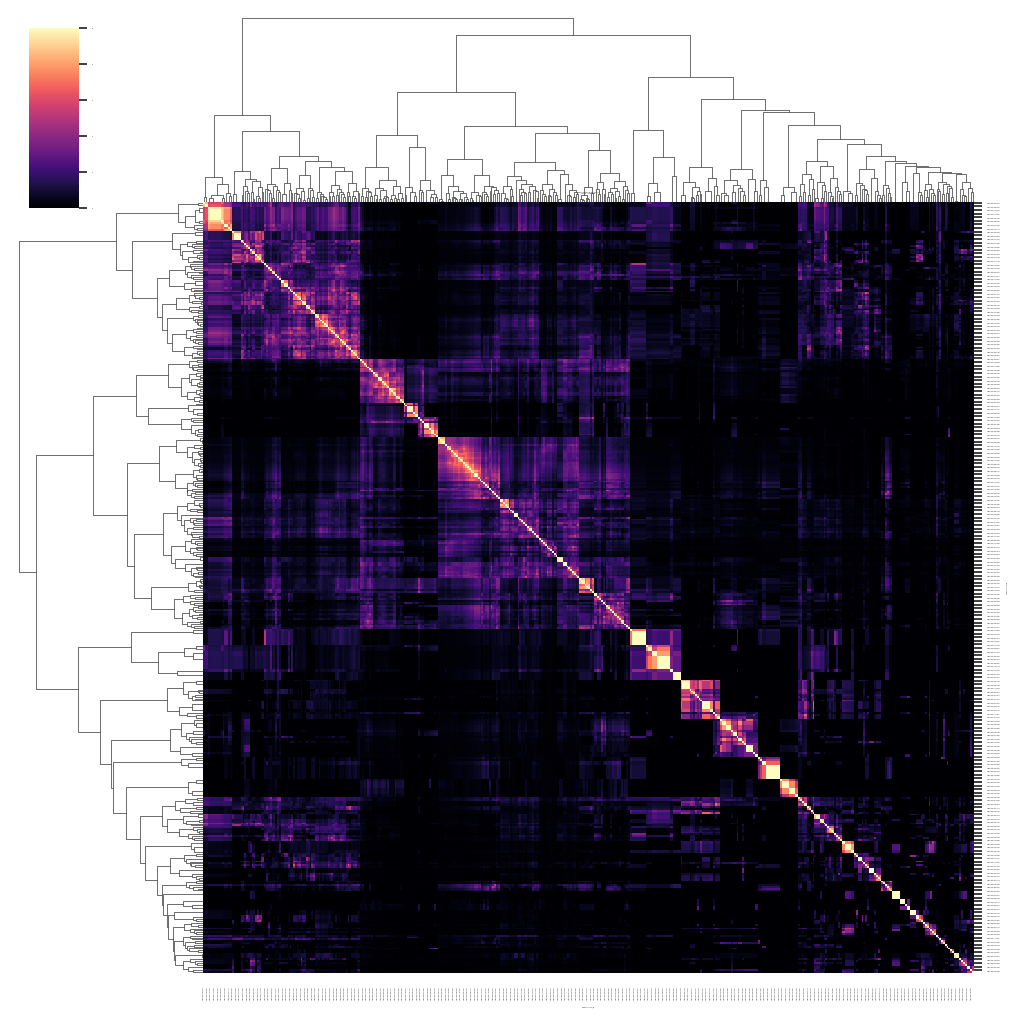

In [3]:
import pandas as pd
import glob, os
import numpy as np
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Load your path‐CSVs
paths_dir = "sensory_to_motor_paths"
files     = glob.glob(os.path.join(paths_dir, "*_paths.csv"))
df        = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# 2) Build a counts matrix: rows = sensory src, cols = motor, value = # of paths
mat_counts = (
    df[df["path_found"]]
      .pivot_table(index="src", columns="motor", aggfunc="size", fill_value=0)
)

# 3) Compute weighted Jaccard similarity between rows:
#    wjac[i,j] = sum_k min(a_ik, a_jk) / sum_k max(a_ik, a_jk)
rows = mat_counts.values
min_mat = np.minimum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
max_mat = np.maximum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
sim_wj = min_mat / max_mat
# avoid divide-by-zero rows (if both zero) => set similarity to 1
sim_wj[np.isnan(sim_wj)] = 1.0

# 4) Compute Ward’s D² linkage on the *distance* matrix (1 − similarity)
dist_wj = 1 - sim_wj
Z       = linkage(dist_wj, method="ward")

# 5) Convert to DataFrame for plotting
sens_ids = mat_counts.index.astype(str)
sim_df   = pd.DataFrame(sim_wj, index=sens_ids, columns=sens_ids)

# 5) Plot a cluster‐map of sensory×sensory similarity
sns.set(font_scale=0.07)
cg = sns.clustermap(
    sim_df,
    row_linkage=Z,
    col_linkage=Z,
    cmap="magma",

    figsize=(10, 10)
)

cg.ax_heatmap.set_xlabel("Sensory src root_id")
cg.ax_heatmap.set_ylabel("Sensory src root_id")
cg.ax_heatmap.set_title("Sensory×Sensory Jaccard Similarity\n(Ward D² clustering) pt")

plt.show()


/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_11456/1025379317.py:34: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_wj    = linkage(dist_wj, method="ward")


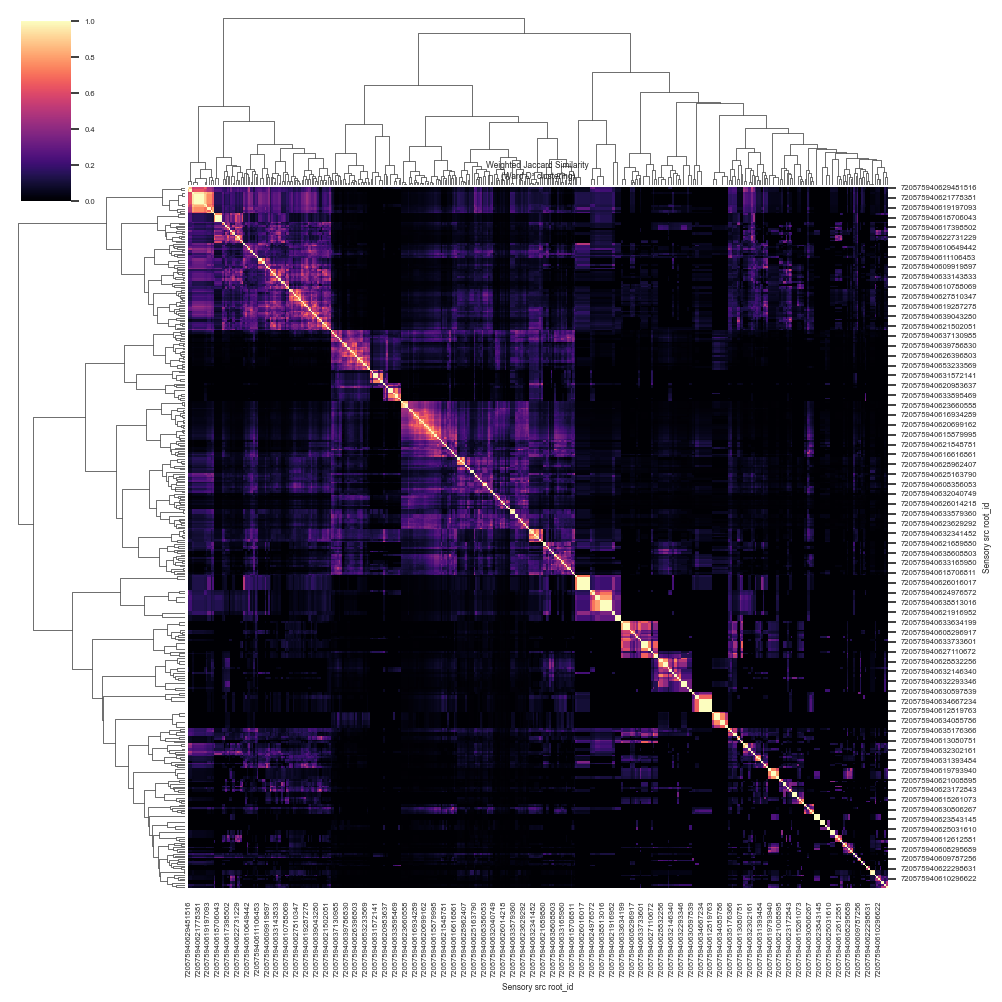

/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_11456/1025379317.py:59: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_cos = linkage(dist_cos, method="ward")


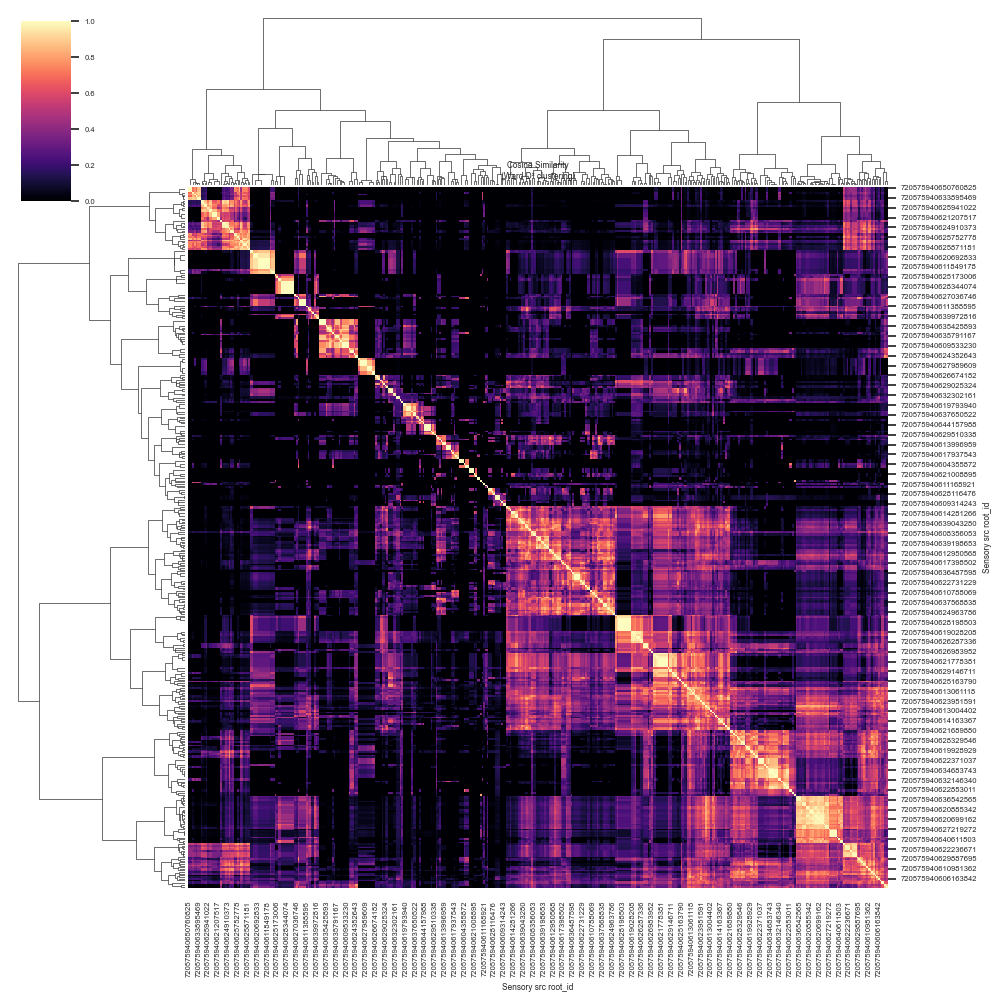

In [4]:
import pandas as pd
import glob, os
import numpy as np
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# 1) Load your path‐CSVs
paths_dir = "sensory_to_motor_paths"
files     = glob.glob(os.path.join(paths_dir, "*_paths.csv"))
df        = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# 2) Build a counts matrix: rows = sensory src, cols = motor, value = # of paths
mat_counts = (
    df[df["path_found"]]
      .pivot_table(index="src", columns="motor", aggfunc="size", fill_value=0)
)

# Convert index to strings for plotting
sens_ids = mat_counts.index.astype(str)

# ─────────────────────────────────────────────────────────────
# A) Weighted Jaccard similarity
# ─────────────────────────────────────────────────────────────
rows = mat_counts.values
min_mat = np.minimum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
max_mat = np.maximum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
sim_wj  = min_mat / max_mat
sim_wj[np.isnan(sim_wj)] = 1.0  # if both rows zero

# Ward’s D² linkage on distance = 1 - similarity
dist_wj = 1 - sim_wj
Z_wj    = linkage(dist_wj, method="ward")

sim_wj_df = pd.DataFrame(sim_wj, index=sens_ids, columns=sens_ids)

sns.set(font_scale=0.5)
cg_wj = sns.clustermap(
    sim_wj_df,
    row_linkage=Z_wj,
    col_linkage=Z_wj,
    cmap="magma",
    figsize=(10, 10)
)
cg_wj.ax_heatmap.set_xlabel("Sensory src root_id")
cg_wj.ax_heatmap.set_ylabel("Sensory src root_id")
cg_wj.ax_heatmap.set_title("Weighted Jaccard Similarity\n(Ward D² clustering)")
plt.show()


# ─────────────────────────────────────────────────────────────
# B) Cosine similarity
# ─────────────────────────────────────────────────────────────
# Compute cosine-distance then similarity
dist_cos = pairwise_distances(rows, metric="cosine")
sim_cos  = 1 - dist_cos

Z_cos = linkage(dist_cos, method="ward")
sim_cos_df = pd.DataFrame(sim_cos, index=sens_ids, columns=sens_ids)

cg_cos = sns.clustermap(
    sim_cos_df,
    row_linkage=Z_cos,
    col_linkage=Z_cos,
    cmap="magma",
    figsize=(10, 10)
)
cg_cos.ax_heatmap.set_xlabel("Sensory src root_id")
cg_cos.ax_heatmap.set_ylabel("Sensory src root_id")
cg_cos.ax_heatmap.set_title("Cosine Similarity\n(Ward D² clustering)")
plt.show()


/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_11456/369114382.py:91: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_wj    = linkage(dist_wj, method="ward")


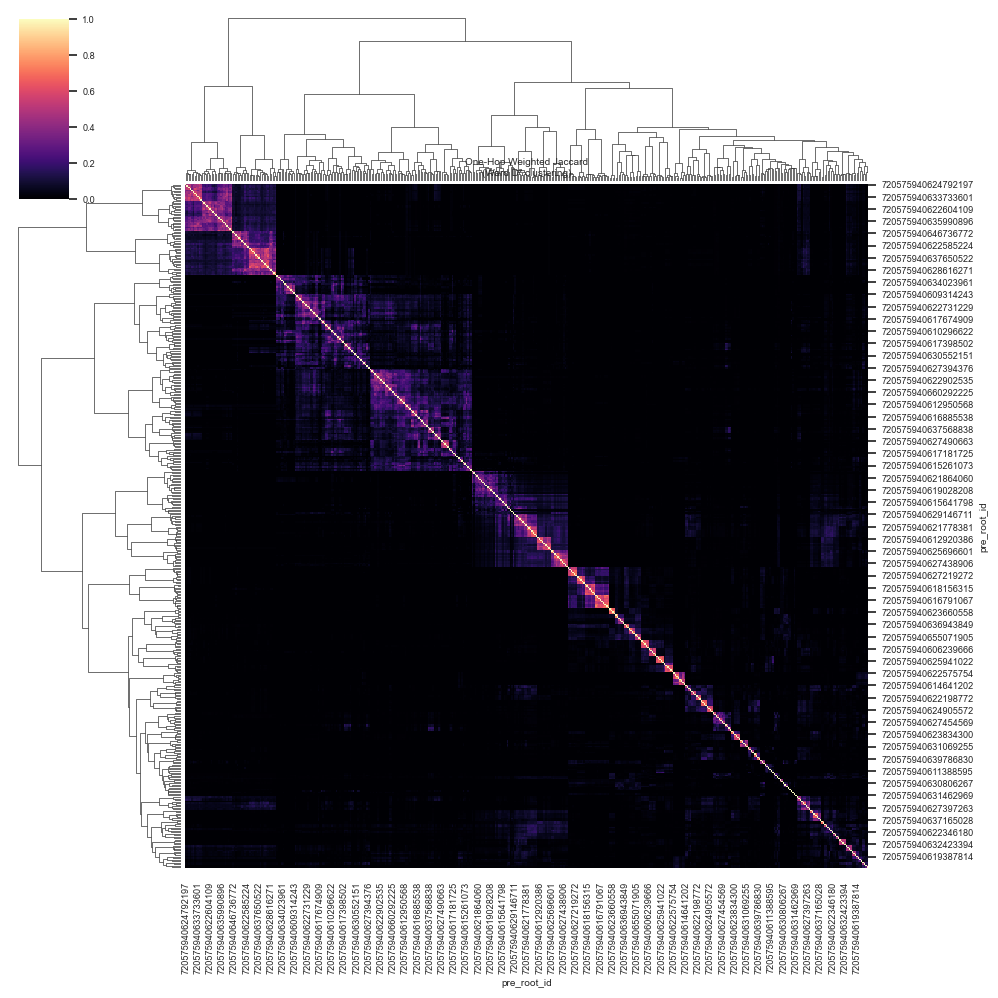

/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_11456/369114382.py:111: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_cos    = linkage(dist_cos, method="ward")


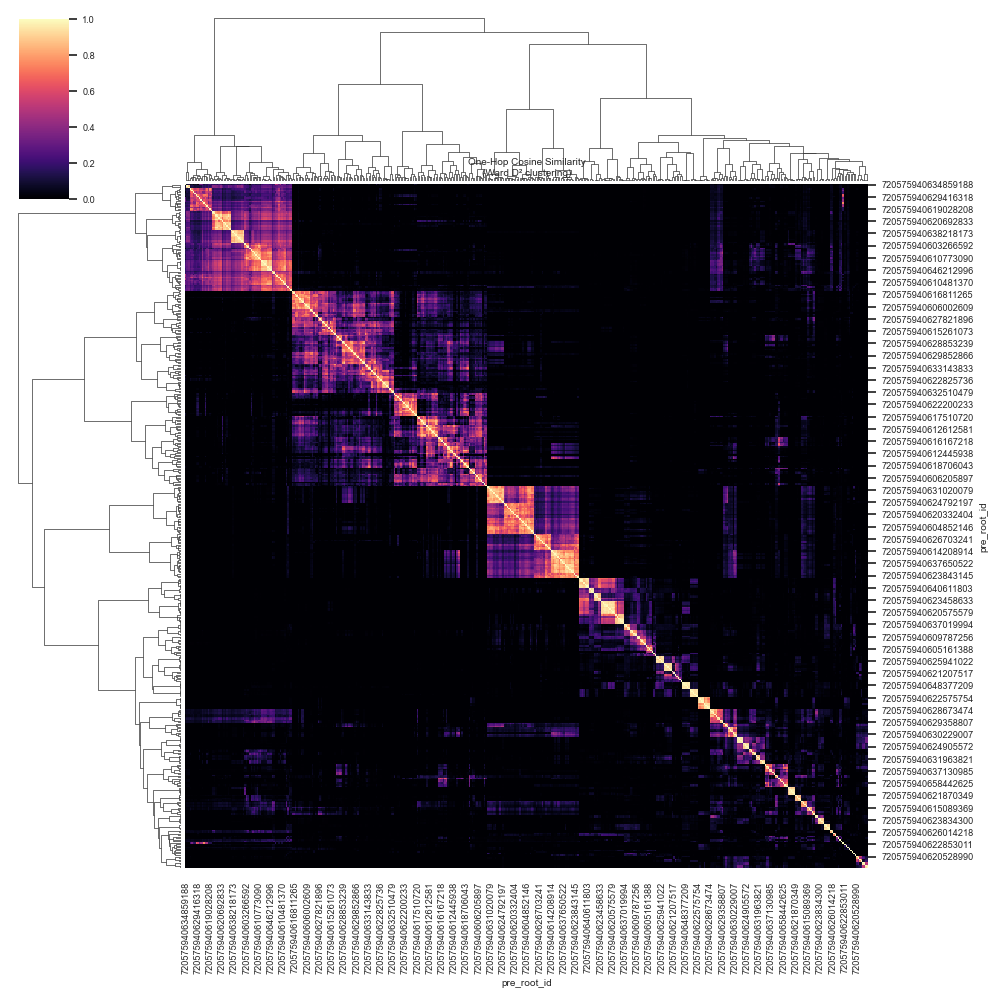

In [6]:
#!/usr/bin/env python3
"""
One-Hop Sensory×Motor Similarity (filtered to your workflows)
"""
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
from sklearn.metrics import pairwise_distances

# ─────────────────────────────────────────────────────────────
# 0) PARAMETERS & PATHS
# ─────────────────────────────────────────────────────────────
CONN_FILE = (
    "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/"
    "YaoLabUF/flywire.ai_data/connections_princeton.csv.gz"
)
MIN_SYN = 5

# workflow set files
STN_DIR   = "/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2"
PSO_DIR   = "/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3"
GRN_FILES = {
    'Sugar/Water': "/Users/yaolab/Downloads/sugar_water_GRNs.csv",
    'Bitter':      "/Users/yaolab/Downloads/bitter_GRNs.csv",
    'Ir94e':       "/Users/yaolab/Downloads/Ir94e_GRNs.csv",
    'Taste Peg':   "/Users/yaolab/Downloads/taste_peg_GRNs.csv",
}

# ─────────────────────────────────────────────────────────────
# 1) LOAD & FILTER ONE-HOP CONNECTIONS
# ─────────────────────────────────────────────────────────────
conns = (
    pd.read_csv(CONN_FILE, usecols=["pre_root_id","post_root_id","syn_count"])
      .groupby(["pre_root_id","post_root_id"], as_index=False)
      .syn_count.sum()
      .query("syn_count >= @MIN_SYN")
)

# ─────────────────────────────────────────────────────────────
# 2) BUILD LIST OF “SENSORY” ROOT_IDS FROM YOUR WORKFLOWS
# ─────────────────────────────────────────────────────────────
# StN-SA_v2
stn = pd.concat([
    pd.read_csv(f"{STN_DIR}/set_{i}.csv")['root_id'].astype(int)
    for i in range(1,7)
])
# PSO-SA
pso = pd.concat([
    pd.read_csv(f"{PSO_DIR}/set_{i}.csv")['root_id'].astype(int)
    for i in range(1,4)
])
# MxLbN GRNs
grn = pd.concat([
    pd.read_csv(path)['root_id'].astype(int)
    for path in GRN_FILES.values()
])

# union all sensors
sensors = pd.Index(stn).union(pso).union(grn)

# ─────────────────────────────────────────────────────────────
# 3) FILTER connections to only those sensory src in your sets
# ─────────────────────────────────────────────────────────────
conns = conns[conns.pre_root_id.isin(sensors)]

# ─────────────────────────────────────────────────────────────
# 4) PIVOT TO DIRECT-COUNTS MATRIX
# ─────────────────────────────────────────────────────────────
mat_counts = conns.pivot_table(
    index="pre_root_id",
    columns="post_root_id",
    values="syn_count",
    aggfunc="sum",
    fill_value=0
)

sens_ids = mat_counts.index.astype(str)
rows    = mat_counts.values

# ─────────────────────────────────────────────────────────────
# 5A) WEIGHTED JACCARD
# ─────────────────────────────────────────────────────────────
min_mat = np.minimum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
max_mat = np.maximum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
sim_wj  = min_mat / max_mat
sim_wj[np.isnan(sim_wj)] = 1.0

dist_wj = 1 - sim_wj
Z_wj    = linkage(dist_wj, method="ward")
sim_wj_df = pd.DataFrame(sim_wj, index=sens_ids, columns=sens_ids)

sns.set(font_scale=0.6)
cg_wj = sns.clustermap(
    sim_wj_df,
    row_linkage=Z_wj,
    col_linkage=Z_wj,
    cmap="magma",
    figsize=(10,10)
)
cg_wj.ax_heatmap.set_title("One-Hop Weighted Jaccard\n(Ward D² clustering)")
plt.show()

# ─────────────────────────────────────────────────────────────
# 5B) COSINE
# ─────────────────────────────────────────────────────────────
dist_cos = pairwise_distances(rows, metric="cosine")
sim_cos  = 1 - dist_cos

Z_cos    = linkage(dist_cos, method="ward")
sim_cos_df = pd.DataFrame(sim_cos, index=sens_ids, columns=sens_ids)

cg_cos = sns.clustermap(
    sim_cos_df,
    row_linkage=Z_cos,
    col_linkage=Z_cos,
    cmap="magma",
    figsize=(10,10)
)
cg_cos.ax_heatmap.set_title("One-Hop Cosine Similarity\n(Ward D² clustering)")
plt.show()


/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_11456/1825360047.py:17: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


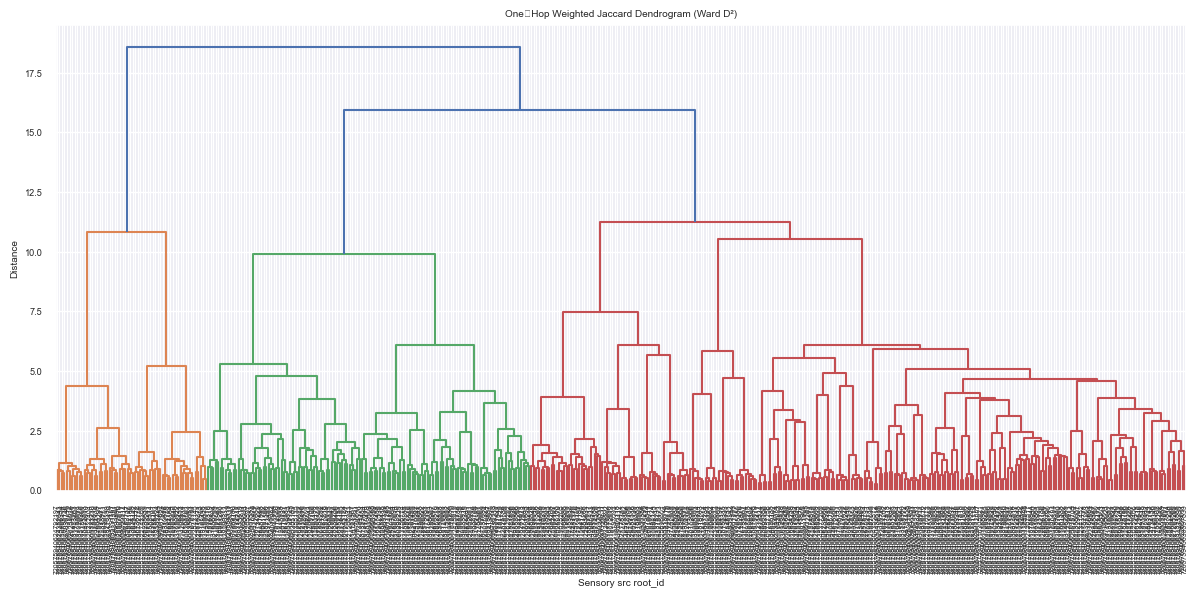

/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_11456/1825360047.py:34: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


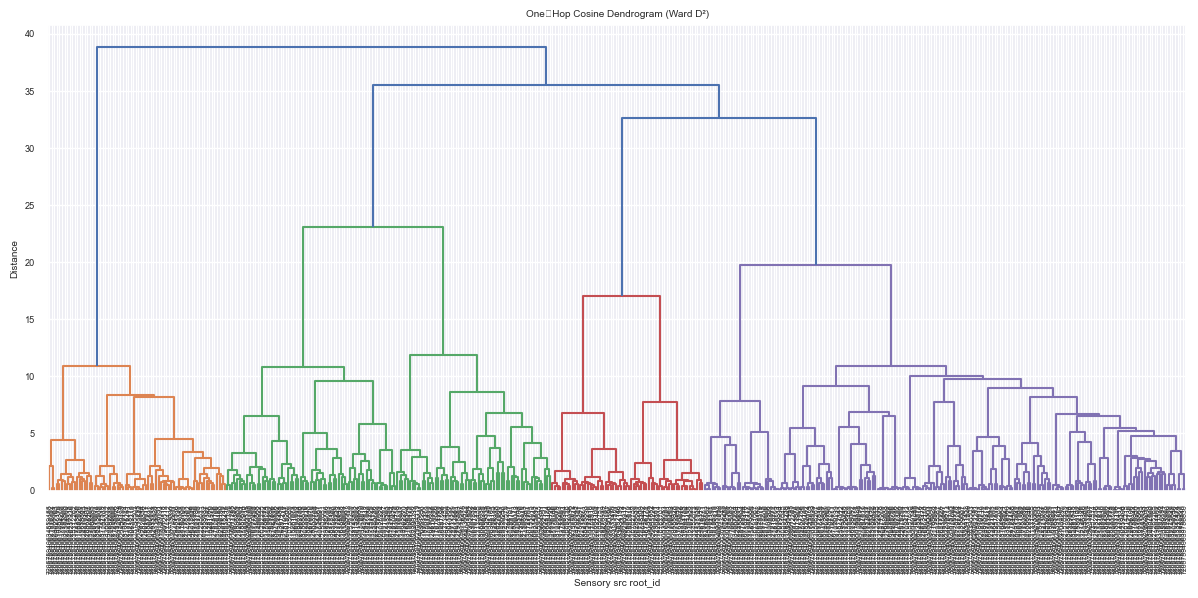

In [7]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# ─────────────────────────────────────────────────────────────
# Weighted Jaccard Dendrogram
# ─────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 6))
dendrogram(
    Z_wj,
    labels=sens_ids,
    leaf_rotation=90,  # rotate labels so they don’t overlap
    color_threshold=None
)
plt.title("One‐Hop Weighted Jaccard Dendrogram (Ward D²)")
plt.xlabel("Sensory src root_id")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────────────────────
# Cosine Dendrogram
# ─────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 6))
dendrogram(
    Z_cos,
    labels=sens_ids,
    leaf_rotation=90,
    color_threshold=None
)
plt.title("One‐Hop Cosine Dendrogram (Ward D²)")
plt.xlabel("Sensory src root_id")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_11717/653982027.py:85: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_wj    = linkage(1 - sim_wj, method="ward")
/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_11717/653982027.py:90: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_cos = linkage(pairwise_distances(rows, metric="cosine"), method="ward")
/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_11717/653982027.py:125: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


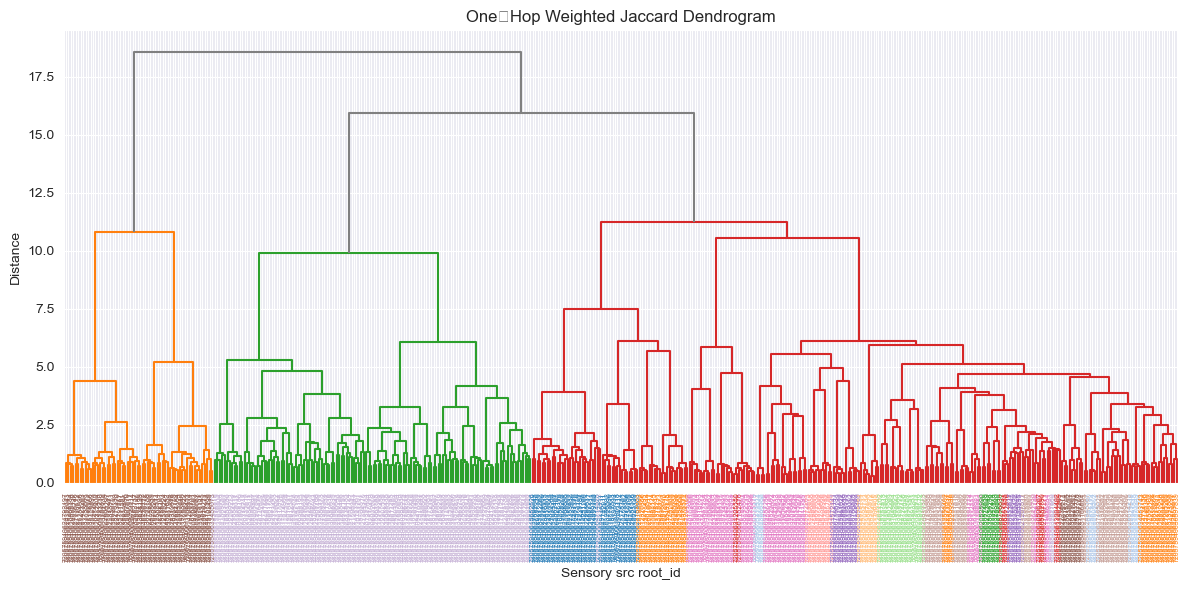

/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_11717/653982027.py:125: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


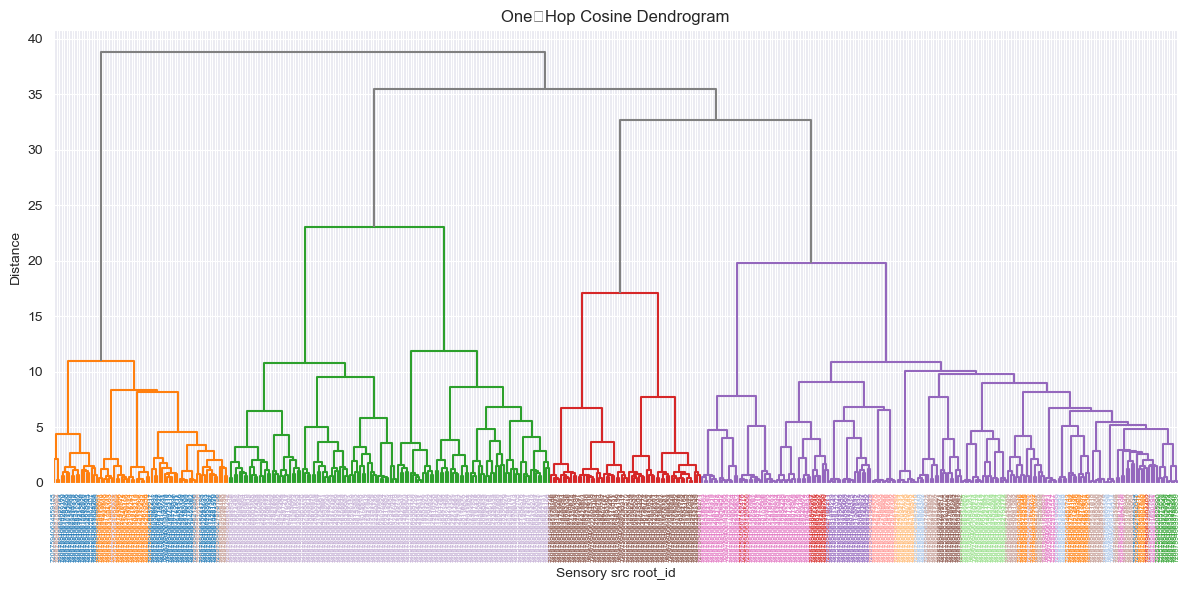

In [1]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import pairwise_distances

# ─────────────────────────────────────────────────────────────
# PARAMETERS & PATHS
# ─────────────────────────────────────────────────────────────
CONN_FILE = (
    "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/"
    "YaoLabUF/flywire.ai_data/connections_princeton.csv.gz"
)
MIN_SYN = 5

STN_DIR = "/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2"
PSO_DIR = "/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3"
GRN_FILES = {
    'Sugar/Water': "/Users/yaolab/Downloads/sugar_water_GRNs.csv",
    'Bitter':      "/Users/yaolab/Downloads/bitter_GRNs.csv",
    'Ir94e':       "/Users/yaolab/Downloads/Ir94e_GRNs.csv",
    'Taste Peg':   "/Users/yaolab/Downloads/taste_peg_GRNs.csv",
}

# ─────────────────────────────────────────────────────────────
# 1) Load & threshold one‐hop connections
# ─────────────────────────────────────────────────────────────
conns = (
    pd.read_csv(CONN_FILE, usecols=["pre_root_id","post_root_id","syn_count"])
      .groupby(["pre_root_id","post_root_id"], as_index=False)
      .syn_count.sum()
      .query("syn_count >= @MIN_SYN")
)

# ─────────────────────────────────────────────────────────────
# 2) Build your sensory‐neuron list
# ─────────────────────────────────────────────────────────────
# StN-SA_v2 sets 1–6
stn = pd.concat([
    pd.read_csv(f"{STN_DIR}/set_{i}.csv")['root_id'].astype(int)
    for i in range(1,7)
])
# PSO-SA: DCSO, aPhN1, aPhN2
pso = pd.concat([
    pd.read_csv(f"{PSO_DIR}/set_{i}.csv")['root_id'].astype(int)
    for i in range(1,4)
])
# MxLbN GRNs
grn = pd.concat([
    pd.read_csv(path)['root_id'].astype(int)
    for path in GRN_FILES.values()
])

# union all sensors
sensors = pd.Index(stn).union(pso).union(grn)

# ─────────────────────────────────────────────────────────────
# 3) FILTER connections to just those sensory srcs
# ─────────────────────────────────────────────────────────────
conns = conns[conns.pre_root_id.isin(sensors)]

# ─────────────────────────────────────────────────────────────
# 4) Pivot to direct‐counts matrix (rows=sensors, cols=motor)
# ─────────────────────────────────────────────────────────────
mat = conns.pivot_table(
    index="pre_root_id",
    columns="post_root_id",
    values="syn_count",
    aggfunc="sum",
    fill_value=0
)

sens_ids = mat.index.astype(str)
rows     = mat.values

# ─────────────────────────────────────────────────────────────
# 5A) Weighted Jaccard dendrogram
# ─────────────────────────────────────────────────────────────
min_mat = np.minimum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
max_mat = np.maximum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
sim_wj  = min_mat / max_mat
sim_wj[np.isnan(sim_wj)] = 1.0
Z_wj    = linkage(1 - sim_wj, method="ward")

# ─────────────────────────────────────────────────────────────
# 5B) Cosine dendrogram
# ─────────────────────────────────────────────────────────────
Z_cos = linkage(pairwise_distances(rows, metric="cosine"), method="ward")

# ─────────────────────────────────────────────────────────────
# 6) Build leaf‐color map
# ─────────────────────────────────────────────────────────────
group_map = {}
# StN
for i in range(1,7):
    for rid in pd.read_csv(f"{STN_DIR}/set_{i}.csv")['root_id'].astype(str):
        group_map[rid] = f"StN {i}"
# PSO
psos = {'DCSO': 'set_1.csv','aPhN1':'set_2.csv','aPhN2':'set_3.csv'}
for name,f in psos.items():
    for rid in pd.read_csv(f"{PSO_DIR}/{f}")['root_id'].astype(str):
        group_map[rid] = name
# GRN
for name,path in GRN_FILES.items():
    for rid in pd.read_csv(path)['root_id'].astype(str):
        group_map[rid] = name

groups = sorted(set(group_map.values()))
palette = sns.color_palette("tab20", n_colors=len(groups))
color_map = dict(zip(groups, palette))

def plot_dendo(Z, title):
    plt.figure(figsize=(12,6))
    dn = dendrogram(Z, labels=sens_ids, leaf_rotation=90, color_threshold=None, above_threshold_color='grey')
    ax = plt.gca()
    for lbl in ax.get_xmajorticklabels():
        rid = lbl.get_text()
        if rid in group_map:
            lbl.set_color(color_map[group_map[rid]])
    plt.title(title)
    plt.xlabel("Sensory src root_id")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

plot_dendo(Z_wj, "One‐Hop Weighted Jaccard Dendrogram")
plot_dendo(Z_cos, "One‐Hop Cosine Dendrogram")


Saved one_hop_weighted_jaccard_dendrogram.pdf


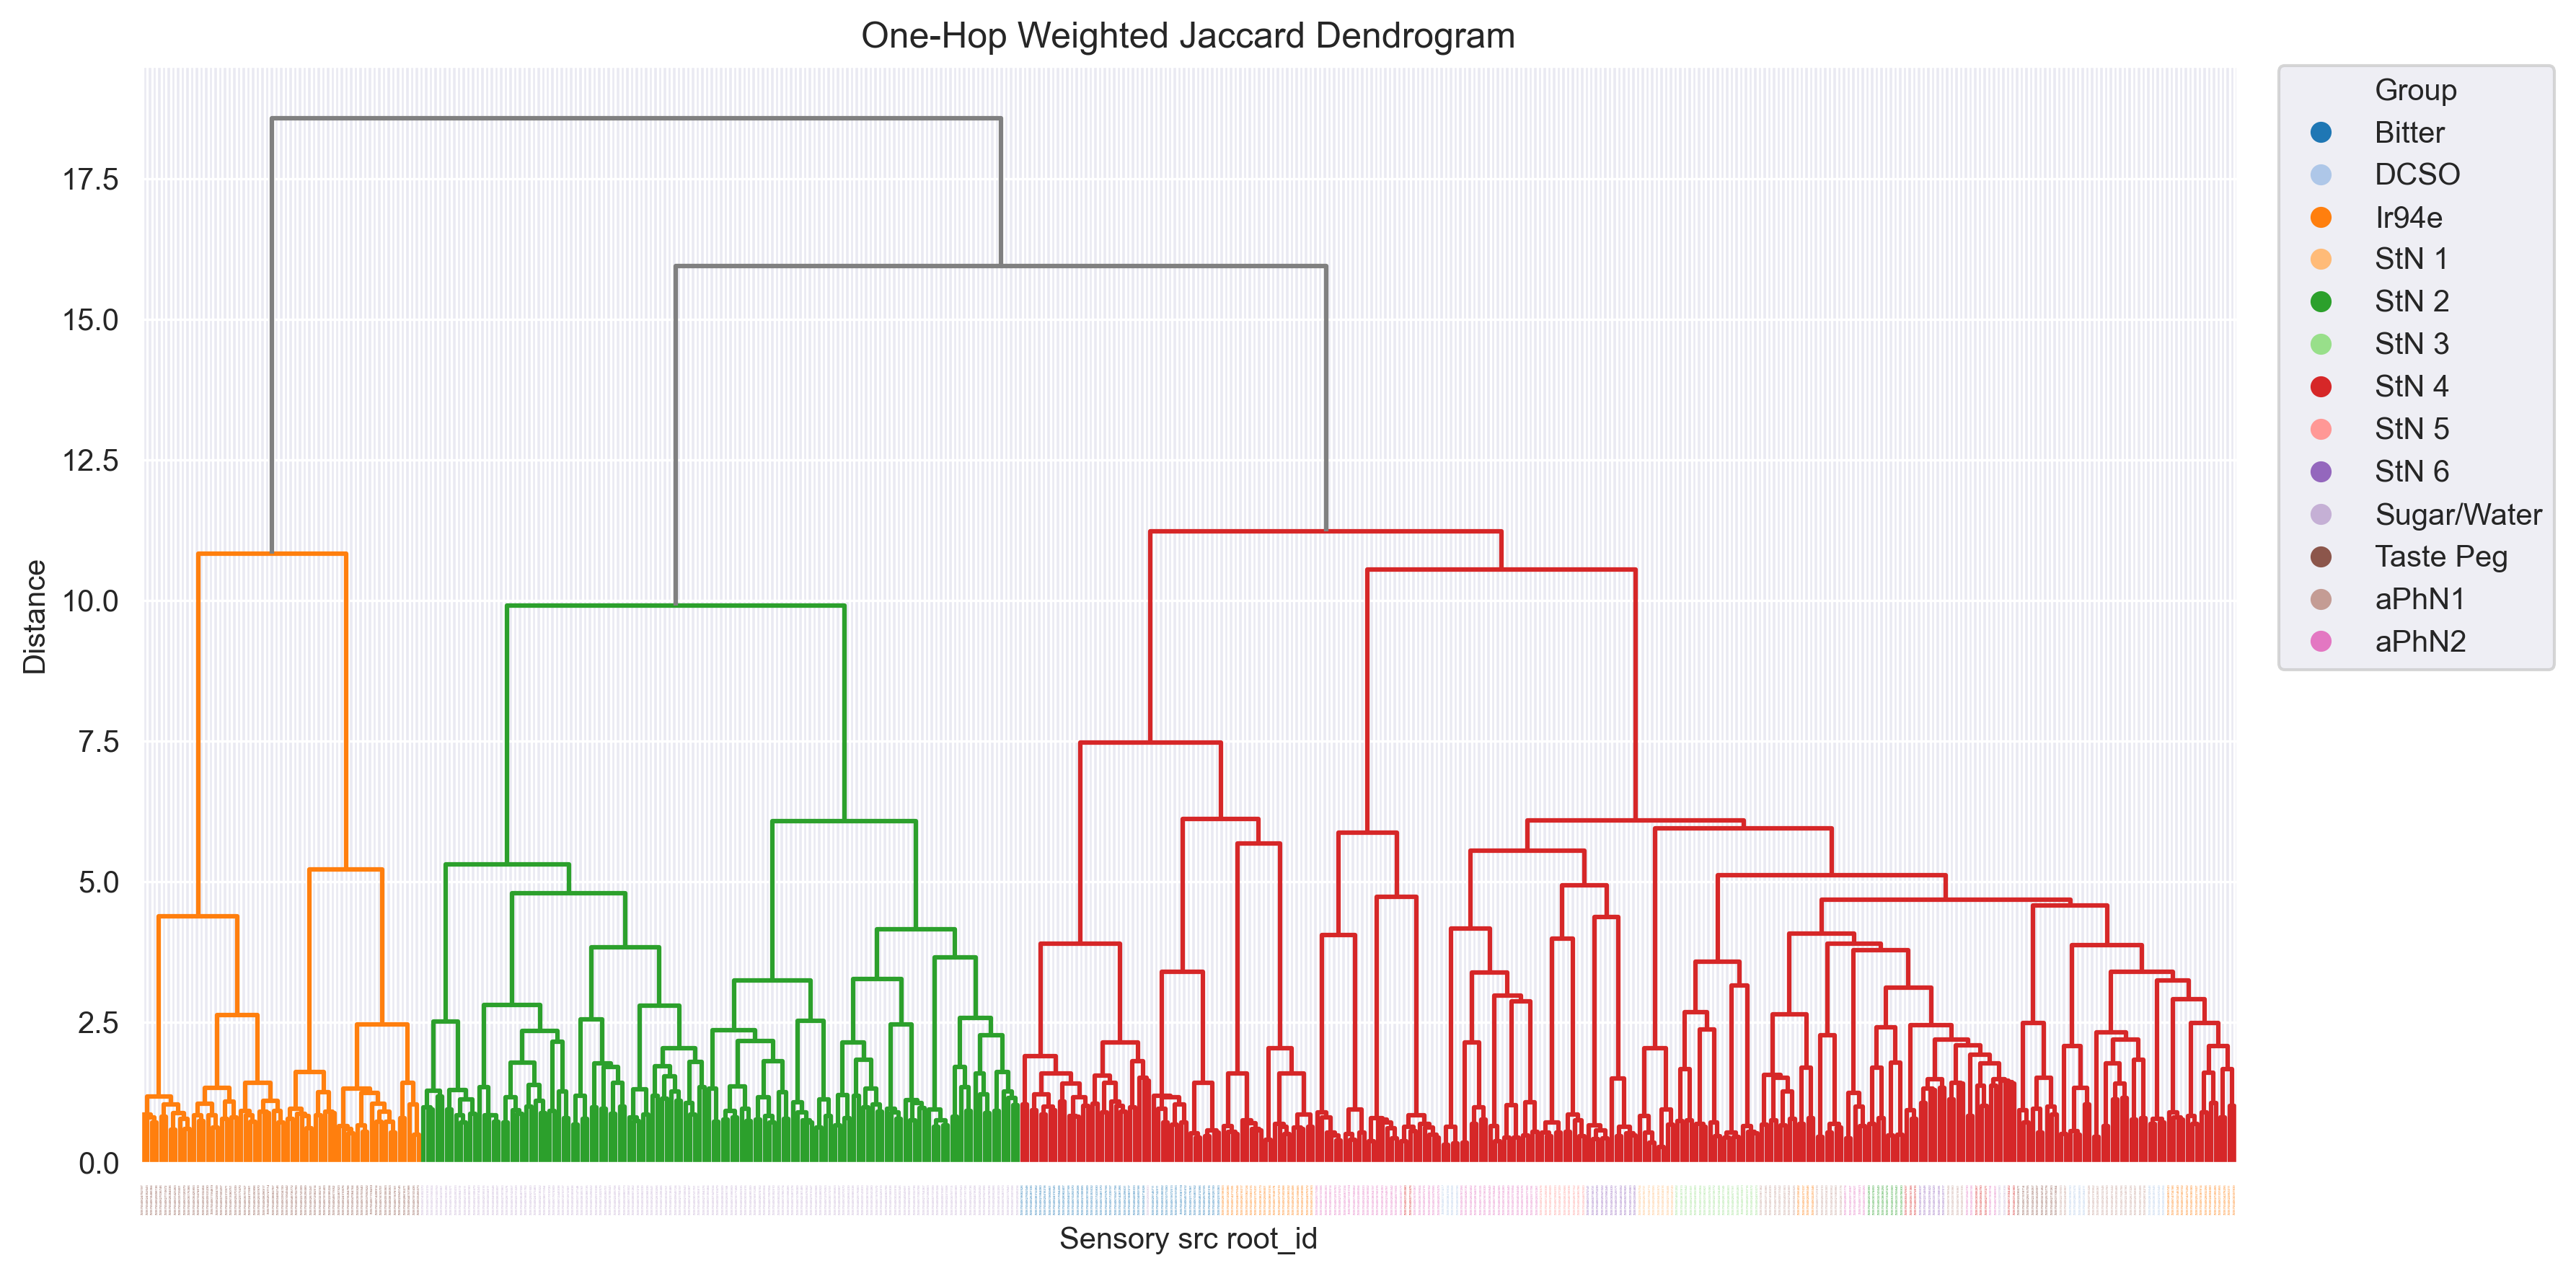

Saved one_hop_cosine_dendrogram.pdf


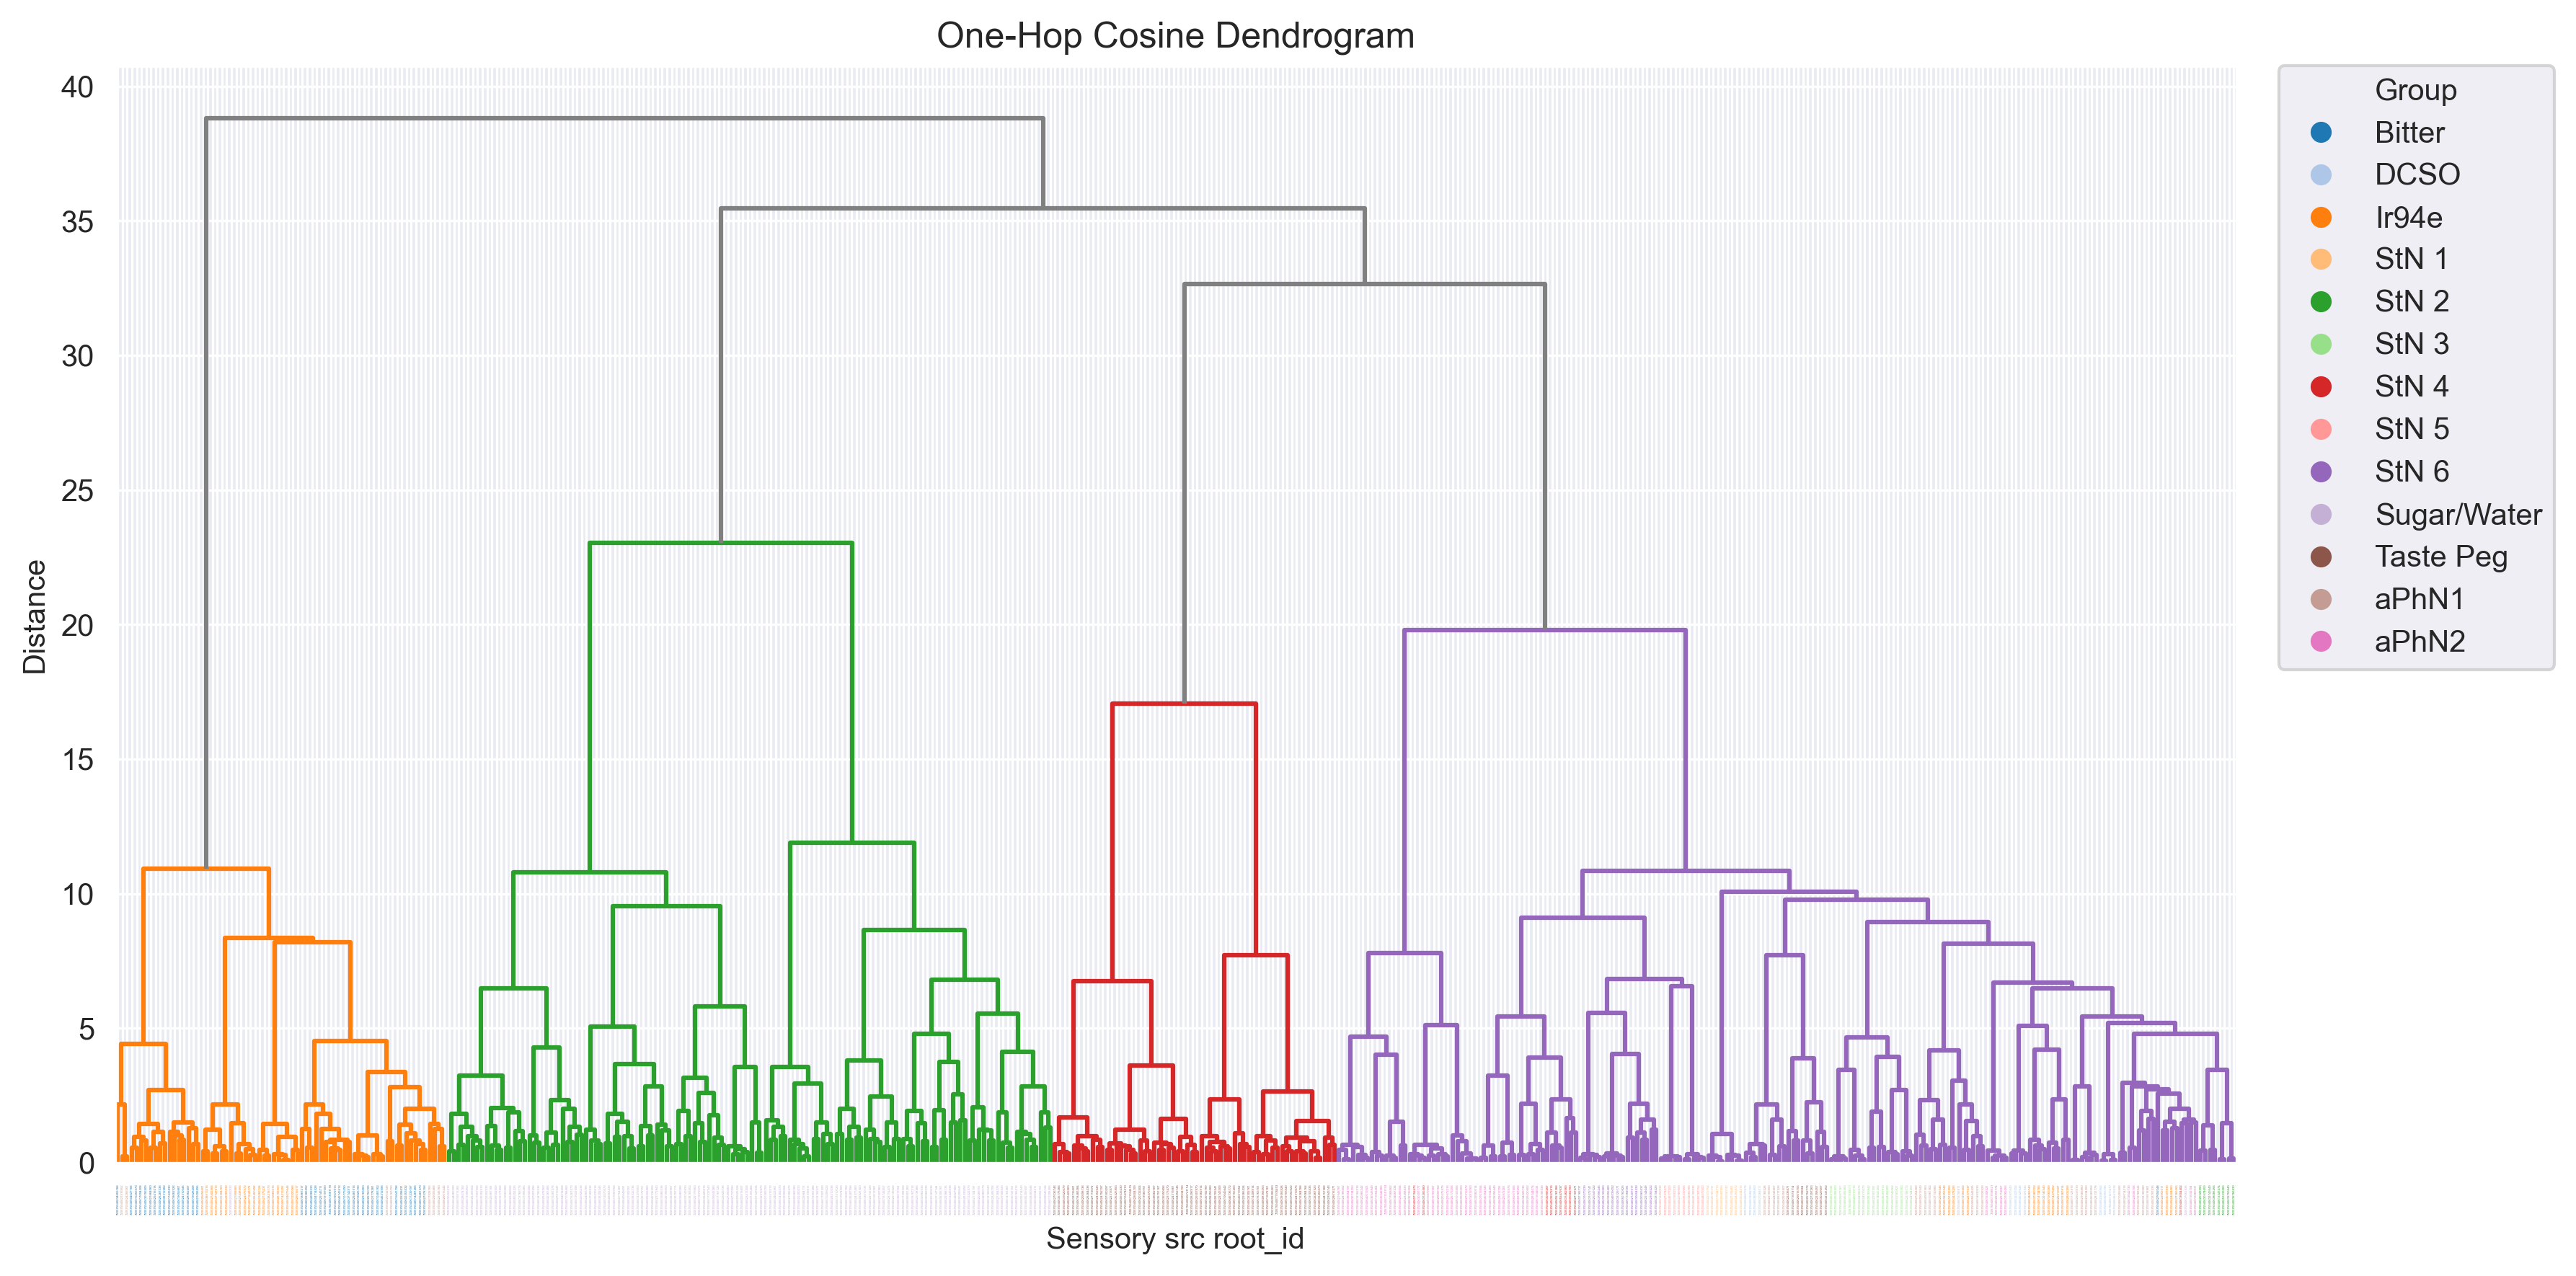

In [11]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import pairwise_distances

# … (load + filter conns, build mat, compute Z_wj, Z_cos, build group_map, color_map) …

DPI = 300
LEAF_FONTSIZE = 1
AXIS_FONTSIZE = 10

def sanitize(fn: str) -> str:
    return re.sub(r"[^0-9A-Za-z]+", "_", fn).strip("_").lower()

def plot_and_save_dendrogram(Z, title):
    fname = sanitize(title) + ".pdf"
    fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)
    dn = dendrogram(
        Z,
        labels=sens_ids,
        leaf_rotation=90,
        leaf_font_size=LEAF_FONTSIZE,
        color_threshold=None,
        above_threshold_color='grey',
        ax=ax
    )
    # recolor leaf labels
    for lbl in ax.get_xmajorticklabels():
        rid = lbl.get_text()
        grp = group_map.get(rid)
        if grp:
            lbl.set_color(color_map[grp])

    # legend
    handles = [
        plt.Line2D([0], [0],
                   marker='o', linestyle='',
                   markersize=6,
                   color=color_map[grp],
                   label=grp)
        for grp in groups
    ]
    ax.legend(
        handles=handles,
        title="Group",
        title_fontsize=AXIS_FONTSIZE,
        fontsize=AXIS_FONTSIZE,
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        borderaxespad=0.0
    )

    ax.set_title(title, fontsize=AXIS_FONTSIZE+2)
    ax.set_xlabel("Sensory src root_id", fontsize=AXIS_FONTSIZE)
    ax.set_ylabel("Distance", fontsize=AXIS_FONTSIZE)
    ax.tick_params(axis='x', labelsize=LEAF_FONTSIZE)
    ax.tick_params(axis='y', labelsize=AXIS_FONTSIZE)
    plt.tight_layout()

    # save as vector PDF
    fig.savefig(fname, format='pdf', dpi=DPI, bbox_inches='tight')
    print(f"Saved {fname}")
    plt.show()


# generate & save
plot_and_save_dendrogram(Z_wj, "One-Hop Weighted Jaccard Dendrogram")
plot_and_save_dendrogram(Z_cos, "One-Hop Cosine Dendrogram")


/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_11717/2249330559.py:80: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_wj    = linkage(1 - sim_wj, method="ward")
/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_11717/2249330559.py:83: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_cos   = linkage(pairwise_distances(rows, metric="cosine"), method="ward")


Saved one_hop_weighted_jaccard_dendrogram.pdf


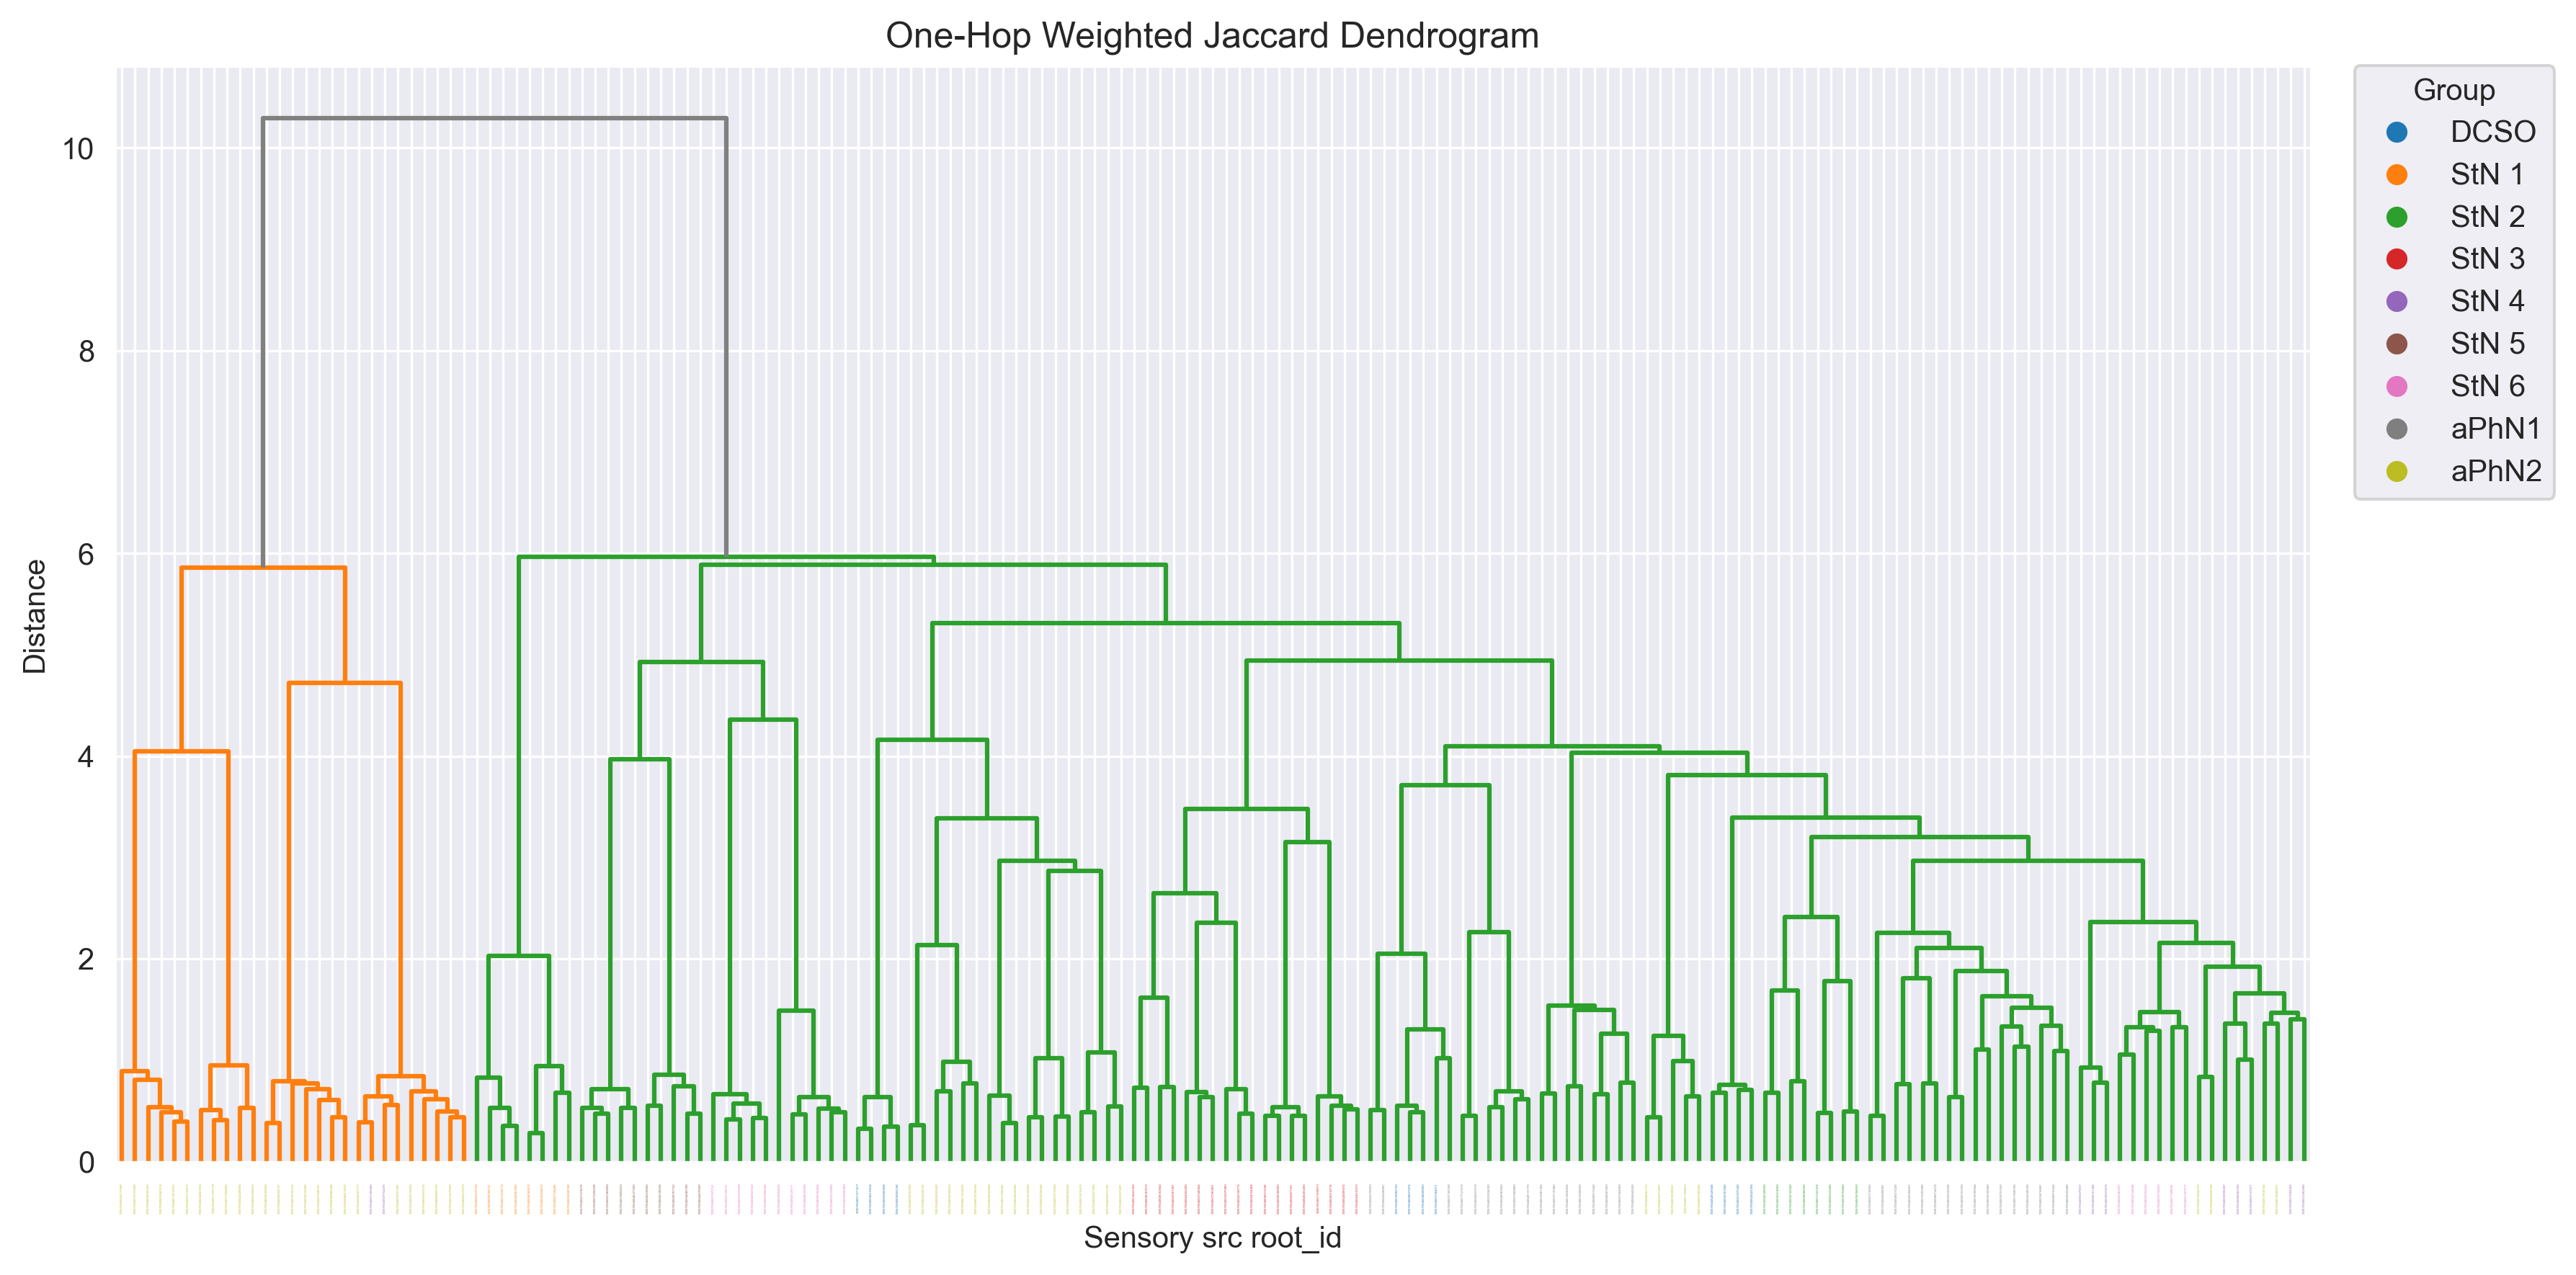

Saved one_hop_cosine_dendrogram.pdf


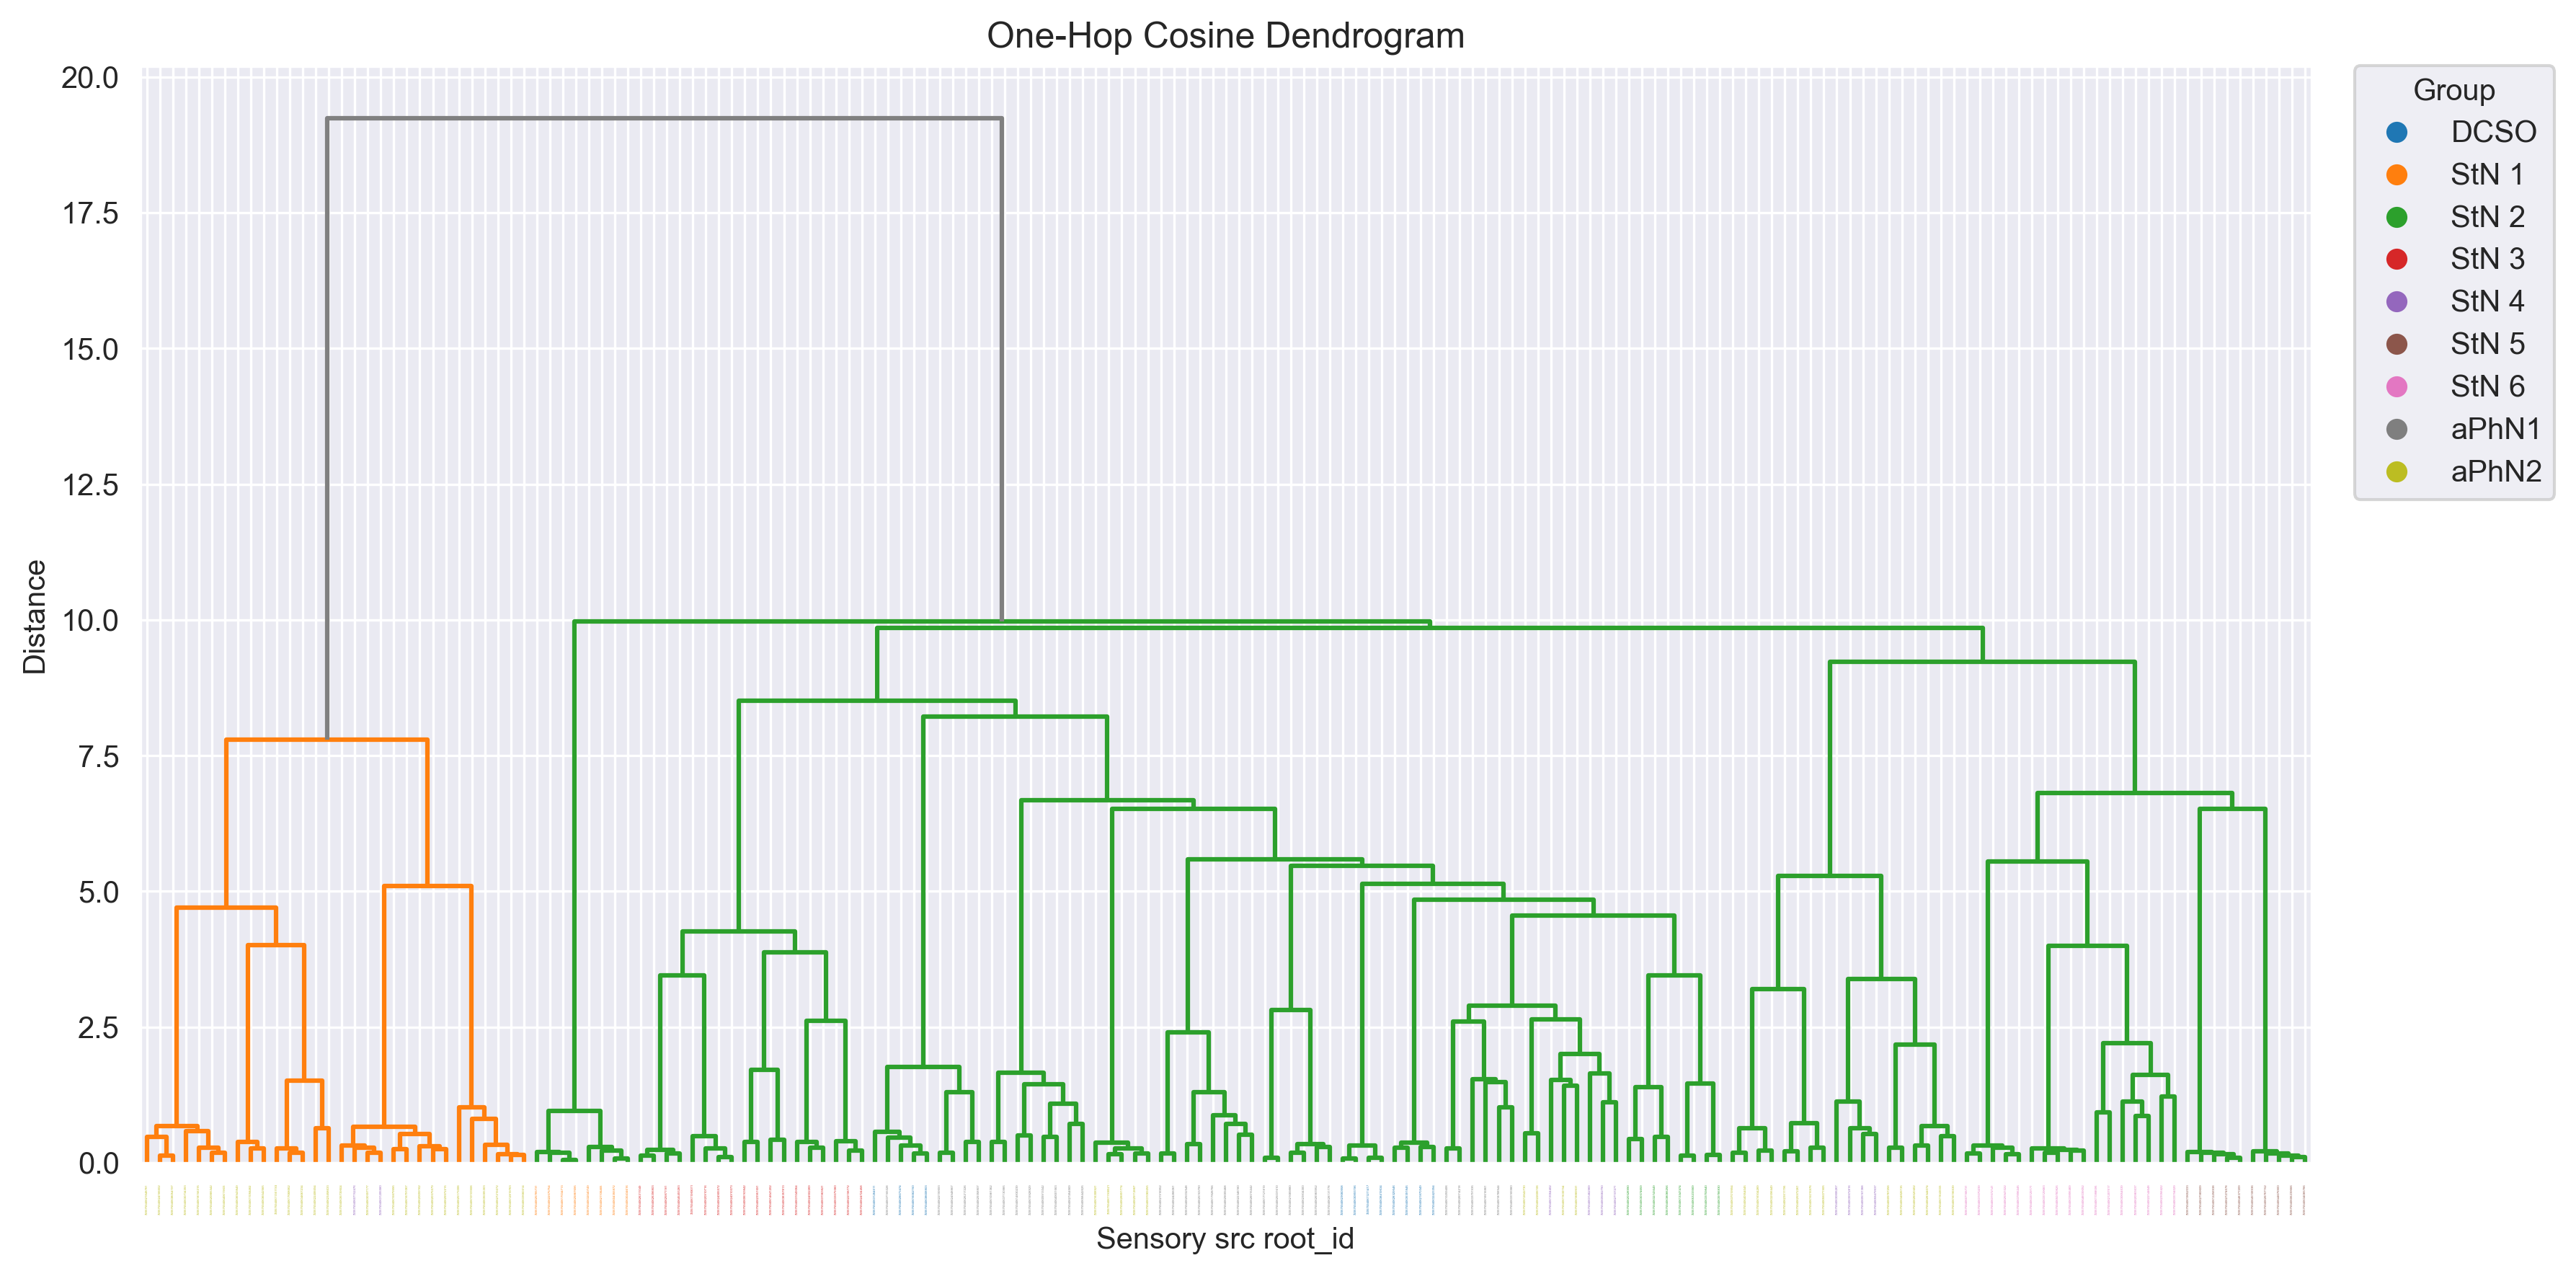

In [12]:
#!/usr/bin/env python3
"""
One‐Hop Sensory×Motor Dendrograms (StN‐SA + PSO‐SA only)

Saves two PDF dendrograms with leaf colors & legend, excluding MxLbN GRNs.
"""
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import pairwise_distances

# ─────────────────────────────────────────────────────────────
# PARAMETERS & PATHS
# ─────────────────────────────────────────────────────────────
CONN_FILE = (
    "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/"
    "YaoLabUF/flywire.ai_data/connections_princeton.csv.gz"
)
MIN_SYN = 5

STN_DIR = "/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2"
PSO_DIR = "/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3"

# ─────────────────────────────────────────────────────────────
# 1) Load & threshold one‐hop connections
# ─────────────────────────────────────────────────────────────
conns = (
    pd.read_csv(CONN_FILE, usecols=["pre_root_id","post_root_id","syn_count"])
      .groupby(["pre_root_id","post_root_id"], as_index=False)
      .syn_count.sum()
      .query("syn_count >= @MIN_SYN")
)

# ─────────────────────────────────────────────────────────────
# 2) Build sensory‐neuron list (StN-SA + PSO-SA only)
# ─────────────────────────────────────────────────────────────
# StN-SA_v2 sets 1–6
stn = pd.concat([
    pd.read_csv(f"{STN_DIR}/set_{i}.csv")['root_id'].astype(int)
    for i in range(1,7)
])
# PSO-SA: DCSO, aPhN1, aPhN2
pso = pd.concat([
    pd.read_csv(f"{PSO_DIR}/set_{i}.csv")['root_id'].astype(int)
    for i in range(1,4)
])

# union all sensory srcs
sensors = pd.Index(stn).union(pso)

# ─────────────────────────────────────────────────────────────
# 3) Filter connections to just those sensory srcs
# ─────────────────────────────────────────────────────────────
conns = conns[conns.pre_root_id.isin(sensors)]

# ─────────────────────────────────────────────────────────────
# 4) Pivot to direct‐counts matrix (rows=sensors, cols=motors)
# ─────────────────────────────────────────────────────────────
mat = conns.pivot_table(
    index="pre_root_id",
    columns="post_root_id",
    values="syn_count",
    aggfunc="sum",
    fill_value=0
)
sens_ids = mat.index.astype(str)
rows     = mat.values

# ─────────────────────────────────────────────────────────────
# 5) Compute linkages
# ─────────────────────────────────────────────────────────────
# Weighted Jaccard
min_mat = np.minimum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
max_mat = np.maximum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
sim_wj  = min_mat / max_mat
sim_wj[np.isnan(sim_wj)] = 1.0
Z_wj    = linkage(1 - sim_wj, method="ward")

# Cosine
Z_cos   = linkage(pairwise_distances(rows, metric="cosine"), method="ward")

# ─────────────────────────────────────────────────────────────
# 6) Build group→color mapping
# ─────────────────────────────────────────────────────────────
group_map = {}

# StN-SA sets
for i in range(1,7):
    label = f"StN {i}"
    for rid in pd.read_csv(f"{STN_DIR}/set_{i}.csv")['root_id'].astype(str):
        group_map[rid] = label

# PSO-SA sets
psos = {'DCSO': 'set_1.csv', 'aPhN1': 'set_2.csv', 'aPhN2': 'set_3.csv'}
for name, fname in psos.items():
    for rid in pd.read_csv(f"{PSO_DIR}/{fname}")['root_id'].astype(str):
        group_map[rid] = name

groups = sorted(set(group_map.values()))
palette = sns.color_palette("tab10", n_colors=len(groups))
color_map = dict(zip(groups, palette))

# ─────────────────────────────────────────────────────────────
# 7) Plot & save PDF dendrograms
# ─────────────────────────────────────────────────────────────
DPI = 300
LEAF_FONTSIZE = 1
AXIS_FONTSIZE = 10

def sanitize(text):
    return re.sub(r'[^0-9A-Za-z]+','_', text).strip('_').lower()

def plot_and_save(Z, title):
    fname = sanitize(title) + ".pdf"
    fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)
    dend = dendrogram(
        Z,
        labels=sens_ids,
        leaf_rotation=90,
        leaf_font_size=LEAF_FONTSIZE,
        color_threshold=None,
        above_threshold_color='grey',
        ax=ax
    )
    # recolor leaves
    for lbl in ax.get_xmajorticklabels():
        rid = lbl.get_text()
        if rid in group_map:
            lbl.set_color(color_map[group_map[rid]])

    # legend
    handles = [
        plt.Line2D([0],[0], marker='o', linestyle='', markersize=6,
                   color=color_map[grp], label=grp)
        for grp in groups
    ]
    ax.legend(handles=handles,
              title="Group",
              title_fontsize=AXIS_FONTSIZE,
              fontsize=AXIS_FONTSIZE,
              bbox_to_anchor=(1.02,1),
              loc='upper left',
              borderaxespad=0.0)

    ax.set_title(title, fontsize=AXIS_FONTSIZE+2)
    ax.set_xlabel("Sensory src root_id", fontsize=AXIS_FONTSIZE)
    ax.set_ylabel("Distance", fontsize=AXIS_FONTSIZE)
    ax.tick_params(axis='x', labelsize=LEAF_FONTSIZE)
    ax.tick_params(axis='y', labelsize=AXIS_FONTSIZE)

    plt.tight_layout()
    fig.savefig(fname, format='pdf', bbox_inches='tight')
    print(f"Saved {fname}")
    plt.show()

plot_and_save(Z_wj, "One-Hop Weighted Jaccard Dendrogram")
plot_and_save(Z_cos, "One-Hop Cosine Dendrogram")


In [37]:
#!/usr/bin/env python3
"""
One‐Hop Sensory Clustermaps with Root IDs & Group Color Bars
(StN‐SA + PSO‐SA only; saves vector PDFs with selectable leaf labels)
"""
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# ─────────────────────────────────────────────────────────────
# PARAMETERS & PATHS
# ─────────────────────────────────────────────────────────────
CONN_FILE = (
    "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/"
    "YaoLabUF/flywire.ai_data/connections_princeton.csv.gz"
)
MIN_SYN = 5
STN_DIR = "/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2"
PSO_DIR = "/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3"

DPI = 300
LEAF_FONTSIZE = 4
AXIS_FONTSIZE = 10

# ─────────────────────────────────────────────────────────────
# 1) Load & threshold one‐hop connections
# ─────────────────────────────────────────────────────────────
conns = (
    pd.read_csv(CONN_FILE, usecols=["pre_root_id","post_root_id","syn_count"])
      .groupby(["pre_root_id","post_root_id"], as_index=False)
      .syn_count.sum()
      .query("syn_count >= @MIN_SYN")
)

# ─────────────────────────────────────────────────────────────
# 2) Build sensory‐neuron list (StN‐SA + PSO‐SA only)
# ─────────────────────────────────────────────────────────────
stn = pd.concat([
    pd.read_csv(f"{STN_DIR}/set_{i}.csv")['root_id'].astype(int)
    for i in range(1,7)
])
pso = pd.concat([
    pd.read_csv(f"{PSO_DIR}/set_{i}.csv")['root_id'].astype(int)
    for i in range(1,4)
])
sensors = pd.Index(stn).union(pso)

# ─────────────────────────────────────────────────────────────
# 3) Filter & pivot to direct‐counts matrix
# ─────────────────────────────────────────────────────────────
conns = conns[conns.pre_root_id.isin(sensors)]
mat = conns.pivot_table(
    index="pre_root_id",
    columns="post_root_id",
    values="syn_count",
    aggfunc="sum",
    fill_value=0
)
sens_ids = mat.index.astype(str)
rows     = mat.values

# ─────────────────────────────────────────────────────────────
# 4) Compute similarity matrices
# ─────────────────────────────────────────────────────────────
# Weighted Jaccard
min_mat = np.minimum(rows[:,None,:], rows[None,:,:]).sum(axis=2)
max_mat = np.maximum(rows[:,None,:], rows[None,:,:]).sum(axis=2)
sim_wj  = pd.DataFrame(min_mat / max_mat, index=sens_ids, columns=sens_ids).fillna(1.0)

# Cosine
dist_cos = pairwise_distances(rows, metric="cosine")
sim_cos  = pd.DataFrame(1 - dist_cos, index=sens_ids, columns=sens_ids)

# ─────────────────────────────────────────────────────────────
# 5) Build group→color mapping
# ─────────────────────────────────────────────────────────────
group_map = {}
for i in range(1,7):
    for rid in pd.read_csv(f"{STN_DIR}/set_{i}.csv")['root_id'].astype(str):
        group_map[rid] = f"StN {i}"
psos = {'DCSO':'set_1.csv','aPhN1':'set_2.csv','aPhN2':'set_3.csv'}
for name, fname in psos.items():
    for rid in pd.read_csv(f"{PSO_DIR}/{fname}")['root_id'].astype(str):
        group_map[rid] = name

groups = sorted(set(group_map.values()))
palette = sns.color_palette("tab10", n_colors=len(groups))
color_map = dict(zip(groups, palette))

# row_colors: list of colors per sensory neuron
row_colors = [color_map[group_map[rid]] for rid in sens_ids]

def sanitize(text):
    return re.sub(r'[^0-9A-Za-z]+','_', text).strip('_').lower()

def plot_clustermap(sim_df, row_colors, title):
    fname = sanitize(title) + ".pdf"
    cg = sns.clustermap(
        sim_df,
        row_cluster=True,
        col_cluster=True,
        row_colors=row_colors,
        col_colors=row_colors,
        cmap="magma",
        figsize=(12, 12),
        dendrogram_ratio=(.1, .2),
        cbar_pos=(0.02, .8, .05, .18),
        xticklabels=True,
        yticklabels=True
    )

    # rotate & resize tick labels
    cg.ax_heatmap.set_xticklabels(
        cg.ax_heatmap.get_xmajorticklabels(),
        rotation=90,
        fontsize=LEAF_FONTSIZE
    )
    cg.ax_heatmap.set_yticklabels(
        cg.ax_heatmap.get_ymajorticklabels(),
        rotation=0,
        fontsize=LEAF_FONTSIZE
    )

    # add legend
    handles = [
        plt.Line2D([0], [0], marker='o', linestyle='',
                   color=color_map[g], label=g)
        for g in groups
    ]
    cg.ax_heatmap.legend(
        handles=handles,
        title="Group",
        title_fontsize=AXIS_FONTSIZE,
        fontsize=AXIS_FONTSIZE,
        bbox_to_anchor=(1.10, 1),
        loc='upper left',
        borderaxespad=0.0
    )

    # save as PDF
    cg.fig.savefig(fname, format='pdf', dpi=DPI, bbox_inches='tight')
    plt.close(cg.fig)
    print(f"Saved {fname}")

# ─────────────────────────────────────────────────────────────
# Generate & save
# ─────────────────────────────────────────────────────────────
plot_clustermap(sim_wj, row_colors, "One-Hop Weighted Jaccard")
plot_clustermap(sim_cos, row_colors, "One-Hop Cosine")


Saved one_hop_weighted_jaccard.pdf
Saved one_hop_cosine.pdf


In [19]:
#!/usr/bin/env python3
"""
One‐Hop Sensory Clustermaps with Root IDs & Group Color Bars
(StN‐SA as single group + PSO‐SA; saves vector PDFs with selectable leaf labels)
"""
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# ─────────────────────────────────────────────────────────────
# PARAMETERS & PATHS
# ─────────────────────────────────────────────────────────────
CONN_FILE = (
    "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/"
    "YaoLabUF/flywire.ai_data/connections_princeton.csv.gz"
)
MIN_SYN = 5
STN_DIR = "/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2"
PSO_DIR = "/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3"

DPI = 300
LEAF_FONTSIZE = 4
AXIS_FONTSIZE = 10

# ─────────────────────────────────────────────────────────────
# 1) Load & threshold one-hop connections
# ─────────────────────────────────────────────────────────────
conns = (
    pd.read_csv(CONN_FILE, usecols=["pre_root_id","post_root_id","syn_count"])
      .groupby(["pre_root_id","post_root_id"], as_index=False)
      .syn_count.sum()
      .query("syn_count >= @MIN_SYN")
)

# ─────────────────────────────────────────────────────────────
# 2) Build sensory-neuron list (StN-SA + PSO-SA only)
# ─────────────────────────────────────────────────────────────
stn = pd.concat([
    pd.read_csv(f"{STN_DIR}/set_{i}.csv")['root_id'].astype(int)
    for i in range(1,7)
])
pso = pd.concat([
    pd.read_csv(f"{PSO_DIR}/set_{i}.csv")['root_id'].astype(int)
    for i in range(1,4)
])
sensors = pd.Index(stn).union(pso)

# ─────────────────────────────────────────────────────────────
# 3) Filter & pivot to direct-counts matrix
# ─────────────────────────────────────────────────────────────
conns = conns[conns.pre_root_id.isin(sensors)]
mat = conns.pivot_table(
    index="pre_root_id", columns="post_root_id",
    values="syn_count", aggfunc="sum", fill_value=0
)
sens_ids = mat.index.astype(str)
rows     = mat.values

# ─────────────────────────────────────────────────────────────
# 4) Compute similarity matrices
# ─────────────────────────────────────────────────────────────
# Weighted Jaccard
min_mat = np.minimum(rows[:,None,:], rows[None,:,:]).sum(axis=2)
max_mat = np.maximum(rows[:,None,:], rows[None,:,:]).sum(axis=2)
sim_wj  = pd.DataFrame(min_mat / max_mat, index=sens_ids, columns=sens_ids).fillna(1.0)

# Cosine
dist_cos = pairwise_distances(rows, metric="cosine")
sim_cos  = pd.DataFrame(1 - dist_cos, index=sens_ids, columns=sens_ids)

# ─────────────────────────────────────────────────────────────
# 5) Build group→color mapping (StN as one group)
# ─────────────────────────────────────────────────────────────
group_map = {}

# All STN-SA sets → single "StN" group
for rid in stn.astype(str):
    group_map[rid] = "StN"

# PSO-SA sets remain separate
psos = {'DCSO':'set_1.csv','aPhN1':'set_2.csv','aPhN2':'set_3.csv'}
for name, fname in psos.items():
    for rid in pd.read_csv(f"{PSO_DIR}/{fname}")['root_id'].astype(str):
        group_map[rid] = name

groups = sorted(set(group_map.values()))
palette = sns.color_palette("tab10", n_colors=len(groups))
color_map = dict(zip(groups, palette))

# row_colors: list of colors per sensory neuron
row_colors = [color_map[group_map[rid]] for rid in sens_ids]

def sanitize(text):
    return re.sub(r'[^0-9A-Za-z]+','_', text).strip('_').lower()

def plot_clustermap(sim_df, row_colors, title):
    fname = sanitize(title) + ".pdf"
    cg = sns.clustermap(
        sim_df,
        row_cluster=True,
        col_cluster=True,
        row_colors=row_colors,
        col_colors=row_colors,
        cmap="magma",
        figsize=(12, 12),
        dendrogram_ratio=(.1, .2),
        cbar_pos=(0.02, .8, .05, .18),
        xticklabels=True,
        yticklabels=True
    )

    # rotate & resize tick labels
    cg.ax_heatmap.set_xticklabels(
        cg.ax_heatmap.get_xmajorticklabels(),
        rotation=90,
        fontsize=LEAF_FONTSIZE
    )
    cg.ax_heatmap.set_yticklabels(
        cg.ax_heatmap.get_ymajorticklabels(),
        rotation=0,
        fontsize=LEAF_FONTSIZE
    )

    # add legend
    handles = [
        plt.Line2D([0], [0], marker='o', linestyle='',
                   color=color_map[g], label=g)
        for g in groups
    ]
    cg.ax_heatmap.legend(
        handles=handles,
        title="Group",
        title_fontsize=AXIS_FONTSIZE,
        fontsize=AXIS_FONTSIZE,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.0
    )

    # save as PDF
    cg.fig.savefig(fname, format='pdf', dpi=DPI, bbox_inches='tight')
    plt.close(cg.fig)
    print(f"Saved {fname}")

# ─────────────────────────────────────────────────────────────
# Generate & save
# ─────────────────────────────────────────────────────────────
plot_clustermap(sim_wj, row_colors, "One-Hop Weighted Jaccard stn")
plot_clustermap(sim_cos, row_colors, "One-Hop Cosine stn")


Saved one_hop_weighted_jaccard_stn.pdf
Saved one_hop_cosine_stn.pdf


In [ ]:
#!/usr/bin/env python3
import os
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
# 0) CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
# Adjust these paths as needed:
DATA_DIR  = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
SETS_DIR  = Path.home() / "Downloads/taste-connectome-main/PhN-SA_v2"
OUT_DIR   = Path.cwd() / "stn_immediate_downstream"
MIN_SYN   = 5

OUT_DIR.mkdir(exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1) LOAD & FILTER CONNECTIONS
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz",
    usecols=["pre_root_id", "post_root_id", "syn_count"]
)
# only keep edges with at least MIN_SYN synapses
conns = conns[conns.syn_count >= MIN_SYN]

# ───────────────────────────────────────────────────────────────────────────────
# 2) COLLATE ALL StN SENSORY ROOT IDs
# ───────────────────────────────────────────────────────────────────────────────
sensory_ids = []
for i in range(1, 7):
    file = SETS_DIR / f"set_{i}.csv"
    ids  = pd.read_csv(file)["root_id"].astype(int).unique().tolist()
    sensory_ids.extend(ids)
sensory_ids = sorted(set(sensory_ids))

# ───────────────────────────────────────────────────────────────────────────────
# 3) BUILD SENSORY×DOWNSTREAM COUNT MATRIX
# ───────────────────────────────────────────────────────────────────────────────
# Filter to only edges out of your StN sensory neurons
df_edges = conns[conns.pre_root_id.isin(sensory_ids)]

# Pivot: rows = sensory src, cols = downstream target, values = syn_count sum
mat_counts = (
    df_edges
    .pivot_table(
        index="pre_root_id",
        columns="post_root_id",
        values="syn_count",
        aggfunc="sum",
        fill_value=0
    )
)
# Rename row/col indices to strings for plotting
sens_ids_str = mat_counts.index.astype(str)

# ───────────────────────────────────────────────────────────────────────────────
# 4) COMPUTE WEIGHTED JACCARD SIMILARITY
#    wj[i,j] = Σ_k min(a_ik, a_jk) / Σ_k max(a_ik, a_jk)
# ───────────────────────────────────────────────────────────────────────────────
rows    = mat_counts.values
min_mat = np.minimum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
max_mat = np.maximum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
sim_wj  = min_mat / max_mat
sim_wj[np.isnan(sim_wj)] = 1.0

sim_df = pd.DataFrame(sim_wj, index=sens_ids_str, columns=sens_ids_str)

# ───────────────────────────────────────────────────────────────────────────────
# 5) WARD D² CLUSTERING ON DISTANCES (1 − similarity)
# ───────────────────────────────────────────────────────────────────────────────
dist_wj   = 1.0 - sim_wj
condensed = squareform(dist_wj, checks=False)
Z         = linkage(condensed, method="ward")  # SciPy’s Ward.D²

# ───────────────────────────────────────────────────────────────────────────────
# 6) PLOT & SAVE CLUSTERMAP
# ───────────────────────────────────────────────────────────────────────────────
sns.set(font_scale=0.6)
cg = sns.clustermap(
    sim_df,
    row_linkage=Z,
    col_linkage=Z,
    cmap="turbo",
    figsize=(12, 12),
    xticklabels=True,
    yticklabels=True
)
cg.ax_heatmap.set_title(
    "StN-SA Sensory×Immediate Downstream\nWeighted Jaccard (Ward D²) pt",
    pad=80
)
cg.ax_heatmap.set_xlabel("Sensory src root_id")
cg.ax_heatmap.set_ylabel("Sensory src root_id")

out_pdf = OUT_DIR / "StN_all_downstream_clustermap_pt.pdf"
plt.savefig(out_pdf, dpi=150, bbox_inches="tight")
plt.close()
print(f"Wrote visualization → {out_pdf}")


In [ ]:
#!/usr/bin/env python3
import os
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
# 0) CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR  = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
SETS_DIR  = Path.home() / "Downloads/taste-connectome-main/PhN-SA_v2"
OUT_DIR   = Path.cwd() / "stn_cosine_downstream"
MIN_SYN   = 5

OUT_DIR.mkdir(exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1) LOAD & FILTER CONNECTIONS
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz",
    usecols=["pre_root_id", "post_root_id", "syn_count"]
)
conns = conns[conns.syn_count >= MIN_SYN]

# ───────────────────────────────────────────────────────────────────────────────
# 2) COLLATE ALL StN SENSORY ROOT IDs
# ───────────────────────────────────────────────────────────────────────────────
sensory_ids = []
for i in range(1, 7):
    ids = pd.read_csv(SETS_DIR / f"set_{i}.csv")["root_id"].astype(int).unique().tolist()
    sensory_ids.extend(ids)
sensory_ids = sorted(set(sensory_ids))

# ───────────────────────────────────────────────────────────────────────────────
# 3) BUILD SENSORY×DOWNSTREAM COUNT MATRIX
# ───────────────────────────────────────────────────────────────────────────────
df_edges = conns[conns.pre_root_id.isin(sensory_ids)]

mat_counts = (
    df_edges
    .pivot_table(
        index="pre_root_id",
        columns="post_root_id",
        values="syn_count",
        aggfunc="sum",
        fill_value=0
    )
)
sens_ids_str = mat_counts.index.astype(str)

# ───────────────────────────────────────────────────────────────────────────────
# 4) COMPUTE COSINE SIMILARITY
#    sim[i,j] = (a_i ⋅ a_j) / (‖a_i‖ · ‖a_j‖)
# ───────────────────────────────────────────────────────────────────────────────
rows = mat_counts.values
# dot products between all pairs
dotp = rows @ rows.T
# norms of each row
norms = np.linalg.norm(rows, axis=1)
# outer product of norms
norm_matrix = np.outer(norms, norms)
# avoid division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    sim_cos = dotp / norm_matrix
# Where either vector was zero, set similarity to 0 (except diagonal)
sim_cos[ norm_matrix == 0 ] = 0.0
# enforce exact 1.0 on diagonal
np.fill_diagonal(sim_cos, 1.0)

sim_df = pd.DataFrame(sim_cos, index=sens_ids_str, columns=sens_ids_str)

# ───────────────────────────────────────────────────────────────────────────────
# 5) WARD D² CLUSTERING ON DISTANCES (1 − similarity)
# ───────────────────────────────────────────────────────────────────────────────
dist_cos   = 1.0 - sim_cos
condensed  = squareform(dist_cos, checks=False)
Z          = linkage(condensed, method="ward")  # SciPy’s Ward.D²

# ───────────────────────────────────────────────────────────────────────────────
# 6) PLOT & SAVE CLUSTERMAP
# ───────────────────────────────────────────────────────────────────────────────
sns.set(font_scale=0.6)
cg = sns.clustermap(
    sim_df,
    row_linkage=Z,
    col_linkage=Z,
    cmap="turbo",
    figsize=(12, 12),
    xticklabels=True,
    yticklabels=True
)
cg.ax_heatmap.set_title(
    "StN-SA Sensory×Immediate Downstream\nCosine Similarity (Ward D²) pt",
    pad=80
)
cg.ax_heatmap.set_xlabel("Sensory src root_id")
cg.ax_heatmap.set_ylabel("Sensory src root_id")

out_pdf = OUT_DIR / "StN_all_downstream_cosine_clustermap.pdf"
plt.savefig(out_pdf, dpi=150, bbox_inches="tight")
plt.close()
print(f"Wrote visualization → {out_pdf}")


In [ ]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
# 0) CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
SETS_DIR = Path.home() / "Downloads/taste-connectome-main/PhN-SA_v2"
OUT_DIR  = Path.cwd() / "stn_cosine_downstream"
MIN_SYN  = 5

# make sure the output folder exists
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1) LOAD & FILTER CONNECTIONS
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz",
    usecols=["pre_root_id", "post_root_id", "syn_count"]
)
# only keep edges with ≥ MIN_SYN synapses
conns = conns[conns.syn_count >= MIN_SYN]
# ensure integer IDs
conns["pre_root_id"] = conns["pre_root_id"].astype(int)
conns["post_root_id"] = conns["post_root_id"].astype(int)

# ───────────────────────────────────────────────────────────────────────────────
# 2) COLLATE ALL StN SENSORY ROOT IDs
# ───────────────────────────────────────────────────────────────────────────────
sensory_ids = set()
for i in range(1, 7):
    df_set = pd.read_csv(SETS_DIR / f"set_{i}.csv")
    sensory_ids.update(df_set["root_id"].astype(int).tolist())
sensory_ids = sorted(sensory_ids)

# ───────────────────────────────────────────────────────────────────────────────
# 3) BUILD SENSORY×DOWNSTREAM COUNT MATRIX
# ───────────────────────────────────────────────────────────────────────────────
# filter to only your StN sensory neurons
df_edges = conns[conns.pre_root_id.isin(sensory_ids)]

mat_counts = df_edges.pivot_table(
    index="pre_root_id",
    columns="post_root_id",
    values="syn_count",
    aggfunc="sum",
    fill_value=0
)
# for labeling
sens_ids_str = mat_counts.index.astype(str)

# ───────────────────────────────────────────────────────────────────────────────
# 4) COMPUTE COSINE SIMILARITY
#    sim[i,j] = (a_i · a_j) / (‖a_i‖ · ‖a_j‖)
# ───────────────────────────────────────────────────────────────────────────────
rows = mat_counts.values
dotp = rows.dot(rows.T)
norms = np.linalg.norm(rows, axis=1)
norm_matrix = np.outer(norms, norms)

with np.errstate(divide="ignore", invalid="ignore"):
    sim_cos = dotp / norm_matrix

# zero‐vector rows → zero similarity (off‐diag), diag=1
sim_cos[norm_matrix == 0] = 0.0
np.fill_diagonal(sim_cos, 1.0)

sim_df = pd.DataFrame(sim_cos, index=sens_ids_str, columns=sens_ids_str)

# ───────────────────────────────────────────────────────────────────────────────
# 5) WARD D² CLUSTERING ON DISTANCES (1 − similarity)
# ───────────────────────────────────────────────────────────────────────────────
dist_cos = 1.0 - sim_cos
condensed = squareform(dist_cos, checks=False)
Z = linkage(condensed, method="ward")  # SciPy’s Ward.D²

# ───────────────────────────────────────────────────────────────────────────────
# 6) PLOT & SAVE CLUSTERMAP
# ───────────────────────────────────────────────────────────────────────────────
sns.set(font_scale=0.6)
cg = sns.clustermap(
    sim_df,
    row_linkage=Z,
    col_linkage=Z,
    cmap="turbo",
    figsize=(12, 12),
    xticklabels=True,
    yticklabels=True
)
cg.ax_heatmap.set_title(
    "StN-SA Sensory×Immediate Downstream\nCosine Similarity (Ward D²) pt",
    pad=80
)
cg.ax_heatmap.set_xlabel("Sensory src root_id")
cg.ax_heatmap.set_ylabel("Sensory src root_id")

out_pdf = OUT_DIR / "StN_all_downstream_cosine_clustermap.pdf"
plt.savefig(out_pdf, dpi=150, bbox_inches="tight")
plt.close()
print(f"Wrote visualization → {out_pdf}")


In [ ]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
# 0) CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
SETS_DIR = Path.home() / "Downloads/taste-connectome-main/PhN-SA_v2"
OUT_DIR  = Path.cwd() / "stn_2hop_cosine"
MIN_SYN  = 5

OUT_DIR.mkdir(parents=True, exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1) LOAD & FILTER CONNECTIONS
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/flywire.ai_data/connections_princeton.csv.gz",
    usecols=["pre_root_id","post_root_id","syn_count"]
)
conns = conns[conns.syn_count >= MIN_SYN]
conns["pre_root_id"]  = conns["pre_root_id"].astype(int)
conns["post_root_id"] = conns["post_root_id"].astype(int)

# build adjacency‐weight dict: adj_weights[src][tgt] = syn_count
adj_weights = defaultdict(dict)
for pre, post, cnt in conns.itertuples(index=False):
    adj_weights[pre][post] = cnt

# ───────────────────────────────────────────────────────────────────────────────
# 2) COLLECT StN SENSORY ROOT IDs
# ───────────────────────────────────────────────────────────────────────────────
sensory_ids = set()
for i in range(1,7):
    df_set = pd.read_csv(SETS_DIR / f"set_{i}.csv")
    sensory_ids.update(df_set["root_id"].astype(int).tolist())
sensory_ids = sorted(sensory_ids)

# ───────────────────────────────────────────────────────────────────────────────
# 3) BUILD 1-HOP & 2-HOP COUNTS
# ───────────────────────────────────────────────────────────────────────────────
one_hop = {}  # one_hop[src][tgt] = direct syn_count
two_hop = {}  # two_hop[src][tgt] = sum of min(cnt1,cnt2) over all src->mid->tgt paths

for src in sensory_ids:
    # 1-hop
    direct = adj_weights.get(src, {})
    one_hop[src] = direct.copy()
    # 2-hop
    accum = defaultdict(int)
    for mid, cnt1 in direct.items():
        for tgt, cnt2 in adj_weights.get(mid, {}).items():
            w = min(cnt1, cnt2)
            accum[tgt] += w
    two_hop[src] = dict(accum)

# combine into a single matrix: combined[src][tgt] = one_hop + two_hop
combined = {}
for src in sensory_ids:
    combo = defaultdict(int)
    for tgt, cnt in one_hop[src].items():
        combo[tgt] += cnt
    for tgt, cnt in two_hop[src].items():
        combo[tgt] += cnt
    combined[src] = dict(combo)

#  ─────────────────────────────────────────────────────────────────────────────
# 4) TURN combined INTO A DataFrame
# ───────────────────────────────────────────────────────────────────────────────
all_tgts = sorted({t for d in combined.values() for t in d.keys()})
mat = pd.DataFrame(
    0,
    index=sensory_ids,
    columns=all_tgts,
    dtype=float
)
for src, feats in combined.items():
    for tgt, val in feats.items():
        mat.at[src, tgt] = val

# label strings for plotting
sens_str = mat.index.astype(str)
mat.index = sens_str
mat.columns = mat.columns.astype(str)

# ───────────────────────────────────────────────────────────────────────────────
# 5) COMPUTE COSINE SIMILARITY
# ───────────────────────────────────────────────────────────────────────────────
X = mat.values
dotp = X.dot(X.T)
norms = np.linalg.norm(X, axis=1)
normmat = np.outer(norms, norms)

with np.errstate(divide='ignore', invalid='ignore'):
    sim = dotp / normmat

# zero vectors → off‐diag=0, diag=1
sim[normmat == 0] = 0.0
np.fill_diagonal(sim, 1.0)

sim_df = pd.DataFrame(sim, index=sens_str, columns=sens_str)

# ───────────────────────────────────────────────────────────────────────────────
# 6) WARD D² CLUSTERING & PLOTTING
# ───────────────────────────────────────────────────────────────────────────────
dist = 1.0 - sim
cond = squareform(dist, checks=False)
Z    = linkage(cond, method="ward")  # SciPy’s Ward.D²

sns.set(font_scale=0.6)
cg = sns.clustermap(
    sim_df,
    row_linkage=Z,
    col_linkage=Z,
    cmap="turbo",
    figsize=(12,12),
    xticklabels=True,
    yticklabels=True
)
cg.ax_heatmap.set_title(
    "StN-SA Sensory→(1+2)-Hop Downstream\nCosine Similarity (Ward D²) pt",
    pad=80
)
cg.ax_heatmap.set_xlabel("Sensory root_id")
cg.ax_heatmap.set_ylabel("Sensory root_id")

out_pdf = OUT_DIR / "StN_1to2hop_cosine_clustermap_pt.pdf"
plt.savefig(out_pdf, dpi=150, bbox_inches="tight")
plt.close()
print(f"Wrote → {out_pdf}_pt")


In [36]:
#!/usr/bin/env python3
"""
One‐Hop Sensory Clustermaps with Root IDs & Group Color Bars
(StN‐SA as single group + PSO‐SA; saves vector PDFs with selectable leaf labels)
"""
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# ─────────────────────────────────────────────────────────────
# PARAMETERS & PATHS
# ─────────────────────────────────────────────────────────────
CONN_FILE = (
    "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/"
    "YaoLabUF/flywire.ai_data/connections_princeton.csv.gz"
)
MIN_SYN = 5
STN_DIR = "/Users/yaolab/Downloads"
PSO_DIR = "/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3"

DPI = 300
LEAF_FONTSIZE = 4
AXIS_FONTSIZE = 10

# ─────────────────────────────────────────────────────────────
# 1) Load & threshold one-hop connections
# ─────────────────────────────────────────────────────────────
conns = (
    pd.read_csv(CONN_FILE, usecols=["pre_root_id","post_root_id","syn_count"])
      .groupby(["pre_root_id","post_root_id"], as_index=False)
      .syn_count.sum()
      .query("syn_count >= @MIN_SYN")
)

# ─────────────────────────────────────────────────────────────
# 2) Build sensory-neuron list (StN-SA + PSO-SA only)
# ─────────────────────────────────────────────────────────────
stn = pd.concat([
    pd.read_csv(f"{STN_DIR}/set_{i}.csv")['root_id'].astype(int)
    for i in range(1,2)
])
pso = pd.concat([
    pd.read_csv(f"{PSO_DIR}/set_{i}.csv")['root_id'].astype(int)
    for i in range(1,4)
])
sensors = pd.Index(stn).union(pso)

# ─────────────────────────────────────────────────────────────
# 3) Filter & pivot to direct-counts matrix
# ─────────────────────────────────────────────────────────────
conns = conns[conns.pre_root_id.isin(sensors)]
mat = conns.pivot_table(
    index="pre_root_id", columns="post_root_id",
    values="syn_count", aggfunc="sum", fill_value=0
)
sens_ids = mat.index.astype(str)
rows     = mat.values

# ─────────────────────────────────────────────────────────────
# 4) Compute similarity matrices
# ─────────────────────────────────────────────────────────────
# Weighted Jaccard
min_mat = np.minimum(rows[:,None,:], rows[None,:,:]).sum(axis=2)
max_mat = np.maximum(rows[:,None,:], rows[None,:,:]).sum(axis=2)
sim_wj  = pd.DataFrame(min_mat / max_mat, index=sens_ids, columns=sens_ids).fillna(1.0)

# Cosine
dist_cos = pairwise_distances(rows, metric="cosine")
sim_cos  = pd.DataFrame(1 - dist_cos, index=sens_ids, columns=sens_ids)

# ─────────────────────────────────────────────────────────────
# 5) Build group→color mapping (StN as one group)
# ─────────────────────────────────────────────────────────────
group_map = {}

# All STN-SA sets → single "StN" group
for rid in stn.astype(str):
    group_map[rid] = "StN"

# PSO-SA sets remain separate
psos = {'DCSO':'set_1.csv','aPhN1':'set_2.csv','aPhN2':'set_3.csv'}
for name, fname in psos.items():
    for rid in pd.read_csv(f"{PSO_DIR}/{fname}")['root_id'].astype(str):
        group_map[rid] = name

groups = sorted(set(group_map.values()))
palette = sns.color_palette("tab10", n_colors=len(groups))
color_map = dict(zip(groups, palette))

# row_colors: list of colors per sensory neuron
row_colors = [color_map[group_map[rid]] for rid in sens_ids]

def sanitize(text):
    return re.sub(r'[^0-9A-Za-z]+','_', text).strip('_').lower()

def plot_clustermap(sim_df, row_colors, title):
    fname = sanitize(title) + ".pdf"
    cg = sns.clustermap(
        sim_df,
        row_cluster=True,
        col_cluster=True,
        row_colors=row_colors,
        col_colors=row_colors,
        cmap="magma",
        figsize=(12, 12),
        dendrogram_ratio=(.1, .2),
        cbar_pos=(0.02, .8, .05, .18),
        xticklabels=True,
        yticklabels=True
    )

    # rotate & resize tick labels
    cg.ax_heatmap.set_xticklabels(
        cg.ax_heatmap.get_xmajorticklabels(),
        rotation=90,
        fontsize=LEAF_FONTSIZE
    )
    cg.ax_heatmap.set_yticklabels(
        cg.ax_heatmap.get_ymajorticklabels(),
        rotation=0,
        fontsize=LEAF_FONTSIZE
    )

    # add legend
    handles = [
        plt.Line2D([0], [0], marker='o', linestyle='',
                   color=color_map[g], label=g)
        for g in groups
    ]
    cg.ax_heatmap.legend(
        handles=handles,
        title="Group",
        title_fontsize=AXIS_FONTSIZE,
        fontsize=AXIS_FONTSIZE,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.0
    )

    # save as PDF
    cg.fig.savefig(fname, format='pdf', dpi=DPI, bbox_inches='tight')
    plt.close(cg.fig)
    print(f"Saved {fname}")

# ─────────────────────────────────────────────────────────────
# Generate & save
# ─────────────────────────────────────────────────────────────
plot_clustermap(sim_wj, row_colors, "One-Hop Weighted Jaccard stn all")
plot_clustermap(sim_cos, row_colors, "One-Hop Cosine stn all")


Saved one_hop_weighted_jaccard_stn_all.pdf
Saved one_hop_cosine_stn_all.pdf


In [ ]:
/Users/yaolab/Downloads/set_1.csv

In [40]:
#!/usr/bin/env python3
"""
One‐Hop Sensory Clustermaps with Root IDs & Group Color Bars
(StN‐SA + PSO‐SA only; saves vector PDFs with selectable leaf labels)
"""
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# ─────────────────────────────────────────────────────────────
# PARAMETERS & PATHS
# ─────────────────────────────────────────────────────────────
CONN_FILE = (
    "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/"
    "YaoLabUF/flywire.ai_data/connections_princeton.csv.gz"
)
MIN_SYN = 5
STN_DIR = "/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2"
PSO_DIR = "/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3"

DPI = 300
LEAF_FONTSIZE = 4
AXIS_FONTSIZE = 10

# ─────────────────────────────────────────────────────────────
# 1) Load & threshold one‐hop connections
# ─────────────────────────────────────────────────────────────
conns = (
    pd.read_csv(CONN_FILE, usecols=["pre_root_id","post_root_id","syn_count"])
      .groupby(["pre_root_id","post_root_id"], as_index=False)
      .syn_count.sum()
      .query("syn_count >= @MIN_SYN")
)

# ─────────────────────────────────────────────────────────────
# 2) Build sensory‐neuron list (StN‐SA + PSO‐SA only)
# ─────────────────────────────────────────────────────────────
stn = pd.concat([
    pd.read_csv(f"{STN_DIR}/set_{i}.csv")['root_id'].astype(int)
    for i in range(1,8)
])
pso = pd.concat([
    pd.read_csv(f"{PSO_DIR}/set_{i}.csv")['root_id'].astype(int)
    for i in range(1,4)
])
sensors = pd.Index(stn).union(pso)

# ─────────────────────────────────────────────────────────────
# 3) Filter & pivot to direct‐counts matrix
# ─────────────────────────────────────────────────────────────
conns = conns[conns.pre_root_id.isin(sensors)]
mat = conns.pivot_table(
    index="pre_root_id",
    columns="post_root_id",
    values="syn_count",
    aggfunc="sum",
    fill_value=0
)
sens_ids = mat.index.astype(str)
rows     = mat.values

# ─────────────────────────────────────────────────────────────
# 4) Compute similarity matrices
# ─────────────────────────────────────────────────────────────
# Weighted Jaccard
min_mat = np.minimum(rows[:,None,:], rows[None,:,:]).sum(axis=2)
max_mat = np.maximum(rows[:,None,:], rows[None,:,:]).sum(axis=2)
sim_wj  = pd.DataFrame(min_mat / max_mat, index=sens_ids, columns=sens_ids).fillna(1.0)

# Cosine
dist_cos = pairwise_distances(rows, metric="cosine")
sim_cos  = pd.DataFrame(1 - dist_cos, index=sens_ids, columns=sens_ids)

# ─────────────────────────────────────────────────────────────
# 5) Build group→color mapping
# ─────────────────────────────────────────────────────────────
group_map = {}
for i in range(1,8):
    for rid in pd.read_csv(f"{STN_DIR}/set_{i}.csv")['root_id'].astype(str):
        group_map[rid] = f"StN {i}"
psos = {'DCSO':'set_1.csv','aPhN1':'set_2.csv','aPhN2':'set_3.csv'}
for name, fname in psos.items():
    for rid in pd.read_csv(f"{PSO_DIR}/{fname}")['root_id'].astype(str):
        group_map[rid] = name

groups = sorted(set(group_map.values()))
palette = sns.color_palette("tab10", n_colors=len(groups))
color_map = dict(zip(groups, palette))

# row_colors: list of colors per sensory neuron
row_colors = [color_map[group_map[rid]] for rid in sens_ids]

def sanitize(text):
    return re.sub(r'[^0-9A-Za-z]+','_', text).strip('_').lower()

def plot_clustermap(sim_df, row_colors, title):
    fname = sanitize(title) + ".pdf"
    cg = sns.clustermap(
        sim_df,
        row_cluster=True,
        col_cluster=True,
        row_colors=row_colors,
        col_colors=row_colors,
        cmap="magma",
        figsize=(12, 12),
        dendrogram_ratio=(.1, .2),
        cbar_pos=(0.02, .8, .05, .18),
        xticklabels=True,
        yticklabels=True
    )

    # rotate & resize tick labels
    cg.ax_heatmap.set_xticklabels(
        cg.ax_heatmap.get_xmajorticklabels(),
        rotation=90,
        fontsize=LEAF_FONTSIZE
    )
    cg.ax_heatmap.set_yticklabels(
        cg.ax_heatmap.get_ymajorticklabels(),
        rotation=0,
        fontsize=LEAF_FONTSIZE
    )

    # add legend
    handles = [
        plt.Line2D([0], [0], marker='o', linestyle='',
                   color=color_map[g], label=g)
        for g in groups
    ]
    cg.ax_heatmap.legend(
        handles=handles,
        title="Group",
        title_fontsize=AXIS_FONTSIZE,
        fontsize=AXIS_FONTSIZE,
        bbox_to_anchor=(1.10, 1),
        loc='upper left',
        borderaxespad=0.0
    )

    # save as PDF
    cg.fig.savefig(fname, format='pdf', dpi=DPI, bbox_inches='tight')
    plt.close(cg.fig)
    print(f"Saved {fname}")

# ─────────────────────────────────────────────────────────────
# Generate & save
# ─────────────────────────────────────────────────────────────
plot_clustermap(sim_wj, row_colors, "One-Hop Weighted Jaccard pt setx")
plot_clustermap(sim_cos, row_colors, "One-Hop Cosine pt setx")


Saved one_hop_weighted_jaccard_pt_setx.pdf
Saved one_hop_cosine_pt_setx.pdf


In [41]:
#!/usr/bin/env python3
"""
One‐Hop Sensory Clustermaps for StN‐SA only;
saves vector PDFs with selectable leaf labels.
"""
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# ─────────────────────────────────────────────────────────────
# PARAMETERS & PATHS
# ─────────────────────────────────────────────────────────────
CONN_FILE = (
    "/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/"
    "YaoLabUF/flywire.ai_data/connections_princeton.csv.gz"
)
MIN_SYN = 5
STN_DIR  = "/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2"

DPI            = 300
LEAF_FONTSIZE  = 4
AXIS_FONTSIZE  = 10

# ─────────────────────────────────────────────────────────────
# 1) Load & threshold one‐hop connections
# ─────────────────────────────────────────────────────────────
conns = (
    pd.read_csv(CONN_FILE, usecols=["pre_root_id","post_root_id","syn_count"])
      .groupby(["pre_root_id","post_root_id"], as_index=False)
      .syn_count.sum()
      .query("syn_count >= @MIN_SYN")
)

# ─────────────────────────────────────────────────────────────
# 2) Build sensory‐neuron list (StN‐SA only)
# ─────────────────────────────────────────────────────────────
# load all seven StN sets and concatenate
stn = pd.concat([
    pd.read_csv(f"{STN_DIR}/set_{i}.csv")['root_id'].astype(int)
    for i in range(1, 8)
])
sensors = pd.Index(stn.unique())

# ─────────────────────────────────────────────────────────────
# 3) Filter & pivot to direct‐counts matrix
# ─────────────────────────────────────────────────────────────
conns = conns[conns.pre_root_id.isin(sensors)]
mat   = conns.pivot_table(
    index="pre_root_id",
    columns="post_root_id",
    values="syn_count",
    aggfunc="sum",
    fill_value=0
)
sens_ids = mat.index.astype(str)
rows     = mat.values

# ─────────────────────────────────────────────────────────────
# 4) Compute similarity matrices
# ─────────────────────────────────────────────────────────────
# Weighted Jaccard
min_mat = np.minimum(rows[:,None,:], rows[None,:,:]).sum(axis=2)
max_mat = np.maximum(rows[:,None,:], rows[None,:,:]).sum(axis=2)
sim_wj  = pd.DataFrame(min_mat / max_mat,
                       index=sens_ids,
                       columns=sens_ids).fillna(1.0)

# Cosine
dist_cos = pairwise_distances(rows, metric="cosine")
sim_cos  = pd.DataFrame(1 - dist_cos,
                       index=sens_ids,
                       columns=sens_ids)

# ─────────────────────────────────────────────────────────────
# 5) Build group→color mapping (StN sets only)
# ─────────────────────────────────────────────────────────────
group_map = {}
for i in range(1, 8):
    label = f"StN {i}"
    ids   = pd.read_csv(f"{STN_DIR}/set_{i}.csv")['root_id'].astype(str)
    for rid in ids:
        group_map[rid] = label

groups    = sorted(set(group_map.values()))
palette   = sns.color_palette("tab10", n_colors=len(groups))
color_map = dict(zip(groups, palette))
row_colors = [ color_map[group_map[rid]] for rid in sens_ids ]

def sanitize(text):
    return re.sub(r'[^0-9A-Za-z]+','_', text).strip('_').lower()

def plot_clustermap(sim_df, row_colors, title):
    fname = sanitize(title) + ".pdf"
    cg = sns.clustermap(
        sim_df,
        row_cluster=True,
        col_cluster=True,
        row_colors=row_colors,
        col_colors=row_colors,
        cmap="magma",
        figsize=(12, 12),
        dendrogram_ratio=(.1, .2),
        cbar_pos=(0.02, .8, .05, .18),
        xticklabels=True,
        yticklabels=True
    )

    # rotate & resize tick labels
    cg.ax_heatmap.set_xticklabels(
        cg.ax_heatmap.get_xmajorticklabels(),
        rotation=90,
        fontsize=LEAF_FONTSIZE
    )
    cg.ax_heatmap.set_yticklabels(
        cg.ax_heatmap.get_ymajorticklabels(),
        rotation=0,
        fontsize=LEAF_FONTSIZE
    )

    # add legend
    handles = [
        plt.Line2D([0], [0], marker='o', linestyle='',
                   color=color_map[g], label=g)
        for g in groups
    ]
    cg.ax_heatmap.legend(
        handles=handles,
        title="STN Set",
        title_fontsize=AXIS_FONTSIZE,
        fontsize=AXIS_FONTSIZE,
        bbox_to_anchor=(1.10, 1),
        loc='upper left',
        borderaxespad=0.0
    )

    # save as PDF
    cg.fig.savefig(fname, format='pdf', dpi=DPI, bbox_inches='tight')
    plt.close(cg.fig)
    print(f"Saved {fname}")

# ─────────────────────────────────────────────────────────────
# Generate & save (StN‐SA only)
# ─────────────────────────────────────────────────────────────
plot_clustermap(sim_wj,  row_colors, "One-Hop Weighted Jaccard pt STN-only")
plot_clustermap(sim_cos, row_colors, "One-Hop Cosine pt STN-only")


Saved one_hop_weighted_jaccard_pt_stn_only.pdf
Saved one_hop_cosine_pt_stn_only.pdf
